# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 0.05 * range_values
print("The noise is:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)

The noise is: 24.898095903089327


Using matplotlib, I look at the noisy time series I just simulated:

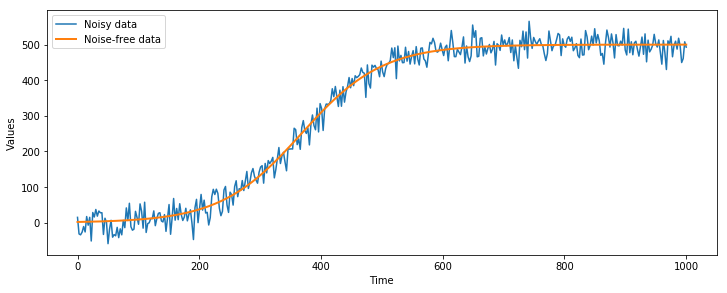

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

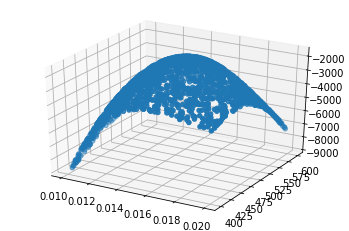

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(log_likelihood, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=1000, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 192)               24768     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               49408     
_________________________________________________________________
dense_5 (Dense)              (None, 320)               82240     
_________________________________________________________________
dense_6 (Dense)              (None, 384)               123264    
_________________________________________________________________
dense_7 (Dense)              (None, 384)               147840    
__________

In [15]:
emu([0.015, 500])

array([[-1861.0884]], dtype=float32)

In [16]:
log_likelihood([0.015, 500])

-1865.771572100548

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


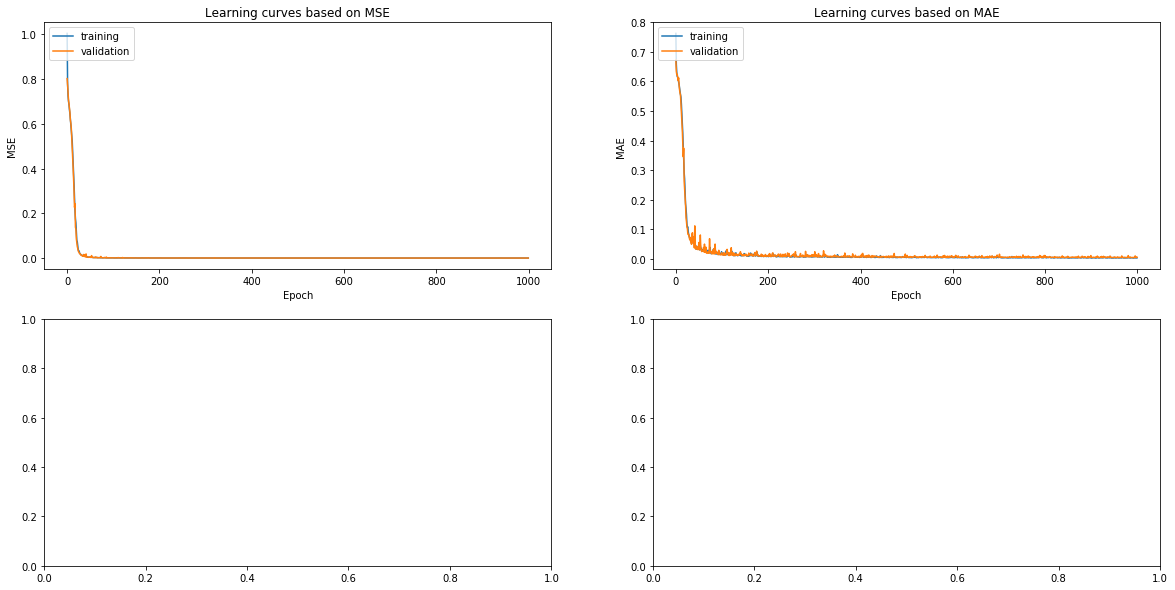

In [17]:
# summarize history for loss
print(hist.history.keys())
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))                 
ax1.title.set_text('Learning curves based on MSE')
ax2.title.set_text('Learning curves based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

#ax3.plot(hist.history['rescaled_mse'])
#ax3.plot(hist.history['val_rescaled_mse'])
#ax3.set_ylabel('Rescaled MSE')
#ax3.set_xlabel('Epoch')
#ax3.legend(['training', 'validation'], loc='upper left')

#ax4.plot(hist.history['rescaled_mae'])
#ax4.plot(hist.history['val_rescaled_mae'])
#ax4.set_ylabel('Rescaled MAE')
#ax4.set_xlabel('Epoch')
#ax4.legend(['training', 'validation'], loc='upper left')

plt.show()

In [18]:
val_mse = hist.history["val_loss"]
print("Minimum MSE during validation:", min(val_mse))
idx_mse = list(val_mse).index(min(val_mse))
print("Best epoch based on validation MSE:", idx_mse)
print("\n")


val_mae = hist.history["val_mean_absolute_error"]
print("Minimum MAE during validation:", min(val_mae))
idx_mae = list(val_mae).index(min(val_mae))
print("Best epoch based on validation MAE:", idx_mae)
print("\n")

print(val_mse[-1])
print(val_mae[-1])

Minimum MSE during validation: 7.961535186041147e-05
Best epoch based on validation MSE: 977


Minimum MAE during validation: 0.005012258732070525
Best epoch based on validation MAE: 987


0.0001002206098443518
0.00625816959887743


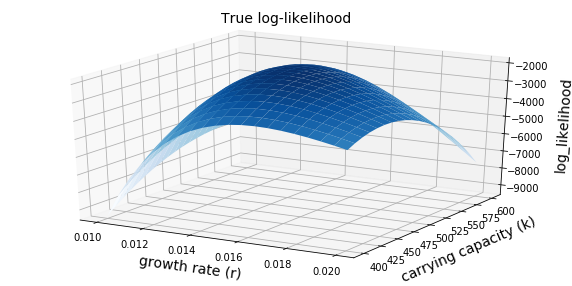

In [19]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

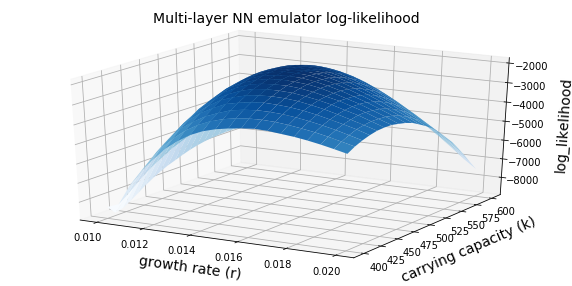

In [20]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, emu_prediction, title = "Multi-layer NN emulator log-likelihood",
                        x_label = "growth rate (r)",
                        y_label = "carrying capacity (k)")

In [21]:
print(model_prediction.shape)
mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
mape

(20, 20)


0.003015729932492003

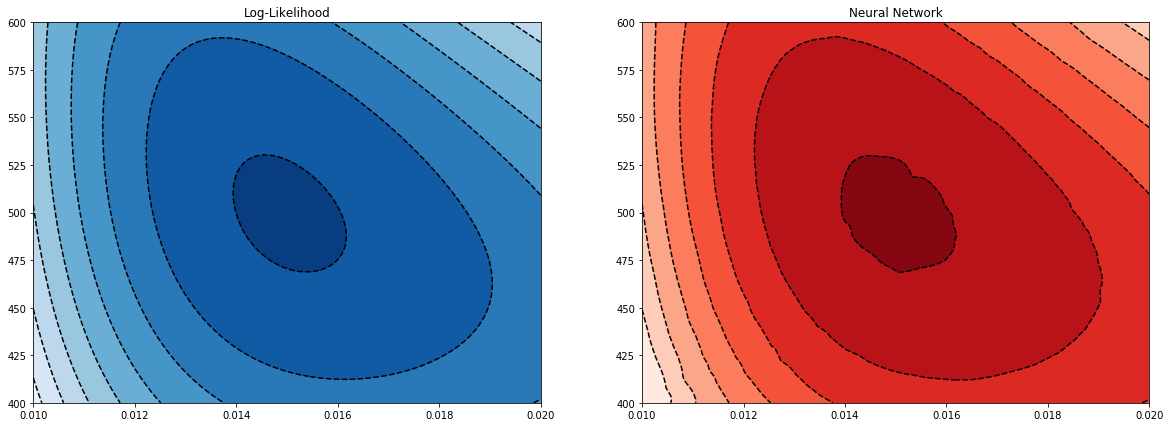

In [22]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

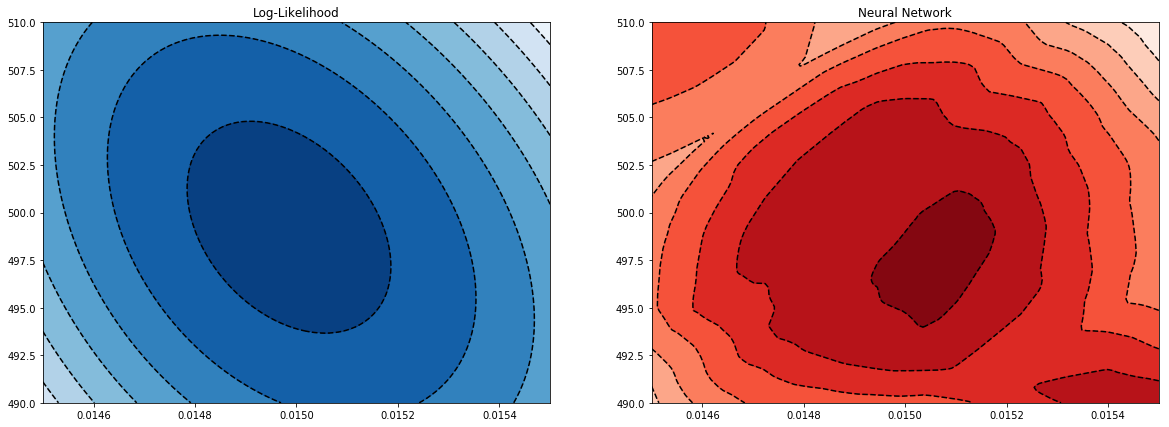

In [23]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0145, 490], [0.0155, 510], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

In [24]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

In [25]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
[4.30723838e-03 4.50368648e+02]
-inf


[-5.56264484e-03  5.22528938e+02]
-inf


[-3.69204508e-03  5.74386726e+02]
-inf


[6.51025500e-03 4.51326843e+02]
-inf


[1.69982459e-02 5.21049532e+02]
-2523.0986881958215


[-1.94608109e-03  5.69922116e+02]
-inf


[1.19952142e-02 4.47234319e+02]
-4220.441378111222


[2.0810728e-02 5.2486746e+02]
-inf


[1.30355729e-02 5.78299598e+02]
-2849.964349446477
accepted


[7.98032695e-03 4.50160319e+02]
-inf


[1.81972775e-02 5.26328146e+02]
-3255.4518542781952


[1.85629708e-02 5.82316668e+02]
-5349.233181470838


[1.50351830e-02 4.48922899e+02]
-2277.501847858648
accepted


[2.04776504e-02 5.21854070e+02]
-inf


[1.49458870e-02 5.73807668e+02]
-2760.9058986323917
accepted


[3.62525074e-02 4.48226866e+02]
-inf


[1.62509636e-02 5.24058486e+02]
-2260.431008455432


[-1.3634746e-03  5.7452153e+02]
-inf


[1.20474951e-02 4.46019225e+02]
-4182.351475688223


[1.67863323e-02 5.26048906e+02]
-2504.2058624491056


[3.32035588e-02 5.72317451e+02]
-i


[2.08282638e-02 5.19260335e+02]
-inf


[1.20727132e-02 5.67209314e+02]
-3295.4629192672965


[2.74703116e-02 4.45949184e+02]
-inf


[-6.81787020e-03  5.26061457e+02]
-inf


[2.91473246e-02 5.68835058e+02]
-inf


[2.21163662e-02 4.48699475e+02]
-inf


[2.82853400e-02 5.21617008e+02]
-inf


[2.61170292e-02 5.69741698e+02]
-inf


[1.23671313e-02 4.49506425e+02]
-3731.805629962332


[1.01776168e-02 5.25376610e+02]
-6324.876157194923


[2.23179440e-02 5.68180148e+02]
-inf


[1.27545775e-02 4.44940836e+02]
-3448.8629437035434


[1.65157491e-02 5.24319833e+02]
-2363.967885929666


[9.46689443e-03 5.68687488e+02]
-inf


[3.68708207e-02 4.45690711e+02]
-inf


[2.75685377e-02 5.20698913e+02]
-inf


[-4.10411481e-03  5.71619179e+02]
-inf


[2.50886414e-02 4.48998199e+02]
-inf


[2.37387097e-02 5.22777337e+02]
-inf


[6.78235678e-03 5.70893039e+02]
-inf


[1.23473857e-02 4.44971691e+02]
-3854.9288438049916


[2.66380840e-02 5.19246621e+02]
-inf


[3.93736726e-03 5.68083611e+02]
-inf


[2.51422921


[9.96181348e-04 4.61648620e+02]
-inf


[3.08628936e-02 5.19355088e+02]
-inf


[6.77306559e-03 5.68104642e+02]
-inf


[1.38926464e-02 4.63385690e+02]
-2359.137169103231


[-1.62237481e-02  5.20706251e+02]
-inf


[4.01499425e-03 5.67678936e+02]
-inf


[7.99778387e-03 4.59622240e+02]
-inf


[-8.12370257e-03  5.25511691e+02]
-inf


[1.91664935e-02 5.66411113e+02]
-5183.825908006221


[1.21690880e-02 4.59189926e+02]
-3755.102681124663


[4.32828512e-03 5.24380928e+02]
-inf


[1.39758908e-02 5.64552919e+02]
-2446.9261430799806
accepted


[8.78780792e-03 4.53530580e+02]
-inf


[3.55341973e-03 5.17486988e+02]
-inf


[3.26226399e-02 5.61480823e+02]
-inf


[-3.60257024e-03  4.60347777e+02]
-inf


[2.04640406e-02 5.20132797e+02]
-inf


[2.78671543e-02 5.64491618e+02]
-inf


[5.36405960e-03 4.59781917e+02]
-inf


[1.63674057e-02 5.23634267e+02]
-2297.2734361305256


[1.83117912e-02 5.63598944e+02]
-4399.497755897757


[1.23190418e-02 4.62320803e+02]
-3527.416539119883


[-1.16635514e-02  5.263696

[1.56072402e-02 4.62501693e+02]
-2064.775843422928
accepted


[1.42175532e-02 5.18362792e+02]
-1955.5707597185776


[1.42738584e-02 5.63055250e+02]
-2422.1098946161883
accepted


[1.56055696e-02 4.62316927e+02]
-2066.6631236286676


[1.46636879e-02 5.18432498e+02]
-1918.6486132728962


[1.39537969e-02 5.62883798e+02]
-2420.8363042227497
accepted


[1.50587347e-02 4.62004189e+02]
-2087.2005741549524


[1.4588926e-02 5.1826270e+02]
-1919.9595835772586


[1.38027282e-02 5.63011167e+02]
-2435.756770172583


[1.55749914e-02 4.62593869e+02]
-2062.984196992249
accepted


[1.43092658e-02 5.18516998e+02]
-1943.5687730822788


[1.38538908e-02 5.63002455e+02]
-2430.3527247272814


[1.56159889e-02 4.61507716e+02]
-2075.5547240101714


[1.47007431e-02 5.18401226e+02]
-1918.012778290905
accepted


[1.37825087e-02 5.62620717e+02]
-2432.1565453762246


[1.55378278e-02 4.62897629e+02]
-2059.0857697757046
accepted


[1.55257586e-02 5.18503885e+02]
-1999.6136285063683


[1.38260962e-02 5.62727461e+02]
-2

[1.56821052e-02 4.78529913e+02]
-1947.8752592642006


[1.48237500e-02 5.18617895e+02]
-1920.383341284836


[1.52603648e-02 5.32116125e+02]
-2086.1774249119976
accepted


[1.57116641e-02 4.83555947e+02]
-1931.8044797560606


[1.48304069e-02 5.18612802e+02]
-1920.5371102200274


[1.52176994e-02 5.32442529e+02]
-2082.2003350091513
accepted


[1.58005770e-02 4.86226826e+02]
-1936.8903213983062


[1.46899198e-02 5.18469354e+02]
-1918.467452112319


[1.43014984e-02 5.54477008e+02]
-2283.543842646306


[1.57575045e-02 4.90478171e+02]
-1926.435308639806
accepted


[1.48154010e-02 5.18369647e+02]
-1918.7569546682028


[1.54478240e-02 5.24224764e+02]
-2036.5317959640295
accepted


[1.57522780e-02 4.85360396e+02]
-1932.1331465564065


[1.47664497e-02 5.18071653e+02]
-1916.3133985740837
accepted


[1.54033267e-02 5.26152602e+02]
-2047.3334937840414


[1.57674051e-02 4.86311738e+02]
-1932.2388761286845


[1.47786003e-02 5.17635371e+02]
-1914.1100387846393
accepted


[1.55523695e-02 5.22177536e+02]


[1.53918958e-02 4.97376457e+02]
-1884.5746047743464
accepted


[1.49105721e-02 4.92089228e+02]
-1876.9975392432232


[1.50045608e-02 4.89431505e+02]
-1881.4142820650688


[1.54281311e-02 4.96618934e+02]
-1887.4395985477447


[1.49284648e-02 4.98166932e+02]
-1867.0329776648277
accepted


[1.52019055e-02 4.98651238e+02]
-1871.8398053951282


[1.54693276e-02 4.94920199e+02]
-1890.779264678419


[1.48410738e-02 5.05293941e+02]
-1872.003641301733


[1.51022942e-02 4.94743916e+02]
-1869.5848126708152


[1.54379347e-02 4.98103678e+02]
-1889.7440671949935


[1.48894583e-02 4.93185770e+02]
-1875.2323932340616


[1.52721824e-02 4.85627602e+02]
-1894.2064266720129


[1.52754949e-02 5.06070195e+02]
-1891.3410190129114


[1.50310750e-02 5.03435752e+02]
-1870.1806404341078


[1.5059178e-02 5.0428906e+02]
-1872.5431252566812


[1.54273270e-02 4.93482588e+02]
-1887.0636132186262


[1.49041293e-02 5.04086217e+02]
-1869.6681696128069


[1.52391584e-02 5.17218149e+02]
-1943.7050771596419


[1.53958217e-0

[1.48880711e-02 4.98249239e+02]
-1867.8916329870212


[1.49156935e-02 5.01946482e+02]
-1867.4641549877952
accepted


[1.49165803e-02 4.95789213e+02]
-1869.5292811381269


[1.49889241e-02 4.91004682e+02]
-1877.2262875293275


[1.48125934e-02 5.07131925e+02]
-1875.706512003095


[1.48982361e-02 4.97175504e+02]
-1868.4577435376439
accepted


[1.48594083e-02 4.99309277e+02]
-1868.199280857524


[1.49994445e-02 4.98554519e+02]
-1866.3535388728226
accepted


[1.49166522e-02 4.94107148e+02]
-1872.253269239087


[1.51038980e-02 4.93552631e+02]
-1871.1263678368136


[1.50220958e-02 4.95929218e+02]
-1867.8281707969147


[1.48618281e-02 4.96272523e+02]
-1870.7651111871387


[1.48984299e-02 4.97462926e+02]
-1868.1925854381097


[1.50179560e-02 5.01350402e+02]
-1867.4345331089069


[1.49151002e-02 4.99645012e+02]
-1866.8021351402497
accepted


[1.51511813e-02 4.98716670e+02]
-1869.554534276125


[1.46273429e-02 5.04268785e+02]
-1880.9916272273367


[1.49018317e-02 4.98544279e+02]
-1867.378234191232

[1.48755466e-02 4.96043503e+02]
-1870.5401893049748


[1.46446598e-02 4.99762227e+02]
-1880.675912056886


[1.51186991e-02 4.99733393e+02]
-1868.8557412893224


[1.48439101e-02 5.05034915e+02]
-1871.577362113159


[1.49428673e-02 4.96971867e+02]
-1867.615813547991


[1.51482222e-02 5.02344601e+02]
-1873.0257561182784


[1.49159531e-02 4.95420238e+02]
-1870.0664181949737


[1.50546446e-02 4.94626057e+02]
-1869.307475077917


[1.51481753e-02 5.02047210e+02]
-1872.565202655008


[1.47771829e-02 5.04341329e+02]
-1872.497361746665


[1.50080563e-02 4.95957868e+02]
-1867.8395235860607


[1.49747498e-02 4.96896576e+02]
-1867.2415159690913
accepted


[1.48078001e-02 4.98878170e+02]
-1870.44412910273
accepted


[1.48248333e-02 4.99976149e+02]
-1869.1864186251175


[1.49134980e-02 4.92969176e+02]
-1874.7430507820627


[1.47128358e-02 4.98660108e+02]
-1876.3035009255007


[1.49015232e-02 5.03224087e+02]
-1868.6627796331293


[1.51667293e-02 4.95707130e+02]
-1870.3516510548106


[1.50692854e-02 4.

[1.47857227e-02 4.97145766e+02]
-1873.352668866545


[1.50947170e-02 5.00431397e+02]
-1868.5393051427864


[1.50581477e-02 4.96349106e+02]
-1867.628883154807
accepted


[1.50228515e-02 4.98152956e+02]
-1866.5283300063295
accepted


[1.48570369e-02 4.98990872e+02]
-1868.4153830050543


[1.49359866e-02 4.98526952e+02]
-1866.75022409586
accepted


[1.49201068e-02 4.96700238e+02]
-1868.3524366152876


[1.50037878e-02 4.96381516e+02]
-1867.465240950434


[1.47882109e-02 4.99678673e+02]
-1870.9043056174019


[1.50040408e-02 4.96145615e+02]
-1867.6770741069915


[1.48326168e-02 4.98039291e+02]
-1869.998267668093


[1.49993060e-02 5.00970894e+02]
-1866.917398924822


[1.50538475e-02 5.05832943e+02]
-1875.6918233027286


[1.49524463e-02 4.99340578e+02]
-1866.3913167999046
accepted


[1.48754133e-02 4.92897199e+02]
-1876.557884993064


[1.51661328e-02 4.98880557e+02]
-1870.2530207729458


[1.51936809e-02 5.00282497e+02]
-1872.7117863394083


[1.50937680e-02 4.96832817e+02]
-1867.8722535442357






[1.49701109e-02 4.99496225e+02]
-1866.304936883793
accepted


[1.50409269e-02 5.04492213e+02]
-1872.3082037177403


[1.52735378e-02 4.94677374e+02]
-1875.6434195217146


[1.51609548e-02 4.98863708e+02]
-1870.0210505630412


[1.49956444e-02 4.97712925e+02]
-1866.61272114542
accepted


[1.46499320e-02 5.09584692e+02]
-1886.6254836832147


[1.48349368e-02 5.01782061e+02]
-1868.8990362430147


[1.49893864e-02 4.95237738e+02]
-1868.8095435624857
accepted


[1.48574954e-02 4.94209583e+02]
-1874.486680475087


[1.47223203e-02 5.01802291e+02]
-1873.9351299878524


[1.50239818e-02 4.92152279e+02]
-1873.7568901749526


[1.50590786e-02 5.01359872e+02]
-1868.3106838820117
accepted


[1.48914910e-02 5.00200771e+02]
-1867.2078786332352
accepted


[1.50569002e-02 4.98641091e+02]
-1866.8805173266458
accepted


[1.50935992e-02 5.00424039e+02]
-1868.4982109787518
accepted


[1.47970693e-02 4.98234087e+02]
-1871.496035730879


[1.49842817e-02 4.99407862e+02]
-1866.2902388846958
accepted


[1.50209371e-

-1911.9673769841677


[1.46601231e-02 5.03627806e+02]
-1878.2961000019088


[1.48535684e-02 5.03773027e+02]
-1869.8440600804183


[1.50566560e-02 5.05361411e+02]
-1874.6984706983346


[1.49980689e-02 4.95423164e+02]
-1868.4908650617472


[1.52599001e-02 4.96878493e+02]
-1874.4351686044477


[1.47428847e-02 5.08139188e+02]
-1879.5094451543


[1.50133873e-02 4.98690265e+02]
-1866.392038509175
accepted


[1.49758513e-02 5.02412410e+02]
-1867.8883158994201


[1.50020229e-02 5.00464470e+02]
-1866.6636073176865
accepted


[1.48133943e-02 5.00103333e+02]
-1869.6050839542902


[1.49682192e-02 4.99357617e+02]
-1866.307144050903
accepted


[1.49597358e-02 4.97007129e+02]
-1867.3260687797972


[1.49955481e-02 4.98900844e+02]
-1866.3065326550716
accepted


[1.49734448e-02 4.94695566e+02]
-1869.8005745510359


[1.53685007e-02 4.99224120e+02]
-1884.3412615336142


[1.47088998e-02 5.02550882e+02]
-1874.7985544512865


[1.51385545e-02 4.95131709e+02]
-1869.9300683287254


[1.50695203e-02 4.96932020e+0

-1871.5509993954454


[1.50026091e-02 4.97966888e+02]
-1866.5075928583067
accepted


[1.50458398e-02 4.99097333e+02]
-1866.7561756043751
accepted


[1.48601664e-02 4.99742206e+02]
-1868.0417682950936


[1.50956918e-02 5.00921103e+02]
-1868.9912550151867


[1.50545566e-02 4.96412146e+02]
-1867.5533812978
accepted


[1.49029549e-02 4.97964843e+02]
-1867.689986827888
accepted


[1.50994522e-02 4.95369994e+02]
-1868.9257150755827


[1.52998589e-02 4.91522216e+02]
-1880.268966296949


[1.50584557e-02 4.95092156e+02]
-1868.7661838382076


[1.50259768e-02 4.92946855e+02]
-1872.0980526656172


[1.49876994e-02 4.95001916e+02]
-1869.1436335426997
accepted


[1.48288169e-02 5.03742624e+02]
-1870.3413894934945


[1.49759808e-02 5.00807631e+02]
-1866.6669588536904
accepted


[1.51327986e-02 4.90974361e+02]
-1876.2068368947748


[1.48248035e-02 4.97921933e+02]
-1870.4494044661915


[1.50349980e-02 4.94330442e+02]
-1869.7128448272565


[1.48526910e-02 4.94534024e+02]
-1874.0693658266139


[1.50122994

-1873.392444383583


[1.52420263e-02 5.02664512e+02]
-1879.5149644647206


[1.51021425e-02 4.97579098e+02]
-1867.8454034319627
accepted


[1.53156182e-02 5.00373726e+02]
-1881.3097639246755


[1.47649476e-02 5.04325458e+02]
-1872.948365343876


[1.48956354e-02 5.03699606e+02]
-1869.2313628808167


[1.46166132e-02 4.97700700e+02]
-1886.0819665633867


[1.49799541e-02 4.96229130e+02]
-1867.7834972038013
accepted


[1.49684697e-02 5.01240213e+02]
-1866.8827235735062
accepted


[1.53229900e-02 5.03897872e+02]
-1889.404846998756


[1.49073392e-02 4.92535783e+02]
-1876.0106317283703


[1.51827456e-02 4.93666390e+02]
-1872.6244505696395


[1.52760330e-02 5.02711032e+02]
-1882.287656889095


[1.49651867e-02 4.94412779e+02]
-1870.4025137067977


[1.50094092e-02 4.99068659e+02]
-1866.361806698628
accepted


[1.48394021e-02 5.00013570e+02]
-1868.6468523011674
accepted


[1.49904075e-02 4.84500324e+02]
-1901.6035714179268


[1.51171816e-02 4.99858547e+02]
-1868.8826302977368


[1.48918580e-02 5.03

-1872.6262447687268


[1.48577637e-02 5.00814599e+02]
-1868.0377819337803
accepted


[1.49707958e-02 4.99879562e+02]
-1866.3468730759191
accepted


[1.52721965e-02 4.99217711e+02]
-1876.54075813308


[1.47769537e-02 5.01322423e+02]
-1871.0328344483391


[1.49900850e-02 5.03208292e+02]
-1868.9994752078053


[1.50205101e-02 4.94807479e+02]
-1869.1128105313098


[1.48212877e-02 5.02209839e+02]
-1869.4851232692622


[1.49974718e-02 4.97497420e+02]
-1866.713777844341
accepted


[1.52551427e-02 4.99684431e+02]
-1875.8454656814881


[1.48646215e-02 4.98458115e+02]
-1868.4673497262665


[1.48662080e-02 4.96094332e+02]
-1870.8346446208905


[1.52095092e-02 4.96411969e+02]
-1871.7929008562376


[1.51112914e-02 5.01595170e+02]
-1870.2915621249049


[1.53232648e-02 4.84834451e+02]
-1898.6222382813817


[1.51589871e-02 4.95227825e+02]
-1870.4141514812663
accepted


[1.48956146e-02 4.98784070e+02]
-1867.4128002218356
accepted


[1.50323421e-02 4.94336857e+02]
-1869.7127179023298


[1.53123098e-02 4.



[1.52094312e-02 4.98547804e+02]
-1872.1772507780202


[1.51202490e-02 5.01712597e+02]
-1870.80661518957


[1.50765435e-02 5.00542913e+02]
-1868.08288874051


[1.49692247e-02 4.94884991e+02]
-1869.5915417592958


[1.49262346e-02 5.02967851e+02]
-1868.2835576074522


[1.48487088e-02 5.01779744e+02]
-1868.5146223284014


[1.50699528e-02 4.97216349e+02]
-1867.3095156202658
accepted


[1.49206447e-02 5.02136698e+02]
-1867.5638529507146


[1.47685868e-02 5.05556444e+02]
-1874.2125979719767


[1.46885751e-02 5.07010373e+02]
-1879.7473698026524


[1.47635872e-02 5.03627808e+02]
-1872.435008473865


[1.48981146e-02 5.01368997e+02]
-1867.3478524495272


[1.47901988e-02 4.97859627e+02]
-1872.239144414759


[1.47579856e-02 4.99622476e+02]
-1872.546111132951


[1.47933712e-02 4.99648982e+02]
-1870.6687711150353


[1.49486028e-02 4.97430037e+02]
-1867.162960009606
accepted


[1.49966588e-02 4.96060158e+02]
-1867.8036801741587
accepted


[1.48746723e-02 5.01741047e+02]
-1867.9089397400344


[1.5000

-1870.4685732566063


[1.47436858e-02 5.03476585e+02]
-1873.2426946500436


[1.50849803e-02 5.03521466e+02]
-1872.110774638265


[1.51234719e-02 4.97622097e+02]
-1868.4112945490147


[1.46548359e-02 5.02580984e+02]
-1878.5026107270344


[1.50867586e-02 5.07407924e+02]
-1881.5456165169987


[1.48504660e-02 5.09170703e+02]
-1880.2706118499734


[1.49566764e-02 5.03784093e+02]
-1869.3876906590372


[1.49773775e-02 5.03738006e+02]
-1869.5556818181924
accepted


[1.49376478e-02 4.99605789e+02]
-1866.5098471951248
accepted


[1.50441074e-02 4.96143417e+02]
-1867.6833226200233
accepted


[1.52282919e-02 4.95276204e+02]
-1873.0372949520283


[1.50106195e-02 5.02233273e+02]
-1868.1530552991421
accepted


[1.48581937e-02 5.02143221e+02]
-1868.4535700444937


[1.50235584e-02 5.02004769e+02]
-1868.146367080976
accepted


[1.49767775e-02 5.07406796e+02]
-1877.119411333229


[1.52117035e-02 4.87539740e+02]
-1886.4941658068499


[1.50523552e-02 5.08795729e+02]
-1884.219612979023


[1.51297298e-02 4.9


[1.49026269e-02 4.96815300e+02]
-1868.6940048690162


[1.49403367e-02 5.06820067e+02]
-1874.894346207376


[1.50023774e-02 4.97272809e+02]
-1866.8276040284425
accepted


[1.49057170e-02 4.99486802e+02]
-1866.9854218786443
accepted


[1.49449323e-02 4.93125269e+02]
-1873.3332801594568


[1.49669986e-02 5.04221735e+02]
-1870.1551215509494


[1.49768157e-02 5.00814246e+02]
-1866.6733448981777
accepted


[1.50031465e-02 4.97941878e+02]
-1866.5167644071994
accepted


[1.50162004e-02 5.01915702e+02]
-1867.9188113965997


[1.49844134e-02 4.94026437e+02]
-1870.6917780248982


[1.49621633e-02 5.06217137e+02]
-1873.8828357803388


[1.53330134e-02 4.91118321e+02]
-1882.6691309660735


[1.49380292e-02 5.01327960e+02]
-1866.9521056549672


[1.48455860e-02 5.07798169e+02]
-1876.762991352182


[1.50687840e-02 4.96443625e+02]
-1867.679948787599
accepted


[1.50179360e-02 4.94619951e+02]
-1869.3834016930643


[1.48797791e-02 4.99508969e+02]
-1867.5558109389203
accepted


[1.52547947e-02 4.96495682e+02

-1867.9499869780066


[1.48825392e-02 4.98380823e+02]
-1867.9649742322842


[1.51809717e-02 5.03656301e+02]
-1877.352499905748


[1.52061378e-02 4.96928762e+02]
-1871.5884955316285


[1.50680282e-02 5.02266188e+02]
-1869.5891184927107


[1.46678673e-02 5.00800935e+02]
-1877.976838584389


[1.51832166e-02 4.97832264e+02]
-1870.6328966497172


[1.49992883e-02 5.00199618e+02]
-1866.528590875682
accepted


[1.50568915e-02 4.96656356e+02]
-1867.4179895455786


[1.51466626e-02 4.99462472e+02]
-1869.7548683765572


[1.48488870e-02 5.03656899e+02]
-1869.8129644005526


[1.49952109e-02 4.99690564e+02]
-1866.358119137392
accepted


[1.52161449e-02 4.99296102e+02]
-1873.0503446395119


[1.48941580e-02 5.02294076e+02]
-1867.9233641214582


[1.49762141e-02 5.06229239e+02]
-1874.1959166296394


[1.49703704e-02 4.99985627e+02]
-1866.367663497834
accepted


[1.49375179e-02 5.06069136e+02]
-1873.1907555849905


[1.50828610e-02 4.98493051e+02]
-1867.374954419765
accepted


[1.49989391e-02 5.04030886e+02

-1869.4122279826972


[1.52014561e-02 4.98810158e+02]
-1871.9074154108005


[1.50398061e-02 4.96446783e+02]
-1867.4288822575404
accepted


[1.50363792e-02 5.00859434e+02]
-1867.3781797548954
accepted


[1.50100326e-02 5.07314013e+02]
-1877.8804964134695


[1.50666050e-02 4.97009477e+02]
-1867.3466508314848
accepted


[1.50857401e-02 5.01687805e+02]
-1869.459818520945


[1.50511391e-02 4.94367650e+02]
-1869.6434307139807


[1.53511210e-02 4.93846365e+02]
-1880.9518316269232


[1.50272592e-02 4.98712679e+02]
-1866.4971563527724
accepted


[1.50279372e-02 4.97812432e+02]
-1866.6518732814654
accepted


[1.46087847e-02 5.03468682e+02]
-1882.2823918580252


[1.51549734e-02 4.93312897e+02]
-1872.3374706266225


[1.48562406e-02 4.96923249e+02]
-1870.1660706014345


[1.48491778e-02 4.98861763e+02]
-1868.7540110906266


[1.52744016e-02 5.00354487e+02]
-1878.0245559846794


[1.47761315e-02 4.96550019e+02]
-1874.791236931568


[1.49816227e-02 4.93455900e+02]
-1871.7700689449223


[1.51701021e-02 4

[1.49934677e-02 4.98633956e+02]
-1866.3329396069355


[1.51234778e-02 4.96738272e+02]
-1868.5922012381961
accepted


[1.50022715e-02 5.14997356e+02]
-1908.215922087231


[1.47585585e-02 5.09619674e+02]
-1882.5587493740798


[1.50995496e-02 4.97340373e+02]
-1867.829512919995
accepted


[1.51754521e-02 4.94468033e+02]
-1871.5532154762534


[1.48730180e-02 5.00101163e+02]
-1867.630636537585
accepted


[1.48961246e-02 4.99268374e+02]
-1867.2299875858482
accepted


[1.49298289e-02 5.11586269e+02]
-1889.4666772043377


[1.49023038e-02 4.96056054e+02]
-1869.5990909335062


[1.49071328e-02 4.96267911e+02]
-1869.1865178271128


[1.49102157e-02 4.99441592e+02]
-1866.9105967546489
accepted


[1.51247492e-02 4.95554123e+02]
-1869.2690610428003


[1.48786715e-02 4.97829516e+02]
-1868.4695008075007


[1.47577791e-02 5.09259787e+02]
-1881.6551733859637


[1.49314531e-02 4.96695777e+02]
-1868.0970580058427
accepted


[1.50041952e-02 5.02208936e+02]
-1868.0225059191034


[1.46149731e-02 4.96743648e+02]

-1867.8948926219132


[1.45066876e-02 4.95771710e+02]
-1903.66014634828


[1.49374673e-02 5.01394187e+02]
-1866.9910247671576
accepted


[1.49847664e-02 4.89216086e+02]
-1882.686925505947


[1.48643725e-02 4.97105643e+02]
-1869.644487328335


[1.46716017e-02 5.12505366e+02]
-1893.6437940605058


[1.49757163e-02 4.98665482e+02]
-1866.353641509744
accepted


[1.48098765e-02 5.01805334e+02]
-1869.7318145097042


[1.48968069e-02 4.99667494e+02]
-1867.1328772030824
accepted


[1.46838834e-02 5.05942120e+02]
-1878.550681516541


[1.50189043e-02 5.03190199e+02]
-1869.5183051526794


[1.50366738e-02 4.94645715e+02]
-1869.2725667038737


[1.48470350e-02 5.00542444e+02]
-1868.3351676497991


[1.43819103e-02 5.13041942e+02]
-1917.6634288213834


[1.50296504e-02 5.04924643e+02]
-1872.8072376919497


[1.51375471e-02 5.03190308e+02]
-1873.9239348539656


[1.48312944e-02 4.99307145e+02]
-1869.189515719732


[1.49898967e-02 4.95005794e+02]
-1869.1109722743874


[1.49834395e-02 5.00138870e+02]
-1866.42

[1.47785997e-02 5.05847931e+02]
-1874.2948464755889


[1.49284642e-02 4.94496211e+02]
-1871.1749766831306


[1.48885704e-02 4.96315045e+02]
-1869.711504455366


[1.50225375e-02 5.01889377e+02]
-1868.0076080759675


[1.48269861e-02 5.02141061e+02]
-1869.2774806765517


[1.45564022e-02 5.10622528e+02]
-1895.0048006977113


[1.50798837e-02 5.00474937e+02]
-1868.1259466406636


[1.48544728e-02 5.00875486e+02]
-1868.1339697152757


[1.46191946e-02 5.07869834e+02]
-1885.226568541719


[1.51401958e-02 5.01888487e+02]
-1871.943472609456


[1.49975788e-02 5.01510505e+02]
-1867.2855395941506


[1.51854338e-02 4.97300831e+02]
-1870.6626916729322


[1.47617648e-02 4.99020394e+02]
-1872.7534433712574


[1.51359453e-02 4.98800554e+02]
-1869.0074423920994


[1.46345618e-02 5.05406783e+02]
-1881.180348846714


[1.47478427e-02 5.08363725e+02]
-1879.831946449907


[1.48837497e-02 5.04889439e+02]
-1870.9142397360408


[1.48384247e-02 5.04092954e+02]
-1870.4842672815469


[1.46492436e-02 5.02852296e+02]
-

[1.52437381e-02 4.96291888e+02]
-1873.510010952906


[1.51510680e-02 5.00026027e+02]
-1870.354310772592


[1.45769302e-02 5.14110245e+02]
-1903.4945758447166


[1.50734940e-02 4.95199484e+02]
-1868.7597208071272


[1.51852785e-02 5.01078750e+02]
-1873.1841025222222


[1.43038781e-02 5.09909578e+02]
-1922.8219425334062


[1.51875310e-02 4.95065308e+02]
-1871.4754872762358


[1.49779948e-02 5.05562142e+02]
-1872.7854182569956


[1.52211232e-02 4.91474167e+02]
-1877.0733950275567


[1.50055781e-02 4.99304120e+02]
-1866.3553730721899
accepted


[1.49878146e-02 4.97259777e+02]
-1866.885462466311
accepted


[1.45742475e-02 5.02983146e+02]
-1885.4503746315434


[1.49616913e-02 5.04570313e+02]
-1870.6573135040408


[1.50184498e-02 4.97973273e+02]
-1866.5494076945868
accepted


[1.49491845e-02 5.04113359e+02]
-1869.8024972832359
accepted


[1.50339674e-02 4.97078079e+02]
-1867.000228111653
accepted


[1.48451951e-02 5.02494188e+02]
-1868.9594732640119


[1.51200599e-02 5.02644928e+02]
-1872.140


[1.51518866e-02 4.88667122e+02]
-1882.3365168374712


[1.49677984e-02 5.01654911e+02]
-1867.1630328261847
accepted


[1.49589221e-02 4.91271457e+02]
-1877.3694596720038


[1.50185430e-02 4.99467677e+02]
-1866.4823565097374


[1.52691737e-02 4.96742016e+02]
-1874.9724644714584


[1.49300363e-02 4.99182867e+02]
-1866.6455121363406
accepted


[1.50059593e-02 5.02354891e+02]
-1868.2083400227584
accepted


[1.48853924e-02 5.00885330e+02]
-1867.4091763285812
accepted


[1.46660523e-02 5.05627519e+02]
-1879.2663686056917


[1.54769826e-02 5.02291371e+02]
-1902.3158367195756


[1.47416700e-02 5.02721659e+02]
-1872.9970410555377


[1.49999503e-02 4.96736964e+02]
-1867.1921604031993


[1.49036971e-02 5.02659735e+02]
-1868.1096491015662
accepted


[1.48443454e-02 4.98000432e+02]
-1869.5482384570114


[1.48533617e-02 4.94542212e+02]
-1874.0205744466414


[1.49127987e-02 4.99212386e+02]
-1866.9109135033073
accepted


[1.51854541e-02 4.94800503e+02]
-1871.5982102941948


[1.47426713e-02 4.92580689e



[1.48656463e-02 5.00311745e+02]
-1867.8097716751636


[1.49092767e-02 5.03956686e+02]
-1869.480827374753
accepted


[1.52376862e-02 4.91408692e+02]
-1877.7557603994362


[1.51256872e-02 4.98808918e+02]
-1868.6502022531479


[1.48089737e-02 5.06423079e+02]
-1874.4403933372848


[1.52010239e-02 4.95173990e+02]
-1871.9171552484654


[1.48495602e-02 5.03226257e+02]
-1869.398460150345


[1.48634797e-02 5.08888170e+02]
-1879.4999727118886


[1.52076560e-02 5.00880458e+02]
-1874.2274371952437


[1.49454693e-02 4.99460345e+02]
-1866.4408588396873
accepted


[1.49698028e-02 5.00914198e+02]
-1866.7025481885792
accepted


[1.50934869e-02 5.04133955e+02]
-1873.618836209691


[1.48180930e-02 4.94414881e+02]
-1876.1682346394293


[1.50358578e-02 4.97975052e+02]
-1866.6695984052444
accepted


[1.52098074e-02 4.92654891e+02]
-1874.8069990002998


[1.54120547e-02 4.91844987e+02]
-1887.0253117672562


[1.49348419e-02 4.98469652e+02]
-1866.7894368551333


[1.50937210e-02 5.02924539e+02]
-1871.458468109

[1.48004954e-02 5.02504238e+02]
-1870.3263800790785


[1.51287204e-02 4.96535127e+02]
-1868.8087977740277


[1.50793366e-02 4.96981832e+02]
-1867.549701742089


[1.51299550e-02 4.97297057e+02]
-1868.6362621483288


[1.48949804e-02 5.00062724e+02]
-1867.1384402491901
accepted


[1.46280388e-02 4.94971337e+02]
-1890.670201283003


[1.49155874e-02 4.97676831e+02]
-1867.5962741344115
accepted


[1.49479871e-02 5.00927072e+02]
-1866.7173728778516
accepted


[1.47172532e-02 5.04185412e+02]
-1875.050035653702


[1.52389361e-02 4.96898270e+02]
-1873.2469604311452


[1.49029467e-02 4.99265710e+02]
-1867.0862177727765
accepted


[1.50350771e-02 4.95690642e+02]
-1868.0616322865783


[1.50221406e-02 4.92285467e+02]
-1873.4910570545474


[1.51789350e-02 4.86682355e+02]
-1888.9360558729556


[1.50419901e-02 4.99598558e+02]
-1866.819335880346
accepted


[1.49381569e-02 4.98875135e+02]
-1866.6087362597148
accepted


[1.48447129e-02 4.97670289e+02]
-1869.834588141448


[1.48262309e-02 5.03714267e+02]
-



[1.51856200e-02 5.04526171e+02]
-1879.6494166900382


[1.45827929e-02 4.95811799e+02]
-1893.7136395278553


[1.48679222e-02 5.00751445e+02]
-1867.7700075283703
accepted


[1.49815562e-02 5.03302555e+02]
-1869.0029127309467
accepted


[1.50197603e-02 4.86646448e+02]
-1890.9744047281977


[1.47746349e-02 5.03737060e+02]
-1872.064382515152


[1.51103665e-02 5.07290426e+02]
-1882.5203247722186


[1.49807870e-02 4.99249501e+02]
-1866.2838464633367
accepted


[1.46003578e-02 5.04550252e+02]
-1883.310659645327


[1.50005151e-02 5.08358452e+02]
-1880.580660725716


[1.49999121e-02 4.95921140e+02]
-1867.9220152680393


[1.51555498e-02 4.98264247e+02]
-1869.5778255120106


[1.49933750e-02 5.04782196e+02]
-1871.5754070225992


[1.51297629e-02 5.01012768e+02]
-1870.3797549214207


[1.54710393e-02 4.88034652e+02]
-1897.6069622444895


[1.4961034e-02 4.9635108e+02]
-1867.9043051580281
accepted


[1.53344111e-02 5.03795222e+02]
-1890.2539561247638


[1.48875907e-02 5.05190589e+02]
-1871.36867317654

[1.48831388e-02 4.93989556e+02]
-1873.765360052493


[1.50623461e-02 4.82507327e+02]
-1908.821957596559


[1.48602208e-02 4.96171637e+02]
-1870.971110207233


[1.47180865e-02 5.07182567e+02]
-1878.6349044891103


[1.47360931e-02 4.96622207e+02]
-1877.3948952068367


[1.54321890e-02 4.95769645e+02]
-1887.4101236298186


[1.43924158e-02 5.04162312e+02]
-1907.2945719760291


[1.47904370e-02 4.98636041e+02]
-1871.483946405828


[1.50700338e-02 4.99159659e+02]
-1867.215461209435
accepted


[1.51474963e-02 4.91255942e+02]
-1875.775263301154


[1.50750667e-02 4.97250634e+02]
-1867.3775115796923
accepted


[1.53053209e-02 4.95120477e+02]
-1877.3483429970731


[1.47400374e-02 5.00059841e+02]
-1873.3561293015277


[1.48931222e-02 5.02866568e+02]
-1868.3937417480504


[1.47142803e-02 5.09720886e+02]
-1884.106727461298


[1.49710098e-02 5.01083999e+02]
-1866.798038485381
accepted


[1.48429247e-02 4.96030747e+02]
-1871.9390435222617


[1.50497803e-02 5.02940358e+02]
-1869.958077857029


[1.5040998

accepted


[1.47046070e-02 5.01950233e+02]
-1875.0293150267964


[1.48410782e-02 4.97978938e+02]
-1869.6983763169517


[1.49304672e-02 5.04455841e+02]
-1870.2061733776466


[1.49092743e-02 5.15377370e+02]
-1905.638669533602


[1.4911345e-02 4.9939224e+02]
-1866.899208858416
accepted


[1.50632341e-02 5.09991317e+02]
-1889.1096635682852


[1.47013973e-02 5.09037981e+02]
-1882.9791096293661


[1.47059115e-02 5.06468783e+02]
-1878.0784657453346


[1.49300946e-02 5.02939675e+02]
-1868.2489213109486
accepted


[1.47217579e-02 5.02429055e+02]
-1874.012900874651


[1.49963407e-02 4.99936731e+02]
-1866.4227041253846
accepted


[1.49201922e-02 5.00867726e+02]
-1866.883883581766
accepted


[1.48010799e-02 4.98654650e+02]
-1870.931096282237


[1.50993162e-02 4.95359671e+02]
-1868.9326716033243
accepted


[1.48151092e-02 5.11741832e+02]
-1888.3914146287839


[1.49838370e-02 4.95341915e+02]
-1868.7431361635693
accepted


[1.49225367e-02 5.01015274e+02]
-1866.9134839406768
accepted


[1.50418904e-02

[1.51266395e-02 4.93623907e+02]
-1871.3457962303926


[1.46088003e-02 5.10460611e+02]
-1891.0105288603115


[1.52458198e-02 4.95565223e+02]
-1873.7774860206778


[1.53533016e-02 5.02186409e+02]
-1888.1412607808754


[1.48568142e-02 5.00286468e+02]
-1868.0558988823334


[1.47341472e-02 4.90792586e+02]
-1892.7784367511508


[1.52961443e-02 4.96522466e+02]
-1876.6567495449121


[1.50930928e-02 5.02361452e+02]
-1870.5886435332


[1.47909079e-02 4.95146455e+02]
-1876.3300773634244


[1.48276474e-02 5.01082171e+02]
-1868.9797017961707


[1.51155391e-02 4.95074202e+02]
-1869.4765017390457


[1.49871983e-02 4.92788865e+02]
-1872.995283542471


[1.51305819e-02 5.07921133e+02]
-1885.8296252122188


[1.49642799e-02 4.94392322e+02]
-1870.4547057235025


[1.46464321e-02 4.96638191e+02]
-1885.030068445839


[1.50274458e-02 4.98306667e+02]
-1866.5333896761927
accepted


[1.49041923e-02 5.02385888e+02]
-1867.8814592326053


[1.47966472e-02 4.86950554e+02]
-1902.8655832141578


[1.53213041e-02 5.007338

-1870.6773200220018


[1.49925098e-02 4.94166850e+02]
-1870.3322785071912
accepted


[1.47624441e-02 5.01251212e+02]
-1871.7428107278317


[1.52597225e-02 4.95467880e+02]
-1874.5463955290406


[1.49970994e-02 4.86442114e+02]
-1892.5940072835012


[1.47832024e-02 5.02701540e+02]
-1871.081485287937
accepted


[1.48518055e-02 5.02246533e+02]
-1868.6566298391772
accepted


[1.47975850e-02 4.95876407e+02]
-1874.5828393666613


[1.46621264e-02 5.12340960e+02]
-1893.483496824209


[1.49511679e-02 5.06320350e+02]
-1873.9219206575092


[1.51558555e-02 4.95296071e+02]
-1870.2713447185502
accepted


[1.48434488e-02 4.99450853e+02]
-1868.6769764155151
accepted


[1.47227885e-02 4.84867564e+02]
-1920.8662805898261


[1.49555890e-02 4.87948772e+02]
-1888.2774718701392


[1.44805277e-02 4.97500441e+02]
-1903.1401251561317


[1.48154569e-02 4.95577073e+02]
-1874.0762694668422


[1.51227641e-02 4.83808909e+02]
-1900.8925668580848


[1.47347259e-02 5.11397393e+02]
-1888.212977840857


[1.45547888e-02 5.

[1.54354876e-02 4.91051672e+02]
-1889.7545935153623


[1.47256569e-02 4.96468694e+02]
-1878.438003012203


[1.51438434e-02 4.96599768e+02]
-1869.223322601657


[1.54308509e-02 4.91841995e+02]
-1888.5125224928852


[1.50341394e-02 5.00304713e+02]
-1866.9923874341796


[1.50846502e-02 5.14827821e+02]
-1913.0663979371107


[1.49018098e-02 4.94249178e+02]
-1872.5088962975417


[1.48976019e-02 4.93367682e+02]
-1874.4795169833399


[1.50019168e-02 4.94974464e+02]
-1869.0244735762783


[1.51078403e-02 4.96095509e+02]
-1868.535482120679


[1.52071811e-02 5.04385000e+02]
-1880.8137692150283


[1.50136608e-02 5.01181873e+02]
-1867.2374536535322
accepted


[1.49571094e-02 4.98408093e+02]
-1866.545782337627
accepted


[1.49480361e-02 4.96184705e+02]
-1868.3019322319751
accepted


[1.49349048e-02 4.97471105e+02]
-1867.3573216209568


[1.53201925e-02 4.95086420e+02]
-1878.3303144782687


[1.46292716e-02 5.00418342e+02]
-1881.4806950487339


[1.52374326e-02 4.88814027e+02]
-1883.4152962254113


[1.48

[1.51981540e-02 4.96350286e+02]
-1871.300839383409


[1.51474681e-02 4.90380214e+02]
-1877.7351433874046


[1.49202806e-02 4.97638014e+02]
-1867.5224065253744
accepted


[1.53808111e-02 4.97009112e+02]
-1883.3390929023974


[1.50982490e-02 4.94894171e+02]
-1869.366365780837


[1.48484116e-02 5.02333930e+02]
-1868.7867521052171


[1.51722287e-02 4.98046236e+02]
-1870.2043121983213


[1.50425747e-02 4.89838131e+02]
-1879.3829410522208


[1.46954073e-02 4.92134388e+02]
-1891.9117362024751


[1.51024285e-02 4.99581767e+02]
-1868.2306865140883
accepted


[1.50267368e-02 5.00193464e+02]
-1866.8232599958858
accepted


[1.51450932e-02 5.01200367e+02]
-1871.2761575023915


[1.53479013e-02 4.92336879e+02]
-1881.9757358023392


[1.52136889e-02 4.93606517e+02]
-1873.7462626468757


[1.51435102e-02 5.05196440e+02]
-1878.6210605870833


[1.50697565e-02 4.95835957e+02]
-1868.1335225874898
accepted


[1.45874931e-02 5.14019538e+02]
-1902.5838647726919


[1.51554945e-02 4.93603335e+02]
-1871.9617722444

[1.50103654e-02 4.96906314e+02]
-1867.0463123425334
accepted


[1.49851419e-02 4.98819969e+02]
-1866.3071529668707
accepted


[1.48469475e-02 4.99762376e+02]
-1868.4536883083574
accepted


[1.51063364e-02 4.93412682e+02]
-1871.362548165582
accepted


[1.50550200e-02 4.98799755e+02]
-1866.862037650321
accepted


[1.52073889e-02 4.99110098e+02]
-1872.4202440029362


[1.50707849e-02 4.98282112e+02]
-1867.11802786673
accepted


[1.47936480e-02 4.99786614e+02]
-1870.5912139304546


[1.50014175e-02 4.98251916e+02]
-1866.420382667013
accepted


[1.52667807e-02 5.02971851e+02]
-1882.0962296282667


[1.52875059e-02 5.01776394e+02]
-1881.3506386637525


[1.49231663e-02 5.00888293e+02]
-1866.8609041801963


[1.49734768e-02 5.04427999e+02]
-1870.5829778923307


[1.51510302e-02 5.02988035e+02]
-1874.268555009803


[1.49843732e-02 4.99254144e+02]
-1866.28393665466
accepted


[1.50475688e-02 5.02526983e+02]
-1869.3257032910724


[1.50271053e-02 4.99387019e+02]
-1866.557707649157
accepted


[1.4995112

[1.47893316e-02 5.01504706e+02]
-1870.488318496004


[1.52411086e-02 4.95855659e+02]
-1873.4493027728795


[1.48485002e-02 5.04198787e+02]
-1870.4094398499103


[1.51519204e-02 4.91147628e+02]
-1876.067905926734


[1.50277546e-02 4.91092884e+02]
-1876.206347517388


[1.49118172e-02 4.98652359e+02]
-1867.114024406488
accepted


[1.49148494e-02 4.88552246e+02]
-1887.9468280353178


[1.50482948e-02 4.92667940e+02]
-1872.4695300713995


[1.49792628e-02 4.99740259e+02]
-1866.3232668632222
accepted


[1.50178145e-02 5.01751998e+02]
-1867.7873333862494
accepted


[1.53344191e-02 4.86535915e+02]
-1893.305176140058


[1.50307245e-02 4.95896621e+02]
-1867.8583709481065


[1.51520312e-02 5.00043378e+02]
-1870.411436523898


[1.51538453e-02 4.96385131e+02]
-1869.615544289288


[1.49951992e-02 4.99512556e+02]
-1866.3283835884429
accepted


[1.50726594e-02 5.03224116e+02]
-1871.1400807872435


[1.47551717e-02 4.96558872e+02]
-1876.1491499767305


[1.49564598e-02 4.93154341e+02]
-1872.9478452744672



[1.47571803e-02 5.05868559e+02]
-1875.0473762177392


[1.48788051e-02 4.93000772e+02]
-1876.14734292967


[1.46779145e-02 5.02514294e+02]
-1876.8204293404506


[1.45253527e-02 5.12210153e+02]
-1901.2966790944163


[1.51699183e-02 4.98161279e+02]
-1870.1362978054608


[1.47035964e-02 4.96947263e+02]
-1879.3608766196442


[1.50774934e-02 5.04097367e+02]
-1872.8731728624402


[1.50793035e-02 4.97612135e+02]
-1867.352113977503


[1.48693346e-02 4.99269790e+02]
-1867.9136288976165
accepted


[1.51095121e-02 5.00769256e+02]
-1869.3345758986536
accepted


[1.48191323e-02 5.06467629e+02]
-1874.323655113176


[1.50691817e-02 5.00594500e+02]
-1867.923091462363
accepted


[1.49342165e-02 4.96517460e+02]
-1868.2204750918584
accepted


[1.50216939e-02 4.95163243e+02]
-1868.6565353557482


[1.52259683e-02 5.04225251e+02]
-1881.8147676943872


[1.50026133e-02 4.97173246e+02]
-1866.8860949520038
accepted


[1.49493812e-02 4.91762181e+02]
-1876.3900124049128


[1.50487405e-02 4.99856631e+02]
-1867.0333

[1.48778579e-02 4.99095716e+02]
-1867.7387487199312


[1.50983588e-02 4.94805410e+02]
-1869.4619814119571


[1.49357745e-02 4.97493202e+02]
-1867.3256816727119
accepted


[1.50088114e-02 5.00062756e+02]
-1866.5575343356154
accepted


[1.47095640e-02 5.01407689e+02]
-1874.7748429740068


[1.47219598e-02 5.05001131e+02]
-1875.5136546146998


[1.53571305e-02 4.99216038e+02]
-1883.301358725589


[1.49066323e-02 5.02314625e+02]
-1867.8042138520034


[1.48818033e-02 4.98266535e+02]
-1868.0580050760707


[1.51113522e-02 4.92889997e+02]
-1872.2485845653805


[1.48652423e-02 5.04879142e+02]
-1871.0603422817112


[1.49351999e-02 4.94023465e+02]
-1871.8271501724125


[1.48566689e-02 4.98818354e+02]
-1868.517864558029


[1.49946732e-02 5.01499881e+02]
-1867.245107231639


[1.47969292e-02 5.06511609e+02]
-1874.863455765702


[1.51925466e-02 4.96899716e+02]
-1870.9760203989924


[1.51085296e-02 4.92690779e+02]
-1872.5592897779313


[1.48969963e-02 4.95911603e+02]
-1869.9618766623403


[1.47965026e-0

[1.50364675e-02 5.04442642e+02]
-1872.0715598362021


[1.48859022e-02 4.94755819e+02]
-1872.1854822659777


[1.46897003e-02 5.01557277e+02]
-1876.0781092805148


[1.4774415e-02 5.0393109e+02]
-1872.2290647177376


[1.50556372e-02 4.98037070e+02]
-1866.8883123250898
accepted


[1.43908311e-02 5.09196972e+02]
-1909.6170424036502


[1.53857467e-02 4.96313589e+02]
-1883.4251829304555


[1.50243848e-02 5.01904940e+02]
-1868.0588926755356


[1.49895111e-02 5.05554425e+02]
-1873.01972545477


[1.48708580e-02 4.97541497e+02]
-1868.9743082051923


[1.51050503e-02 5.04544575e+02]
-1875.0086829207048


[1.49856886e-02 4.97548227e+02]
-1866.7277824605032
accepted


[1.50742024e-02 5.09341276e+02]
-1887.3148027538643


[1.51711858e-02 4.93990936e+02]
-1871.9112031020265


[1.48509211e-02 4.94552754e+02]
-1874.1195083325829


[1.51992469e-02 4.98852412e+02]
-1871.818346598385


[1.50812299e-02 4.99110920e+02]
-1867.4568872677137


[1.50801484e-02 4.97087208e+02]
-1867.5214060441501
accepted


[1.498

-1874.9311536476473


[1.47480490e-02 4.99690249e+02]
-1873.087024540263


[1.48936954e-02 5.04303104e+02]
-1870.009224997657


[1.49304403e-02 4.99100577e+02]
-1866.6565403621094
accepted


[1.49701653e-02 4.99413266e+02]
-1866.3019292104923
accepted


[1.48302048e-02 4.95751049e+02]
-1872.9988863240749


[1.48887419e-02 4.97451483e+02]
-1868.4807391605639


[1.51596283e-02 4.99650296e+02]
-1870.4408222600407


[1.48628586e-02 4.97201167e+02]
-1869.598867712664
accepted


[1.47535711e-02 5.02284605e+02]
-1872.270895638263


[1.47788504e-02 4.98753877e+02]
-1872.0042187528163


[1.49747185e-02 4.95879140e+02]
-1868.2164813389159
accepted


[1.48805038e-02 4.94867068e+02]
-1872.204336314082


[1.50869323e-02 4.96357208e+02]
-1867.9913499181182


[1.50619418e-02 4.93100380e+02]
-1871.630166339317


[1.50984512e-02 5.03576865e+02]
-1872.772160452335


[1.51708274e-02 5.06578579e+02]
-1884.2769429847385


[1.49025484e-02 5.01045974e+02]
-1867.1626086780902
accepted


[1.51778614e-02 4.9518

[1.48702273e-02 5.01537699e+02]
-1867.9132888670645
accepted


[1.50269562e-02 4.97025725e+02]
-1866.9963816488616


[1.50584849e-02 5.01958733e+02]
-1868.928554762084


[1.47145716e-02 5.04461025e+02]
-1875.403129547988


[1.50766127e-02 4.98647370e+02]
-1867.2549835438267
accepted


[1.49325784e-02 5.07299906e+02]
-1875.9358529996473


[1.47571381e-02 5.00096739e+02]
-1872.337626100255


[1.50987516e-02 4.99086259e+02]
-1867.9078762037846
accepted


[1.48612304e-02 5.03065132e+02]
-1869.0311608710115


[1.49165994e-02 4.96866226e+02]
-1868.2702743887914
accepted


[1.50577108e-02 4.96313668e+02]
-1867.649795691699
accepted


[1.53338710e-02 4.93275955e+02]
-1880.1869562742133


[1.48690858e-02 4.94132942e+02]
-1874.095340367878


[1.51380645e-02 5.01486854e+02]
-1871.3048319490883


[1.51463364e-02 4.94811920e+02]
-1870.4056383693908


[1.50960427e-02 4.98919328e+02]
-1867.7808563207766
accepted


[1.50334263e-02 5.03664050e+02]
-1870.6073542715478


[1.49280745e-02 5.00015233e+02]
-

[1.51182740e-02 4.99838141e+02]
-1868.9079042394708


[1.50056304e-02 4.98464973e+02]
-1866.3844171695257
accepted


[1.49799204e-02 5.03581326e+02]
-1869.3649378107011


[1.49861181e-02 4.98584268e+02]
-1866.3440586677998
accepted


[1.51604050e-02 4.96283524e+02]
-1869.8712441393184


[1.50151328e-02 4.99256753e+02]
-1866.4178550511294
accepted


[1.51517695e-02 4.98185664e+02]
-1869.4125837370411


[1.44396552e-02 4.99588596e+02]
-1905.0203325463642


[1.47720096e-02 5.03036605e+02]
-1871.712006875067


[1.50675976e-02 4.97512068e+02]
-1867.1775024312903


[1.52364970e-02 4.92629737e+02]
-1875.820272616031


[1.52082462e-02 4.99315290e+02]
-1872.6217563889177


[1.49053956e-02 4.90429737e+02]
-1881.9751533366764


[1.46519208e-02 5.02376580e+02]
-1878.7346256554272


[1.48672227e-02 4.96354899e+02]
-1870.4385279916098


[1.49789379e-02 4.94432969e+02]
-1870.114691983444


[1.52566401e-02 5.00803678e+02]
-1877.3589145135072


[1.51267892e-02 4.94699519e+02]
-1870.0634121208304


[1.4

-1872.1616122169887


[1.48844092e-02 4.89882948e+02]
-1884.8489542693617


[1.50290700e-02 4.98391217e+02]
-1866.5356928908884
accepted


[1.46840824e-02 5.07757537e+02]
-1881.2085863159116


[1.49379795e-02 4.95680396e+02]
-1869.1242471666503


[1.49200180e-02 4.96316251e+02]
-1868.7762500097924


[1.50380228e-02 4.98586904e+02]
-1866.6133794993568
accepted


[1.50714306e-02 5.00905051e+02]
-1868.2313696251435
accepted


[1.51111048e-02 4.96581483e+02]
-1868.3489632578046


[1.49520854e-02 4.91371699e+02]
-1877.323966382043


[1.50452766e-02 5.01871194e+02]
-1868.4828908409297
accepted


[1.52038077e-02 4.92064191e+02]
-1875.521122803846


[1.51767505e-02 4.93811440e+02]
-1872.2758908965063


[1.51514019e-02 5.02433892e+02]
-1873.3343675534813


[1.50690124e-02 4.99987814e+02]
-1867.5291821339633


[1.51866265e-02 4.92804798e+02]
-1873.8706328789924


[1.49555096e-02 5.04547894e+02]
-1870.5463063229868
accepted


[1.48559495e-02 5.05413230e+02]
-1871.9812424413392


[1.51543893e-02 4

[1.48798282e-02 5.01109710e+02]
-1867.5746159049581


[1.51419436e-02 4.94312018e+02]
-1870.8014742780156


[1.50096304e-02 4.90949500e+02]
-1876.900388819214


[1.50752458e-02 5.00058557e+02]
-1867.7244070606887
accepted


[1.50218373e-02 4.94551483e+02]
-1869.455947643877


[1.50725614e-02 4.96744027e+02]
-1867.5571584255295


[1.52317701e-02 4.97195705e+02]
-1872.8965627758073


[1.49780671e-02 5.03139855e+02]
-1868.7464646013034


[1.47643619e-02 5.16113302e+02]
-1906.3967161753753


[1.52473998e-02 4.96215401e+02]
-1873.7150921359937


[1.46705167e-02 5.06304831e+02]
-1879.761770321133


[1.48925218e-02 5.05027374e+02]
-1871.0861346292497


[1.52236585e-02 5.00024448e+02]
-1874.181787493367


[1.47928027e-02 5.10803632e+02]
-1885.3950573868835


[1.48217380e-02 5.03897788e+02]
-1870.6716196628586


[1.51603596e-02 4.95974511e+02]
-1870.0028526836907


[1.4759576e-02 5.0045264e+02]
-1872.0593907930095


[1.48588693e-02 4.99019932e+02]
-1868.3410078795205
accepted


[1.54644830e-02 

[1.51908284e-02 4.97817133e+02]
-1870.9741845193394


[1.50638992e-02 4.98366763e+02]
-1866.9926843196629


[1.51820670e-02 4.99047474e+02]
-1871.0793581753799


[1.49923010e-02 5.04149636e+02]
-1870.4425476779825


[1.49994572e-02 5.03818235e+02]
-1870.0481510889401


[1.51270152e-02 4.89266816e+02]
-1880.4841690207638


[1.50709644e-02 4.99664749e+02]
-1867.416603693614
accepted


[1.50678252e-02 4.98162353e+02]
-1867.069006786751


[1.50591143e-02 4.88654741e+02]
-1882.757177897745


[1.51859365e-02 4.95055637e+02]
-1871.4248017923646


[1.46674106e-02 5.07175499e+02]
-1881.1456991597001


[1.49909683e-02 5.02477272e+02]
-1868.1231590344291
accepted


[1.50657616e-02 5.02661862e+02]
-1870.0516040950242


[1.47933412e-02 5.03744626e+02]
-1871.3852281077266


[1.49231140e-02 5.02413622e+02]
-1867.771359891958
accepted


[1.50333767e-02 5.00737221e+02]
-1867.2383632311673
accepted


[1.50180994e-02 4.97383085e+02]
-1866.7779049695757
accepted


[1.48320082e-02 5.10837248e+02]
-1885.325

[1.48999387e-02 5.04179704e+02]
-1869.810331548034


[1.49097103e-02 5.03154595e+02]
-1868.538065575936


[1.51342302e-02 4.98506070e+02]
-1868.8513433252458


[1.46996016e-02 5.03134696e+02]
-1875.5128888771565


[1.48874313e-02 4.95509066e+02]
-1870.878525512217


[1.51243961e-02 5.01016972e+02]
-1870.160633518148


[1.50099185e-02 4.99040948e+02]
-1866.3639699674543
accepted


[1.51583151e-02 4.98276441e+02]
-1869.6906124497061


[1.50155482e-02 4.98143878e+02]
-1866.4900531704454


[1.49608216e-02 5.00524690e+02]
-1866.528644155781
accepted


[1.47251378e-02 5.01191773e+02]
-1873.8398462192645


[1.47698499e-02 4.99739970e+02]
-1871.8179509810461


[1.51232073e-02 4.97806252e+02]
-1868.3982884893417


[1.48850868e-02 5.06669124e+02]
-1874.1364822546282


[1.48201451e-02 5.01374985e+02]
-1869.2747327310778


[1.48179054e-02 4.94966680e+02]
-1875.0618701896917


[1.53228143e-02 5.00988615e+02]
-1882.9227731856583


[1.48074182e-02 5.02274771e+02]
-1869.978270262605


[1.49723981e-02 



[1.51748907e-02 4.94712836e+02]
-1871.3166712523284


[1.50691530e-02 5.06586029e+02]
-1878.290329048119


[1.50093483e-02 4.94997424e+02]
-1868.932614776089


[1.48930713e-02 4.99828228e+02]
-1867.191088032911
accepted


[1.48094451e-02 4.95363909e+02]
-1874.7969921601095


[1.48062079e-02 4.98931706e+02]
-1870.4816385591425
accepted


[1.50738208e-02 5.00262335e+02]
-1867.8132233436197


[1.49697763e-02 4.99396286e+02]
-1866.3026665033512
accepted


[1.50309734e-02 4.91500997e+02]
-1875.1567655733431


[1.46445956e-02 5.02351298e+02]
-1879.31196882628


[1.49685004e-02 4.91192294e+02]
-1877.2859503919415


[1.48880851e-02 4.95094416e+02]
-1871.517077997605


[1.50910734e-02 4.92329179e+02]
-1873.1014208458616


[1.47468321e-02 4.97131782e+02]
-1875.8373234961773


[1.47253447e-02 4.99235592e+02]
-1874.8702347852816


[1.46053890e-02 5.07214298e+02]
-1885.2595089434292


[1.51501900e-02 4.96235587e+02]
-1869.5585170114023


[1.47290932e-02 4.93327684e+02]
-1885.2244261027815


[1.50


[1.48258658e-02 5.00611052e+02]
-1869.0372000089621


[1.52026959e-02 4.98567533e+02]
-1871.835863926872


[1.47764304e-02 4.96764811e+02]
-1874.4462601730543


[1.49594325e-02 4.94950184e+02]
-1869.6805013556207


[1.50945825e-02 5.03866844e+02]
-1873.1456171771476


[1.51310988e-02 4.94089695e+02]
-1870.826849865917


[1.48926336e-02 5.02629352e+02]
-1868.1969099596813


[1.53195391e-02 4.95693340e+02]
-1878.1958649283304


[1.48895721e-02 5.02251886e+02]
-1867.9540587254785


[1.52701948e-02 4.95856527e+02]
-1875.0429853914509


[1.52121097e-02 4.98190037e+02]
-1872.1459743731907


[1.51623510e-02 4.99534206e+02]
-1870.4796923903853


[1.48230719e-02 5.03882825e+02]
-1870.6223843900236


[1.52561347e-02 4.89681834e+02]
-1881.878059424735


[1.47484154e-02 4.97785595e+02]
-1874.8462129481265


[1.47917725e-02 5.02245518e+02]
-1870.5531879527093


[1.48715179e-02 5.01935628e+02]
-1868.0654304819777
accepted


[1.50712325e-02 4.98971907e+02]
-1867.195426294483
accepted


[1.49345626e-

-1872.0318903617633


[1.48343437e-02 5.10436701e+02]
-1884.0395546725986


[1.49950225e-02 4.99052670e+02]
-1866.2994906547713
accepted


[1.47322959e-02 5.03508194e+02]
-1873.829321630341


[1.47558256e-02 5.00099315e+02]
-1872.4102886424819


[1.50821632e-02 4.99920470e+02]
-1867.827746315082


[1.51403633e-02 4.91097008e+02]
-1876.0198603247984


[1.50796156e-02 4.93028631e+02]
-1871.7829941289394


[1.49906922e-02 4.98497101e+02]
-1866.357839748983
accepted


[1.52417076e-02 4.94488627e+02]
-1874.136681258393


[1.50527106e-02 5.03861116e+02]
-1871.5290581914892


[1.50065391e-02 5.02597713e+02]
-1868.4971132391092
accepted


[1.47657515e-02 4.99593566e+02]
-1872.1253399795041


[1.50773713e-02 4.98177356e+02]
-1867.2479724073276


[1.53836798e-02 5.09011101e+02]
-1915.0533430183887


[1.49378124e-02 4.91922159e+02]
-1876.375989110173


[1.48799193e-02 5.01562990e+02]
-1867.7306145382613


[1.48297566e-02 5.00923143e+02]
-1868.8973955784152


[1.51644020e-02 4.95951226e+02]
-1870.

accepted


[1.46859020e-02 5.09430603e+02]
-1884.5277209068192


[1.53480081e-02 5.00384892e+02]
-1884.1610557183994


[1.47824404e-02 4.98881333e+02]
-1871.7079927972466


[1.45666303e-02 4.99309157e+02]
-1888.9877084864445


[1.52859239e-02 4.97907142e+02]
-1876.4741384152424


[1.49981486e-02 5.00803174e+02]
-1866.8054872391258
accepted


[1.49483974e-02 4.97807871e+02]
-1866.9240547335594
accepted


[1.51431130e-02 5.00241767e+02]
-1870.1923313557033


[1.49378396e-02 5.02710874e+02]
-1868.0135552391941


[1.49279751e-02 5.02912906e+02]
-1868.223897837282


[1.51562546e-02 5.04109573e+02]
-1876.8163409926171


[1.49574452e-02 4.96780719e+02]
-1867.549126132257
accepted


[1.52446640e-02 4.88485894e+02]
-1884.4908089624914


[1.52729089e-02 5.01853552e+02]
-1880.318204199091


[1.50059856e-02 5.01701534e+02]
-1867.5548615623577
accepted


[1.48052766e-02 5.04259435e+02]
-1871.4933093444715


[1.49753918e-02 4.91776427e+02]
-1875.5849633570015


[1.49713069e-02 4.97826458e+02]
-1866.

[1.48816462e-02 5.10067059e+02]
-1883.1302237918385


[1.47865755e-02 5.13004799e+02]
-1893.075960630987


[1.53249168e-02 4.93663474e+02]
-1879.3209659068525


[1.50658245e-02 5.01949856e+02]
-1869.1310153303418


[1.48633203e-02 4.99479175e+02]
-1868.0201072492682


[1.50051397e-02 4.89362814e+02]
-1881.6163455762041


[1.55366014e-02 4.98299352e+02]
-1901.3039343882187


[1.48883940e-02 4.94576795e+02]
-1872.4108782866106


[1.54037323e-02 4.87675712e+02]
-1893.7549510257302


[1.51107578e-02 5.06977843e+02]
-1881.5921700426563


[1.46889779e-02 4.98647996e+02]
-1878.1348865714845


[1.49801510e-02 4.88452651e+02]
-1885.4549544238225


[1.51270987e-02 4.88417456e+02]
-1882.999195707115


[1.47629439e-02 5.01925772e+02]
-1871.7428017673153


[1.51730933e-02 4.99373064e+02]
-1870.8631020773264


[1.47415867e-02 4.95812086e+02]
-1878.4349674168927


[1.50329013e-02 5.04342892e+02]
-1871.7755324657633


[1.47391803e-02 4.95447703e+02]
-1879.3339041649817


[1.49301890e-02 4.94327184e+02



[1.49831220e-02 4.98909976e+02]
-1866.2988275888554
accepted


[1.49844883e-02 4.99489013e+02]
-1866.2969807461934
accepted


[1.52069807e-02 4.92781720e+02]
-1874.5338209407375


[1.52530108e-02 5.02123905e+02]
-1879.2862912572143


[1.49963777e-02 4.98001402e+02]
-1866.4951715532977
accepted


[1.49863358e-02 4.99074126e+02]
-1866.2865589004136
accepted


[1.48431315e-02 5.03235010e+02]
-1869.5457979071314


[1.49950911e-02 5.01190780e+02]
-1867.02098101834


[1.50421223e-02 4.93829408e+02]
-1870.4475131669008


[1.48218504e-02 4.93915912e+02]
-1877.04021528783


[1.48089950e-02 4.96369423e+02]
-1873.1433575715635


[1.47048898e-02 5.00053293e+02]
-1875.667975509693


[1.49336528e-02 4.90649470e+02]
-1880.0485358586748


[1.49838697e-02 4.95754654e+02]
-1868.2457333323543


[1.51242015e-02 4.93060049e+02]
-1872.136895096655


[1.48411473e-02 4.91497745e+02]
-1882.2330949761024


[1.50870687e-02 4.95373420e+02]
-1868.7417293304795


[1.47801602e-02 4.99910848e+02]
-1871.195421371453

[1.49610555e-02 5.00671963e+02]
-1866.5842551660232
accepted


[1.50610296e-02 4.98098256e+02]
-1866.9612184995717
accepted


[1.47895393e-02 5.13158113e+02]
-1893.6565389097489


[1.47056651e-02 5.05922808e+02]
-1877.3623549373995


[1.51559994e-02 4.98926936e+02]
-1869.8430155112835


[1.50577942e-02 4.98424962e+02]
-1866.8901895060396
accepted


[1.45476820e-02 5.12491275e+02]
-1900.3629009898243


[1.51794044e-02 5.02745861e+02]
-1875.4496311282596


[1.51298496e-02 5.00325316e+02]
-1869.7148251047229


[1.47145714e-02 5.03481466e+02]
-1874.770530976872


[1.48639485e-02 5.02928537e+02]
-1868.8679281970924
accepted


[1.50203337e-02 4.99558825e+02]
-1866.5204757294346
accepted


[1.48934347e-02 5.04855763e+02]
-1870.813477555689


[1.47736860e-02 5.01864934e+02]
-1871.227618560762


[1.51155394e-02 4.91968879e+02]
-1873.9599498762152


[1.51663315e-02 4.97985071e+02]
-1869.9446151474417


[1.49801199e-02 5.05923554e+02]
-1873.599427704023


[1.50949803e-02 4.90591435e+02]
-1876.932

[1.52141021e-02 5.03637144e+02]
-1879.5485185731463


[1.49678252e-02 4.98652445e+02]
-1866.3936022747105
accepted


[1.47870588e-02 5.03758123e+02]
-1871.615873633246


[1.53943391e-02 4.86890004e+02]
-1895.2540197808264


[1.51082242e-02 4.98648960e+02]
-1868.0540610967018


[1.47480460e-02 4.93217033e+02]
-1883.9481421803137


[1.50974242e-02 4.96275990e+02]
-1868.222789506793


[1.51502761e-02 4.93602648e+02]
-1871.8416179374829


[1.50848523e-02 4.99412976e+02]
-1867.653093417426
accepted


[1.50077555e-02 5.04442097e+02]
-1871.2794897808976


[1.52852789e-02 4.98863645e+02]
-1877.136037115089


[1.50296044e-02 5.02946999e+02]
-1869.4267434893807


[1.48231319e-02 5.02764077e+02]
-1869.7215829236095
accepted


[1.49348289e-02 5.02146398e+02]
-1867.511087557546


[1.51420129e-02 4.96119831e+02]
-1869.3663556865547


[1.49284303e-02 5.04732829e+02]
-1870.6347810826926


[1.50596981e-02 4.81876655e+02]
-1912.3057969986992


[1.50004492e-02 4.99831817e+02]
-1866.4194605421062
accepted

[1.51220339e-02 5.09026867e+02]
-1889.1689943572612


[1.49430619e-02 4.97567582e+02]
-1867.1521884968708
accepted


[1.48813283e-02 5.04081249e+02]
-1869.8145945091276


[1.49463553e-02 4.96517438e+02]
-1867.980296574674


[1.51871103e-02 5.04388199e+02]
-1879.4162336597108


[1.52199686e-02 4.87215513e+02]
-1887.6702359507365


[1.53101428e-02 4.93469732e+02]
-1878.5621231850412


[1.48773537e-02 4.94221040e+02]
-1873.5483266459958


[1.47955342e-02 4.93724494e+02]
-1879.1405759884847


[1.48549856e-02 5.01624497e+02]
-1868.2968090072222


[1.47961428e-02 4.95404922e+02]
-1875.5103107605714


[1.51682740e-02 4.89753134e+02]
-1879.5439774924894


[1.49677348e-02 4.99328774e+02]
-1866.3090458839883
accepted


[1.48000843e-02 5.00226672e+02]
-1870.1372757492898


[1.49019649e-02 4.94103934e+02]
-1872.782201417822


[1.50834889e-02 4.96743318e+02]
-1867.7259333136337


[1.51070526e-02 4.91091164e+02]
-1875.764271801636


[1.49420287e-02 4.96019766e+02]
-1868.6112683849121
accepted


[1.5

[1.47371811e-02 4.98014965e+02]
-1875.320486463294


[1.48230676e-02 4.99702770e+02]
-1869.3448276949066


[1.49181084e-02 4.96193611e+02]
-1868.9713019426217


[1.48457029e-02 4.99899597e+02]
-1868.4599595632349
accepted


[1.52511994e-02 4.97793345e+02]
-1874.1790548819142


[1.48716206e-02 4.97707472e+02]
-1868.8001741844773


[1.51333577e-02 4.98031661e+02]
-1868.7311492770768
accepted


[1.49136001e-02 4.99935959e+02]
-1866.8134052843834
accepted


[1.45945354e-02 5.04205620e+02]
-1883.6804154752963


[1.52164476e-02 4.87623035e+02]
-1886.3222011893558


[1.48717297e-02 4.96784125e+02]
-1869.7339194828469


[1.50642767e-02 4.94261937e+02]
-1869.8202766595157


[1.53291342e-02 5.01874253e+02]
-1885.168196029568


[1.49183031e-02 5.00936960e+02]
-1866.9273756045272
accepted


[1.51071301e-02 5.00672288e+02]
-1869.1596252513339


[1.47942846e-02 4.95111063e+02]
-1876.1873169072242


[1.47439147e-02 4.89825735e+02]
-1895.454564233018


[1.49395589e-02 5.00477862e+02]
-1866.59969763236

[1.49527656e-02 5.02605668e+02]
-1867.9382136545357
accepted


[1.52462341e-02 4.94429547e+02]
-1874.3935361968565


[1.49435069e-02 4.99189893e+02]
-1866.4846444530879
accepted


[1.51503298e-02 5.03668928e+02]
-1875.5400368653625


[1.51717415e-02 5.01146778e+02]
-1872.535777502698


[1.52338388e-02 4.91629906e+02]
-1877.2370607172682


[1.50046276e-02 4.97355930e+02]
-1866.7785891457122
accepted


[1.50329411e-02 4.99542209e+02]
-1866.668358324764
accepted


[1.51320657e-02 4.97354970e+02]
-1868.692460503473
accepted


[1.52625407e-02 4.93352043e+02]
-1876.109998554179


[1.51208418e-02 4.95020902e+02]
-1869.629900261932


[1.48399715e-02 5.00363989e+02]
-1868.571265393731
accepted


[1.48734959e-02 4.96287714e+02]
-1870.2859713786245
accepted


[1.5068416e-02 5.0122499e+02]
-1868.4353678621442
accepted


[1.50723185e-02 4.97558381e+02]
-1867.2410486860072
accepted


[1.49116981e-02 4.94250376e+02]
-1872.1528040389037


[1.49926394e-02 5.04550317e+02]
-1871.1372843718132


[1.504514

-1866.7005390048075
accepted


[1.53231981e-02 5.01312635e+02]
-1883.5368228151233


[1.49598789e-02 4.97277661e+02]
-1867.118887304843
accepted


[1.46217211e-02 5.04812375e+02]
-1881.7141847828136


[1.52074048e-02 4.98982572e+02]
-1872.3323336157491


[1.50909605e-02 4.90655247e+02]
-1876.7775720399075


[1.46346750e-02 4.93664101e+02]
-1893.531658208013


[1.54364329e-02 4.91403975e+02]
-1889.419662998196


[1.51590517e-02 4.95074261e+02]
-1870.5328201891627


[1.47297936e-02 4.97705049e+02]
-1876.2300513283558


[1.52968793e-02 4.94762069e+02]
-1876.9524178112244


[1.50465438e-02 4.95733394e+02]
-1868.0530693891005
accepted


[1.48569344e-02 4.97667078e+02]
-1869.3589245563348


[1.5360685e-02 4.9183153e+02]
-1883.3830436827009


[1.49194700e-02 5.01053812e+02]
-1866.9582258886112
accepted


[1.49276654e-02 5.02054104e+02]
-1867.4648859355643


[1.48077120e-02 4.94933836e+02]
-1875.7180329388982


[1.47245060e-02 4.96884256e+02]
-1877.8273925254887


[1.49508902e-02 5.05698699e+0


[1.46663400e-02 5.04514694e+02]
-1878.3171483990866


[1.50955612e-02 4.98890252e+02]
-1867.759907381442
accepted


[1.52007274e-02 4.95292883e+02]
-1871.834601822


[1.50608908e-02 5.06955261e+02]
-1878.9283202035879


[1.47871210e-02 5.05929174e+02]
-1874.16436712569


[1.47121958e-02 5.00161306e+02]
-1875.0943223070662


[1.48898125e-02 4.96745840e+02]
-1869.1571868179515


[1.51835859e-02 4.91186725e+02]
-1876.5836514959751


[1.48402162e-02 5.04680343e+02]
-1871.1566301628275


[1.48219882e-02 5.00213357e+02]
-1869.2372818175577


[1.48950047e-02 5.03456698e+02]
-1868.9612350346295
accepted


[1.47857142e-02 5.07064590e+02]
-1876.1414688694015


[1.48488918e-02 5.01842928e+02]
-1868.5350519058013


[1.51186345e-02 4.94699252e+02]
-1869.904344233755
accepted


[1.46016689e-02 5.01643990e+02]
-1883.2469217221155


[1.50918799e-02 4.98925040e+02]
-1867.6718288510801
accepted


[1.50509407e-02 5.03886994e+02]
-1871.5163124094147


[1.52630829e-02 4.92540019e+02]
-1877.0729183543335





[1.48171169e-02 5.00821883e+02]
-1869.34867808844


[1.52474914e-02 4.90955342e+02]
-1878.9337059220015


[1.50783813e-02 4.96210998e+02]
-1867.955916053511
accepted


[1.51054403e-02 5.01706638e+02]
-1870.1981386569962


[1.49599651e-02 4.92388576e+02]
-1874.5373654073408


[1.50493041e-02 4.96902953e+02]
-1867.2059934837228
accepted


[1.47321084e-02 5.00449918e+02]
-1873.6532322123487


[1.51796980e-02 4.98004863e+02]
-1870.5175141374366


[1.50668473e-02 4.90347195e+02]
-1877.680421717552


[1.46202037e-02 5.00327895e+02]
-1882.3859194630293


[1.50908392e-02 4.88861297e+02]
-1881.7503766617765


[1.50403560e-02 4.96934371e+02]
-1867.1186921269307
accepted


[1.53629796e-02 4.87651148e+02]
-1891.4933596210085


[1.47248596e-02 5.06435603e+02]
-1877.158356530524


[1.49375698e-02 5.01642299e+02]
-1867.1399322085922
accepted


[1.48100928e-02 5.01924784e+02]
-1869.7580978128324


[1.52135739e-02 4.89028173e+02]
-1882.2528949214577


[1.46514460e-02 5.07054694e+02]
-1881.91386529526

[1.51813149e-02 4.96903101e+02]
-1870.502055795052


[1.48357544e-02 5.02420163e+02]
-1869.1612559207445


[1.50007675e-02 4.93237881e+02]
-1871.855479428684


[1.51444406e-02 5.00669562e+02]
-1870.6565007958195


[1.47535650e-02 5.03010762e+02]
-1872.5248960402548


[1.49511324e-02 4.96225562e+02]
-1868.1998666631482
accepted


[1.47123549e-02 5.07417726e+02]
-1879.2873000955706


[1.49076007e-02 4.95271978e+02]
-1870.5480308976223


[1.50229766e-02 4.95279788e+02]
-1868.5140345546592


[1.48231858e-02 5.00961584e+02]
-1869.1271217457784


[1.48690744e-02 4.97582344e+02]
-1868.9983724602346
accepted


[1.50628404e-02 4.86095783e+02]
-1892.0441249221697


[1.51879253e-02 4.91277822e+02]
-1876.5046585021526


[1.46065069e-02 4.97673837e+02]
-1887.1814385068935


[1.50251740e-02 4.87776287e+02]
-1886.488263783603


[1.47097074e-02 5.03874085e+02]
-1875.2577970391271


[1.51304491e-02 4.95384994e+02]
-1869.5297927538495


[1.47007616e-02 4.92910365e+02]
-1888.9777295689469


[1.48731114e-

[1.49501502e-02 5.04062023e+02]
-1869.7340227457273


[1.51244225e-02 5.01219870e+02]
-1870.3854961225336


[1.51677816e-02 4.99774935e+02]
-1870.9124425399136


[1.52049485e-02 5.00522329e+02]
-1873.6211493158787


[1.49377807e-02 4.98999985e+02]
-1866.583135265696
accepted


[1.50950738e-02 5.02540266e+02]
-1870.9224894234922


[1.50050323e-02 5.07383931e+02]
-1877.9031437718802


[1.47730189e-02 4.92036973e+02]
-1885.3634377672995


[1.51845218e-02 5.02222131e+02]
-1874.8385125981652


[1.52063310e-02 4.96312259e+02]
-1871.6683147520237


[1.49782926e-02 5.00374689e+02]
-1866.4874797395246
accepted


[1.49516468e-02 4.99967588e+02]
-1866.4212411576448
accepted


[1.53568179e-02 4.92968676e+02]
-1881.960566920545


[1.50534211e-02 5.02083423e+02]
-1868.9340111658855


[1.50097613e-02 5.01313580e+02]
-1867.2832377728612


[1.51060725e-02 4.90997048e+02]
-1875.9765603211385


[1.51358641e-02 5.04075445e+02]
-1875.5846387164281


[1.49404294e-02 5.02823313e+02]
-1868.129884256877


[1.4


[1.49719244e-02 4.97776377e+02]
-1866.6936302942522
accepted


[1.51427908e-02 5.00876015e+02]
-1870.800039798168


[1.47949287e-02 5.06545745e+02]
-1874.971037931716


[1.49767912e-02 4.95296156e+02]
-1868.897745116854
accepted


[1.50738910e-02 5.03759753e+02]
-1872.1028435105454


[1.51240286e-02 5.04792654e+02]
-1876.5357594559443


[1.51841551e-02 4.95365923e+02]
-1871.1573523310306


[1.49763270e-02 4.99293623e+02]
-1866.2881452699392
accepted


[1.49802830e-02 4.94460917e+02]
-1870.0482195330144
accepted


[1.51245138e-02 4.94139534e+02]
-1870.6425588420582


[1.47348395e-02 5.07593342e+02]
-1878.7040390710686


[1.48622591e-02 4.94338645e+02]
-1873.9972630733876


[1.51050783e-02 4.95828638e+02]
-1868.6582276059155
accepted


[1.49031344e-02 4.96882105e+02]
-1868.609974658342


[1.50555789e-02 5.00920525e+02]
-1867.8352789855219
accepted


[1.54088862e-02 4.94773416e+02]
-1885.1641921446071


[1.50636298e-02 4.98529103e+02]
-1866.9905330532576
accepted


[1.50666414e-02 4.9753



[1.51458445e-02 4.93662662e+02]
-1871.6654436487117


[1.52099221e-02 4.94360837e+02]
-1872.866018380513


[1.52469618e-02 4.97618314e+02]
-1873.8589259013258


[1.50500876e-02 4.88873827e+02]
-1882.1983664668348


[1.48900216e-02 4.95355847e+02]
-1871.0216389026987


[1.51559244e-02 4.97887297e+02]
-1869.5168680566278


[1.51266349e-02 4.92186390e+02]
-1873.663300297794


[1.49993818e-02 4.98688337e+02]
-1866.3344628787534
accepted


[1.51698800e-02 4.92101284e+02]
-1874.56581762487


[1.51546914e-02 4.96543642e+02]
-1869.5895749619788
accepted


[1.48522647e-02 4.97521515e+02]
-1869.6777548631853


[1.50833440e-02 4.90414465e+02]
-1877.405401182921


[1.50854905e-02 4.93074950e+02]
-1871.72989855904


[1.50809102e-02 4.96877557e+02]
-1867.6207115910825


[1.48760470e-02 4.99286883e+02]
-1867.7189317577395


[1.50482443e-02 4.93325223e+02]
-1871.2628759020788


[1.49126680e-02 5.00951231e+02]
-1866.9967076200603


[1.48350516e-02 5.00412817e+02]
-1868.7318246636821
accepted


[1.517


[1.49092878e-02 4.98879062e+02]
-1867.0762327992918
accepted


[1.48994326e-02 4.94444810e+02]
-1872.23118656959


[1.48467221e-02 4.99536236e+02]
-1868.5320375637812


[1.48630304e-02 4.95729571e+02]
-1871.5037543399408


[1.49249534e-02 5.06350122e+02]
-1873.6521394267506


[1.47973075e-02 5.00667400e+02]
-1870.1647135868368


[1.50529073e-02 4.92247264e+02]
-1873.2891272350848


[1.51827956e-02 4.88151422e+02]
-1884.1777962023898


[1.48624539e-02 4.94700435e+02]
-1873.2873947317128


[1.50964124e-02 4.91217856e+02]
-1875.4447769028968


[1.48539908e-02 5.02606724e+02]
-1868.8275883625658
accepted


[1.51522525e-02 5.08389642e+02]
-1888.9774178068285


[1.48806165e-02 4.98448039e+02]
-1867.9797156685388
accepted


[1.49040407e-02 5.02073313e+02]
-1867.6574335143705
accepted


[1.50129184e-02 4.94978321e+02]
-1868.9327824099566


[1.49340622e-02 4.96642480e+02]
-1868.0951914842117
accepted


[1.50981047e-02 4.98646317e+02]
-1867.7712675827395
accepted


[1.48724276e-02 5.01004200e+0

[1.46719582e-02 5.02056408e+02]
-1877.2597921173628


[1.50866865e-02 4.95097557e+02]
-1869.0043762028224


[1.50122553e-02 5.06907382e+02]
-1876.8632693745637


[1.48427098e-02 4.96384684e+02]
-1871.4360922342896


[1.48842744e-02 4.99948780e+02]
-1867.3724466649974
accepted


[1.48705767e-02 4.93719460e+02]
-1874.8974115897988


[1.45296497e-02 4.98868776e+02]
-1893.9914438999872


[1.51123307e-02 5.00383143e+02]
-1869.0978859593813


[1.51805857e-02 4.95419329e+02]
-1870.9963369586378


[1.50125447e-02 4.96676710e+02]
-1867.2060024817752
accepted


[1.49308633e-02 4.99777867e+02]
-1866.581919776099
accepted


[1.50854867e-02 4.92987215e+02]
-1871.8793859467598


[1.49799777e-02 5.02001770e+02]
-1867.5285844960156
accepted


[1.50401915e-02 5.01690603e+02]
-1868.1743103470042


[1.49578348e-02 5.03237398e+02]
-1868.6745182792997


[1.49888262e-02 5.06533544e+02]
-1875.2169383834344


[1.51140549e-02 4.96799024e+02]
-1868.331078374723


[1.49758854e-02 4.97185310e+02]
-1867.0170891852


[1.51670432e-02 4.99670942e+02]
-1870.7960041626009


[1.45962100e-02 4.92475627e+02]
-1901.8685047183992


[1.53275398e-02 4.92926398e+02]
-1880.0964630942874


[1.50720057e-02 5.03582860e+02]
-1871.7189276096974


[1.49873293e-02 4.92612179e+02]
-1873.3691330192735


[1.51358795e-02 4.96886244e+02]
-1868.8965868663622


[1.52485977e-02 5.03827526e+02]
-1882.6088179484568


[1.48639298e-02 4.89131089e+02]
-1888.726460309563


[1.45517359e-02 4.96456239e+02]
-1895.971959781901


[1.52424949e-02 4.99128620e+02]
-1874.4905960621522


[1.49549633e-02 4.95809846e+02]
-1868.6086260000839


[1.53015363e-02 4.99410637e+02]
-1878.9035813592807


[1.50268780e-02 5.00927411e+02]
-1867.2573356006342


[1.49277079e-02 4.98150347e+02]
-1867.0550183666467
accepted


[1.49252015e-02 5.04125435e+02]
-1869.7021831807751


[1.51673495e-02 5.03899385e+02]
-1877.0254666973635


[1.48633819e-02 5.02146105e+02]
-1868.3429114328126


[1.45054608e-02 5.01381990e+02]
-1893.8350035467968


[1.50496714e-02 4.94

[1.49275182e-02 5.04035002e+02]
-1869.5800006581767


[1.45809105e-02 5.10399164e+02]
-1892.7091043033722


[1.51729028e-02 4.98765190e+02]
-1870.4970009906049


[1.50432888e-02 5.03676290e+02]
-1870.9131518382962


[1.52348478e-02 5.00046217e+02]
-1874.907005079902


[1.50535354e-02 5.10054593e+02]
-1888.8066971150324


[1.53248205e-02 4.99499753e+02]
-1880.874927963165


[1.49278931e-02 5.00951155e+02]
-1866.8416246823224
accepted


[1.49802822e-02 5.00898073e+02]
-1866.7323598529595
accepted


[1.51803735e-02 4.96804932e+02]
-1870.475829439193


[1.49473961e-02 5.07311898e+02]
-1876.2123623846076


[1.50656468e-02 5.09721364e+02]
-1888.227620029004


[1.50129496e-02 4.96613263e+02]
-1867.253035668721
accepted


[1.49968651e-02 5.04084555e+02]
-1870.4243743851068


[1.48372110e-02 4.98629652e+02]
-1869.3480302187031


[1.51659250e-02 4.94656386e+02]
-1871.0890362922134


[1.46880550e-02 5.03529268e+02]
-1876.3811306448983


[1.51054614e-02 5.02861833e+02]
-1871.843808262716


[1.5009

[1.48714767e-02 5.04866811e+02]
-1870.9776749277612


[1.50561084e-02 4.97517632e+02]
-1867.0150185147813
accepted


[1.50522871e-02 4.94567233e+02]
-1869.37791615957
accepted


[1.49418516e-02 4.96782766e+02]
-1867.8050441510318
accepted


[1.51755275e-02 4.98699157e+02]
-1870.584142581354


[1.48892584e-02 4.89441893e+02]
-1886.1011359601794


[1.48529677e-02 5.03587073e+02]
-1869.6650273762166


[1.52719060e-02 5.00465499e+02]
-1877.9919100417585


[1.49208088e-02 5.03316298e+02]
-1868.672386946903
accepted


[1.49910207e-02 4.97339291e+02]
-1866.8217535662413
accepted


[1.53454901e-02 4.93996906e+02]
-1880.4779219226496


[1.47471786e-02 5.09842409e+02]
-1883.4240320328863


[1.52248591e-02 4.88881604e+02]
-1882.907364915348


[1.49178255e-02 4.98585363e+02]
-1867.0259590639503
accepted


[1.47907869e-02 4.99603677e+02]
-1870.8162697699993


[1.49665434e-02 4.98773099e+02]
-1866.3744786973416
accepted


[1.49375762e-02 4.97268846e+02]
-1867.4633434029286
accepted


[1.48382945e-02

[1.48290266e-02 5.00064309e+02]
-1869.0056326049469


[1.50075439e-02 4.99215948e+02]
-1866.3591651466916
accepted


[1.47352783e-02 5.03221026e+02]
-1873.527922530483


[1.4922615e-02 5.0263653e+02]
-1867.969995194735


[1.49904796e-02 5.07547184e+02]
-1877.8889070846683


[1.51105179e-02 4.92756636e+02]
-1872.465190357536


[1.51216427e-02 4.88995409e+02]
-1881.2536637260728


[1.51247725e-02 5.01888346e+02]
-1871.2345591205267


[1.49749211e-02 4.98096594e+02]
-1866.52850567208
accepted


[1.45179993e-02 5.08326013e+02]
-1894.1591998627193


[1.48960615e-02 4.94616170e+02]
-1872.0448879212934


[1.45782576e-02 5.05242136e+02]
-1885.5838736569133


[1.48156406e-02 4.98206141e+02]
-1870.609525975655


[1.52169920e-02 4.91781435e+02]
-1876.4056529441639


[1.46626645e-02 4.98086195e+02]
-1881.0732763814729


[1.46318032e-02 5.01030487e+02]
-1880.8377738081795


[1.51892585e-02 4.93798680e+02]
-1872.678279062133


[1.48794270e-02 5.01149784e+02]
-1867.593901198923


[1.49386137e-02 4.91

[1.48753338e-02 5.01993649e+02]
-1868.0240243973597


[1.47459522e-02 4.98246499e+02]
-1874.4671563164832


[1.49816369e-02 4.96265029e+02]
-1867.7306715925984


[1.48366622e-02 5.02248445e+02]
-1869.04595119337


[1.49901539e-02 4.93034801e+02]
-1872.4324874750992


[1.49593491e-02 4.85068979e+02]
-1900.386271099616


[1.49482479e-02 5.00059512e+02]
-1866.454524391683
accepted


[1.51604078e-02 4.92782418e+02]
-1873.2364382359972


[1.48469567e-02 4.99251038e+02]
-1868.6369505616387
accepted


[1.49101466e-02 4.96166929e+02]
-1869.2237232193477


[1.50120700e-02 4.94451796e+02]
-1869.6683724342786


[1.47050648e-02 4.97467359e+02]
-1878.4239996261792


[1.48106562e-02 5.03045325e+02]
-1870.2859860726867


[1.50912438e-02 5.01556272e+02]
-1869.4979251199954


[1.48368797e-02 5.04933109e+02]
-1871.5565562364275


[1.50777638e-02 4.99938419e+02]
-1867.7210915054313


[1.50521052e-02 4.98724780e+02]
-1866.808663725495
accepted


[1.50476658e-02 5.02975572e+02]
-1869.9476971237525


[1.504

-1869.614499734048


[1.51846966e-02 4.94714949e+02]
-1871.6408629528312


[1.48196104e-02 5.09781335e+02]
-1882.1058580311958


[1.49044842e-02 4.93261055e+02]
-1874.4376490846382


[1.52816083e-02 4.93802711e+02]
-1876.6722654445562


[1.48703097e-02 4.95147677e+02]
-1872.1398830892865


[1.49826597e-02 4.97058241e+02]
-1867.0527430083057
accepted


[1.47857713e-02 5.01508269e+02]
-1870.6424907146459


[1.49735332e-02 4.94291320e+02]
-1870.439775833767


[1.51077410e-02 4.96334159e+02]
-1868.395857056588


[1.52361077e-02 4.93061919e+02]
-1875.2536609441413


[1.47805408e-02 4.98811434e+02]
-1871.8652479237223


[1.49993993e-02 4.97802865e+02]
-1866.5693773307448
accepted


[1.49648370e-02 5.00134361e+02]
-1866.4070517257408
accepted


[1.51581350e-02 4.93520542e+02]
-1872.1324131841604


[1.48819555e-02 5.00543152e+02]
-1867.4255511276456


[1.51372046e-02 5.03976977e+02]
-1875.4499611403792


[1.47648883e-02 5.01551757e+02]
-1871.6144261439904


[1.50320242e-02 4.99116169e+02]
-186



[1.52815924e-02 4.99676450e+02]
-1877.7033133550185


[1.47473139e-02 5.04928833e+02]
-1874.276629325188


[1.48737901e-02 5.01124484e+02]
-1867.7047428469366
accepted


[1.49066434e-02 5.03019318e+02]
-1868.4193601920542
accepted


[1.50159949e-02 5.07080582e+02]
-1877.4525486576945


[1.47585953e-02 5.01724526e+02]
-1871.935881248111


[1.48640924e-02 5.05724471e+02]
-1872.415205477454


[1.51222818e-02 4.98766806e+02]
-1868.5225357045563
accepted


[1.48523569e-02 4.93342961e+02]
-1876.6576999914146


[1.50223677e-02 4.98356036e+02]
-1866.4874842350605
accepted


[1.51972799e-02 4.95724155e+02]
-1871.4756360463866


[1.46447886e-02 5.05340499e+02]
-1880.4010404523865


[1.52470097e-02 4.93788389e+02]
-1874.9550459115144


[1.53370778e-02 4.89580895e+02]
-1885.643839498902


[1.46988066e-02 5.06011959e+02]
-1877.8254777374088


[1.51145498e-02 4.93542588e+02]
-1871.2742800798856


[1.50983589e-02 4.95948103e+02]
-1868.4506426190826
accepted


[1.48303929e-02 5.05004213e+02]
-1871.7

[1.48233543e-02 5.01490657e+02]
-1869.1858579521104


[1.46418915e-02 5.00718101e+02]
-1880.1553414192374


[1.50745733e-02 5.00871273e+02]
-1868.2907316363921


[1.49049897e-02 5.02350799e+02]
-1867.8469530375294
accepted


[1.51357060e-02 4.93116235e+02]
-1872.234631934842


[1.48622535e-02 4.99285666e+02]
-1868.1196309332677
accepted


[1.50113729e-02 4.99007520e+02]
-1866.3721953789266
accepted


[1.51981459e-02 4.97945202e+02]
-1871.3537770338974


[1.47250194e-02 4.98471154e+02]
-1875.6373726658285


[1.48339034e-02 4.98664046e+02]
-1869.4569114977955


[1.47903794e-02 5.07446147e+02]
-1876.7796274038171


[1.47469707e-02 4.99831831e+02]
-1873.065689315622


[1.51672184e-02 4.97207332e+02]
-1869.9193127546487


[1.50902637e-02 5.00804472e+02]
-1868.7065241546957


[1.48078020e-02 5.03321304e+02]
-1870.572905488693


[1.50115892e-02 5.02737623e+02]
-1868.7599585137316


[1.48472100e-02 5.07955724e+02]
-1877.1260639867949


[1.44989632e-02 5.05857626e+02]
-1893.7736522262378


[1.5

[1.46527725e-02 5.08887637e+02]
-1884.9906683579293


[1.47732658e-02 5.00130646e+02]
-1871.454127096417


[1.48659841e-02 5.02775517e+02]
-1868.7097757139347


[1.52295018e-02 4.91217641e+02]
-1877.814150107896


[1.49954505e-02 4.99174039e+02]
-1866.3014317553148
accepted


[1.49240424e-02 4.95472854e+02]
-1869.7598738227832


[1.49786199e-02 4.88530569e+02]
-1885.2334613411854


[1.48902835e-02 4.98335249e+02]
-1867.778737901807


[1.49181322e-02 5.01929882e+02]
-1867.4342024900855
accepted


[1.49997012e-02 4.95196775e+02]
-1868.7555470947532


[1.52238831e-02 5.02787136e+02]
-1878.4415350237698


[1.50088897e-02 5.08347608e+02]
-1880.8552884530602


[1.47613913e-02 5.01812573e+02]
-1871.804349107176


[1.49657246e-02 5.06656097e+02]
-1874.963905425987


[1.46946745e-02 5.07324967e+02]
-1879.9446369232871


[1.48739403e-02 5.03561669e+02]
-1869.3016019983409


[1.50880622e-02 5.02361952e+02]
-1870.4013345290598


[1.50011106e-02 5.03581941e+02]
-1869.7187519698834


[1.47543326e-02

[1.48646460e-02 4.99709302e+02]
-1867.9181968380035


[1.51038414e-02 5.03728751e+02]
-1873.2940639615942


[1.51820834e-02 4.89175852e+02]
-1881.253932664687


[1.48497740e-02 5.02159875e+02]
-1868.6593475112961
accepted


[1.50961241e-02 4.97746346e+02]
-1867.6822269790218
accepted


[1.50945586e-02 4.86810107e+02]
-1888.6965480539013


[1.47643290e-02 5.09596053e+02]
-1882.3668283195059


[1.49649829e-02 5.08840896e+02]
-1880.924999429336


[1.50199825e-02 5.03083246e+02]
-1869.3915458564895
accepted


[1.49459028e-02 4.94436661e+02]
-1870.8012323667065


[1.51539242e-02 4.99898987e+02]
-1870.3770953003043


[1.50839537e-02 4.93282253e+02]
-1871.378020289582


[1.45379610e-02 5.03853021e+02]
-1889.0609753384965


[1.49126767e-02 4.99170592e+02]
-1866.9232732741475
accepted


[1.51410554e-02 5.04027715e+02]
-1875.76794080243


[1.49987933e-02 5.01957519e+02]
-1867.6928265474955
accepted


[1.48390911e-02 5.03133005e+02]
-1869.556343027021


[1.52997053e-02 4.94174155e+02]
-1877.43277

[1.50923583e-02 4.95915231e+02]
-1868.37223213307


[1.53247752e-02 4.97262038e+02]
-1878.9245643114243


[1.4928467e-02 4.9969859e+02]
-1866.6108883655677
accepted


[1.48380705e-02 4.99309528e+02]
-1868.930919191528


[1.47203140e-02 5.01873568e+02]
-1874.054086707073


[1.47052953e-02 5.01950627e+02]
-1874.9851420177615


[1.51508771e-02 5.01215149e+02]
-1871.5680646474236


[1.48604941e-02 5.01969820e+02]
-1868.3131519943574


[1.51925450e-02 4.92394063e+02]
-1874.6600020172139


[1.49007967e-02 5.00012632e+02]
-1867.0285340190642


[1.49411808e-02 5.13510637e+02]
-1897.933233990995


[1.53034420e-02 4.95052951e+02]
-1877.249467370466


[1.52752333e-02 4.97050726e+02]
-1875.4095093229691


[1.51000776e-02 5.11105501e+02]
-1895.9872374485049


[1.47203639e-02 5.03042828e+02]
-1874.2572951212708


[1.49914374e-02 5.04135585e+02]
-1870.403065688116


[1.50375627e-02 4.99035618e+02]
-1866.6296927029068
accepted


[1.50165137e-02 5.04585720e+02]
-1871.7651298325613


[1.50363102e-02 5.0

[1.48476470e-02 5.06539313e+02]
-1874.0590898462367


[1.53358120e-02 4.97257115e+02]
-1879.767389643476


[1.48639011e-02 4.96974561e+02]
-1869.8074400815092


[1.48159309e-02 4.98660870e+02]
-1870.2269762979151


[1.50709466e-02 4.97765894e+02]
-1867.1727571188587


[1.49182349e-02 4.95011216e+02]
-1870.6243903749091


[1.49408572e-02 5.10793645e+02]
-1886.8109425683522


[1.48040905e-02 5.00400999e+02]
-1869.920974580544


[1.47847141e-02 5.02970793e+02]
-1871.159586884999


[1.46806706e-02 5.11102458e+02]
-1889.037507634806


[1.50648484e-02 5.03007277e+02]
-1870.5288603906436


[1.49804721e-02 4.97382896e+02]
-1866.8532639723066
accepted


[1.48961781e-02 5.09638460e+02]
-1881.9567779162014


[1.50893779e-02 4.93071508e+02]
-1871.7577678160446


[1.51775137e-02 4.96262489e+02]
-1870.491463290825


[1.48987260e-02 5.07475277e+02]
-1876.0046111402903


[1.49986566e-02 4.99952968e+02]
-1866.4414812729249
accepted


[1.53244614e-02 5.00756647e+02]
-1882.672279108201


[1.48360161e-02 

[1.52697757e-02 4.90679586e+02]
-1880.3206603971132


[1.47979752e-02 5.00355672e+02]
-1870.1965607365844


[1.49424856e-02 4.98131289e+02]
-1866.8319067922841
accepted


[1.53638639e-02 4.85101650e+02]
-1899.2758459787271


[1.44326469e-02 5.01042385e+02]
-1903.9337158196165


[1.50852488e-02 5.03092156e+02]
-1871.394966229926


[1.50382667e-02 5.04124739e+02]
-1871.5389677828712


[1.50910924e-02 4.95662773e+02]
-1868.5469638846569
accepted


[1.49144030e-02 4.97754099e+02]
-1867.5671620231235
accepted


[1.48441789e-02 4.94513309e+02]
-1874.5364648204181


[1.49622202e-02 4.98303372e+02]
-1866.5387322425433
accepted


[1.49983314e-02 4.97106130e+02]
-1866.9388042544347
accepted


[1.51189613e-02 5.01011749e+02]
-1869.9357349582667


[1.51219854e-02 4.92972168e+02]
-1872.2450269269175


[1.52714689e-02 4.95661483e+02]
-1875.1534823199615


[1.51095149e-02 4.93597833e+02]
-1871.127982080313


[1.48592162e-02 4.93083106e+02]
-1876.9185157903646


[1.48516772e-02 4.98732851e+02]
-1868.7

-1867.2215566354798
accepted


[1.52182707e-02 4.93723757e+02]
-1873.7966886432118


[1.49250969e-02 4.95212478e+02]
-1870.1122794549344


[1.47839036e-02 4.99989960e+02]
-1870.9746395195332


[1.48871687e-02 4.90140805e+02]
-1883.836988195775


[1.51214507e-02 4.94052499e+02]
-1870.695513262229


[1.48895086e-02 4.97697587e+02]
-1868.2488298778346
accepted


[1.51153791e-02 4.86422825e+02]
-1889.934689560644


[1.50312308e-02 4.93585186e+02]
-1870.8992741461132


[1.52195303e-02 4.94483383e+02]
-1873.1549091472866


[1.49357049e-02 4.97748168e+02]
-1867.1531144780677
accepted


[1.50368717e-02 5.00824126e+02]
-1867.3622706170552


[1.48597151e-02 5.00176299e+02]
-1867.9819479936934
accepted


[1.50078191e-02 4.94288313e+02]
-1869.9539530004402


[1.51510278e-02 4.95651488e+02]
-1869.890445741586


[1.49808133e-02 5.05560054e+02]
-1872.8392969716044


[1.47517913e-02 5.07371874e+02]
-1877.697627871347


[1.47916062e-02 5.00601151e+02]
-1870.4282078353806


[1.47596770e-02 5.00046929e+0


[1.51809922e-02 4.95532337e+02]
-1870.9453717977901


[1.51034894e-02 4.96330022e+02]
-1868.309764234863


[1.50875363e-02 4.95699910e+02]
-1868.4645857888997
accepted


[1.51917986e-02 4.98711419e+02]
-1871.3620839171124


[1.49968616e-02 5.01428899e+02]
-1867.213262097368
accepted


[1.52941070e-02 4.94183489e+02]
-1877.0980297036208


[1.53213480e-02 4.90619427e+02]
-1882.8485397949626


[1.48183890e-02 5.01462596e+02]
-1869.3512741093425


[1.49233876e-02 4.98005737e+02]
-1867.2163286397981
accepted


[1.49147889e-02 4.98435916e+02]
-1867.1526227079196
accepted


[1.50389225e-02 5.05780820e+02]
-1874.9956835909632


[1.47183252e-02 5.02481635e+02]
-1874.2222535813873


[1.48312262e-02 4.91082966e+02]
-1884.1405055716623


[1.52967568e-02 5.02316369e+02]
-1883.200339191148


[1.49805779e-02 4.90540620e+02]
-1878.7401871540367


[1.49092691e-02 4.96902779e+02]
-1868.4214233719215


[1.48703432e-02 5.10646303e+02]
-1884.905534950871


[1.48256913e-02 4.96686616e+02]
-1871.82667680119

-1866.5667741385619
accepted


[1.48430444e-02 5.06012457e+02]
-1873.143164125269


[1.46912293e-02 5.06064642e+02]
-1878.2931229169203


[1.47352543e-02 5.02134579e+02]
-1873.2059807794762


[1.47862045e-02 5.08661538e+02]
-1879.5631895003546


[1.50926249e-02 5.00734567e+02]
-1868.721274285827
accepted


[1.48807942e-02 4.97623741e+02]
-1868.5739485968274


[1.47825449e-02 4.98780495e+02]
-1871.7823235676258


[1.50871485e-02 5.02476239e+02]
-1870.52852688752


[1.52515661e-02 4.92303423e+02]
-1876.8864053902364


[1.51266499e-02 4.98566012e+02]
-1868.608727616227
accepted


[1.51186402e-02 4.96173342e+02]
-1868.7272812726644
accepted


[1.46991321e-02 5.02195200e+02]
-1875.3804213358444


[1.51786365e-02 4.97746535e+02]
-1870.4164610910386


[1.53792337e-02 4.87288362e+02]
-1893.3248504280057


[1.49671486e-02 4.95614897e+02]
-1868.6385386368522


[1.52273282e-02 4.96184333e+02]
-1872.6822903051282


[1.55142692e-02 4.94575789e+02]
-1895.3744691782933


[1.50383610e-02 5.02401677e+0

[1.49014676e-02 5.02951344e+02]
-1868.3923652121841
accepted


[1.5006828e-02 4.9836089e+02]
-1866.4077183274514
accepted


[1.50625284e-02 4.88248686e+02]
-1884.0439836658368


[1.47232050e-02 5.02312808e+02]
-1873.9110137199477


[1.50214794e-02 5.00491061e+02]
-1866.900185929626
accepted


[1.48389082e-02 5.04352058e+02]
-1870.7721211191435


[1.46566824e-02 5.10781708e+02]
-1889.2011005940337


[1.47530331e-02 5.01908825e+02]
-1872.2341655075809


[1.50915080e-02 4.94516324e+02]
-1869.7027492007667


[1.51498417e-02 4.98343049e+02]
-1869.377854309143
accepted


[1.47750317e-02 5.04856989e+02]
-1873.1200484513247


[1.49795292e-02 4.90067805e+02]
-1880.163381384628


[1.55548849e-02 4.96147736e+02]
-1900.9252161838785


[1.49113713e-02 4.97275722e+02]
-1868.0172162809185


[1.45508058e-02 5.04648833e+02]
-1887.883419614708


[1.47608286e-02 5.00481622e+02]
-1871.981980605583
accepted


[1.53462126e-02 4.98394221e+02]
-1881.4490178945312


[1.52221133e-02 4.96104862e+02]
-1872.445946

[1.49360747e-02 5.00594447e+02]
-1866.6571071961253
accepted


[1.50693928e-02 4.93955973e+02]
-1870.2715784527143


[1.48648194e-02 4.98838241e+02]
-1868.240407559239


[1.46227955e-02 5.05736766e+02]
-1882.3280964884405


[1.48406659e-02 5.07114386e+02]
-1875.2876841730133


[1.52047938e-02 4.96458731e+02]
-1871.5707131850547


[1.49881482e-02 5.05827655e+02]
-1873.5736623244145


[1.51156045e-02 4.97095082e+02]
-1868.277982610466


[1.50038859e-02 4.96829296e+02]
-1867.1109356585225


[1.48728255e-02 4.97885913e+02]
-1868.6114948581305


[1.47743178e-02 4.98053355e+02]
-1872.9262562810136


[1.48636481e-02 5.13556201e+02]
-1895.891875962406


[1.47582627e-02 5.02105795e+02]
-1872.0013433587783


[1.49610150e-02 5.00100342e+02]
-1866.407207393189
accepted


[1.51145395e-02 5.06415280e+02]
-1880.1758314813067


[1.48680246e-02 5.01146934e+02]
-1867.8394378007315


[1.49545535e-02 5.03330890e+02]
-1868.7680541610268


[1.49339665e-02 4.95193880e+02]
-1869.9020478839132


[1.48253550e-0

-1867.9221995404098


[1.52763648e-02 4.93044915e+02]
-1877.112410326889


[1.49513574e-02 5.03710921e+02]
-1869.2438380518818


[1.50236881e-02 4.92617426e+02]
-1872.7756506090432


[1.50141285e-02 4.89974034e+02]
-1879.5266726820655


[1.49080377e-02 5.00074579e+02]
-1866.9035930729578


[1.49960628e-02 5.05966955e+02]
-1874.0814901852993


[1.49144273e-02 5.05861856e+02]
-1872.5792614713896


[1.49716262e-02 5.07062682e+02]
-1876.095384623692


[1.52195527e-02 4.96087708e+02]
-1872.3284938798663


[1.49779837e-02 5.00929708e+02]
-1866.7387207023735
accepted


[1.51130478e-02 4.99112814e+02]
-1868.3476492813402
accepted


[1.4914063e-02 4.9608545e+02]
-1869.2146891321154


[1.49234596e-02 4.98931909e+02]
-1866.8035501453774
accepted


[1.48234634e-02 5.04187650e+02]
-1870.9282471513347


[1.49218436e-02 4.98593883e+02]
-1866.9493272987472
accepted


[1.52147101e-02 4.93686501e+02]
-1873.6985492769747


[1.51379643e-02 5.02356598e+02]
-1872.5308286420695


[1.49670010e-02 5.01224014e+

-1870.4825451529505


[1.51719226e-02 5.01163747e+02]
-1872.5670152497723


[1.51626542e-02 4.99361544e+02]
-1870.3762054270337
accepted


[1.53683683e-02 4.90216654e+02]
-1886.2419214578083


[1.48171850e-02 4.95876271e+02]
-1873.475580103338


[1.51778844e-02 5.03687035e+02]
-1877.2226418219047


[1.46264529e-02 5.08183114e+02]
-1885.2576689904622


[1.50216934e-02 4.99112448e+02]
-1866.4600392676439
accepted


[1.53163971e-02 4.95440376e+02]
-1878.0058852281718


[1.50856819e-02 4.98545714e+02]
-1867.4450998257869


[1.50817403e-02 5.00474227e+02]
-1868.1784682678099


[1.50939453e-02 5.02315806e+02]
-1870.5570958955502
accepted


[1.49671767e-02 5.04522886e+02]
-1870.6506010805672


[1.48998871e-02 5.03725209e+02]
-1869.2333709821166
accepted


[1.50305085e-02 5.00981591e+02]
-1867.3594173014349
accepted


[1.45326420e-02 4.97721405e+02]
-1895.669067017034


[1.49727044e-02 5.03057174e+02]
-1868.583332076079
accepted


[1.49120077e-02 4.96053000e+02]
-1869.3137854415313


[1.501882


[1.53211788e-02 5.02206094e+02]
-1885.1343086177853


[1.49816746e-02 5.02958789e+02]
-1868.5644336260896
accepted


[1.48774945e-02 5.08536801e+02]
-1878.5932110847334


[1.47791709e-02 5.01338165e+02]
-1870.93013872739


[1.49963486e-02 5.08051563e+02]
-1879.514892589027


[1.50213633e-02 5.00186044e+02]
-1866.7469579725835
accepted


[1.50353034e-02 4.96343940e+02]
-1867.4865580590194
accepted


[1.50391613e-02 5.06906476e+02]
-1877.856069393061


[1.50532072e-02 4.93607234e+02]
-1870.7809660566124


[1.51093174e-02 4.99068442e+02]
-1868.2136188298805


[1.49325090e-02 5.01472252e+02]
-1867.0588546306055
accepted


[1.49293241e-02 4.95899623e+02]
-1869.048241391821


[1.50010249e-02 4.99107711e+02]
-1866.3197421073946
accepted


[1.49690254e-02 5.03317786e+02]
-1868.8741899955542


[1.52907603e-02 5.05367532e+02]
-1890.5552572494223


[1.50312995e-02 5.00818984e+02]
-1867.2572685875832


[1.49344153e-02 5.00028734e+02]
-1866.558691122281
accepted


[1.49297492e-02 4.97199661e+02]
-

accepted


[1.46634690e-02 5.03631519e+02]
-1878.0616913700567


[1.45307189e-02 4.99644182e+02]
-1892.7100669794324


[1.48080878e-02 5.02500732e+02]
-1870.056088638892
accepted


[1.47784358e-02 5.04004624e+02]
-1872.1395282376086


[1.46986938e-02 5.01218955e+02]
-1875.5445993337391


[1.49102324e-02 5.04891810e+02]
-1870.8429595155344


[1.50052907e-02 4.97648250e+02]
-1866.6347904321185
accepted


[1.50383622e-02 4.98623846e+02]
-1866.61672999666
accepted


[1.48413972e-02 5.00170125e+02]
-1868.5494942345892
accepted


[1.47306702e-02 4.99640864e+02]
-1874.2034504554547


[1.49434443e-02 5.00741204e+02]
-1866.6604464537909
accepted


[1.45825093e-02 4.97995891e+02]
-1889.229129223563


[1.52067971e-02 4.95577118e+02]
-1871.937918163771


[1.50518394e-02 4.99149344e+02]
-1866.862892426463


[1.48942193e-02 5.02969072e+02]
-1868.475683032246
accepted


[1.50929285e-02 4.93838875e+02]
-1870.5998621937172


[1.49129649e-02 5.08989539e+02]
-1880.230718743703


[1.48610616e-02 5.0636564

[1.51065249e-02 5.00473523e+02]
-1868.9667877030763


[1.49644550e-02 5.00210361e+02]
-1866.426743346806
accepted


[1.49892057e-02 5.07664254e+02]
-1878.1751247985399


[1.51070508e-02 4.97711488e+02]
-1867.9525787845862


[1.49171945e-02 4.99737739e+02]
-1866.763417656448
accepted


[1.48486024e-02 4.97440079e+02]
-1869.9059635736241


[1.52960828e-02 4.95289618e+02]
-1876.719974273635


[1.46234757e-02 5.05545811e+02]
-1882.1106972858868


[1.48708590e-02 5.11094931e+02]
-1886.4464403815693


[1.49940606e-02 5.01937895e+02]
-1867.6147973485517


[1.50305538e-02 4.90885625e+02]
-1876.6942013417317


[1.46740397e-02 5.12219028e+02]
-1892.6357435790285


[1.50328421e-02 5.06735126e+02]
-1877.1488738817477


[1.48918316e-02 5.01255237e+02]
-1867.4008609999228


[1.52287947e-02 4.98250351e+02]
-1873.0831264670933


[1.46214613e-02 5.01720041e+02]
-1881.4110678601469


[1.49025368e-02 4.93386840e+02]
-1874.2385806784846


[1.50173956e-02 4.98539939e+02]
-1866.4302011296122
accepted


[1.5



[1.52168702e-02 4.90333348e+02]
-1879.203713427347


[1.50672637e-02 5.06369498e+02]
-1877.623297625903


[1.51764576e-02 4.95431719e+02]
-1870.8431813492437


[1.48289617e-02 4.99687842e+02]
-1869.1203996058741


[1.50228977e-02 4.98762742e+02]
-1866.4571982819984
accepted


[1.51176230e-02 4.96992526e+02]
-1868.35801801935
accepted


[1.54119116e-02 4.95955726e+02]
-1885.6018297800376


[1.50571411e-02 4.89572582e+02]
-1879.9494065782942


[1.50661411e-02 5.01730401e+02]
-1868.8895870809142


[1.52598595e-02 4.96575573e+02]
-1874.4027443301682


[1.53290732e-02 5.02332972e+02]
-1886.139761678149


[1.50709778e-02 5.02446912e+02]
-1869.923508918093


[1.51294381e-02 4.91238393e+02]
-1875.5940075759868


[1.49701498e-02 4.87839616e+02]
-1888.083997678087


[1.51295314e-02 4.98308560e+02]
-1868.6459095667324


[1.49037916e-02 4.99259810e+02]
-1867.0706326736092
accepted


[1.49437338e-02 5.00378121e+02]
-1866.546967151459
accepted


[1.47760624e-02 5.02993155e+02]
-1871.5193754301065


[1.47121498e-02 5.05037483e+02]
-1876.0447846981722


[1.48037882e-02 4.95405793e+02]
-1875.0499403517465


[1.50031002e-02 4.99870268e+02]
-1866.448042734301
accepted


[1.49500167e-02 4.95398588e+02]
-1869.2357940361346


[1.48101909e-02 5.00854566e+02]
-1869.6139812829897
accepted


[1.50426130e-02 5.00367603e+02]
-1867.1765791438768
accepted


[1.50775256e-02 4.90199687e+02]
-1877.9975064679159


[1.49826984e-02 4.97454274e+02]
-1866.796598896183
accepted


[1.51046577e-02 5.07191021e+02]
-1881.8821032906508


[1.49414003e-02 4.99084140e+02]
-1866.5240366174567
accepted


[1.50390946e-02 4.95755423e+02]
-1868.0065364737443


[1.52179813e-02 5.00285772e+02]
-1874.1250677039327


[1.48331484e-02 4.95947792e+02]
-1872.5360077317507


[1.51609735e-02 4.87934753e+02]
-1884.6319545532604


[1.51769286e-02 5.06112458e+02]
-1883.3118264849911


[1.48312773e-02 4.93668519e+02]
-1877.058492569189


[1.52016682e-02 4.92302735e+02]
-1875.0732431748881


[1.50699117e-02 5.00883593e+02]
-1868.17

[1.50886011e-02 4.93584371e+02]
-1870.9347395721393


[1.53179333e-02 4.97074771e+02]
-1878.3317706501439


[1.47024208e-02 4.98553705e+02]
-1877.197742168295


[1.50677739e-02 4.93077455e+02]
-1871.671546173644


[1.49607441e-02 5.06662014e+02]
-1874.876650784422


[1.49356302e-02 5.02524349e+02]
-1867.8353791498007


[1.45559019e-02 5.01663489e+02]
-1887.8347182075713


[1.49314597e-02 5.05633265e+02]
-1872.2533930122752


[1.45327238e-02 4.95582722e+02]
-1900.5989361888542


[1.51601975e-02 4.97121225e+02]
-1869.6623730131878


[1.48933779e-02 4.99334302e+02]
-1867.2736366971012
accepted


[1.49858029e-02 4.99172173e+02]
-1866.2842461187722
accepted


[1.45185596e-02 5.05251245e+02]
-1891.3879892753123


[1.50029293e-02 4.95243057e+02]
-1868.6696825380868


[1.47632674e-02 5.01968780e+02]
-1871.7338153483652


[1.47793876e-02 5.02057908e+02]
-1871.0124801199206


[1.50686327e-02 4.98904373e+02]
-1867.1281244107752
accepted


[1.48673990e-02 5.02220854e+02]
-1868.3044109669954


[1.4

[1.50298628e-02 4.93580380e+02]
-1870.9165447855514


[1.47075698e-02 5.01391422e+02]
-1874.907807907147


[1.46601944e-02 5.04110298e+02]
-1878.4980111980592


[1.50114322e-02 4.97066087e+02]
-1866.9433506490402
accepted


[1.49662790e-02 4.99694453e+02]
-1866.329171168149
accepted


[1.5001736e-02 4.9753064e+02]
-1866.6906719564379
accepted


[1.51113943e-02 4.94856631e+02]
-1869.612564334005


[1.50277557e-02 4.93928308e+02]
-1870.3565924748352


[1.48600055e-02 4.99553605e+02]
-1868.097409221081
accepted


[1.51729711e-02 4.90995688e+02]
-1876.751193620871


[1.48994446e-02 4.93953575e+02]
-1873.1748979219813


[1.47672451e-02 4.96763201e+02]
-1875.028350378116


[1.48158189e-02 4.97426019e+02]
-1871.3914265334768


[1.48188804e-02 4.96942526e+02]
-1871.8264537118555


[1.49911364e-02 4.97827425e+02]
-1866.5720456752806
accepted


[1.481919e-02 5.042226e+02]
-1871.0732770675486


[1.52014233e-02 4.98678178e+02]
-1871.829754735506


[1.50049126e-02 4.87181295e+02]
-1889.336609448579



[1.49160102e-02 5.06281262e+02]
-1873.4336058966696


[1.49012589e-02 5.02817963e+02]
-1868.270600431015


[1.49525047e-02 5.00060412e+02]
-1866.4314387131828
accepted


[1.50728202e-02 4.99706702e+02]
-1867.4795875092088
accepted


[1.47650663e-02 5.10483672e+02]
-1884.8191072700706


[1.48976433e-02 4.99898614e+02]
-1867.0926863467155
accepted


[1.48735770e-02 5.01725681e+02]
-1867.9232864145301


[1.51964389e-02 5.03659803e+02]
-1878.3731188494028


[1.52802985e-02 4.94641753e+02]
-1876.0393752887646


[1.50593287e-02 4.96563272e+02]
-1867.4993217236458
accepted


[1.50325013e-02 5.01294497e+02]
-1867.645135062825


[1.48823760e-02 4.98992174e+02]
-1867.6583374734219
accepted


[1.51646655e-02 4.92000468e+02]
-1874.6311921415456


[1.51274083e-02 4.96004557e+02]
-1869.0352155052585


[1.48245839e-02 4.98296197e+02]
-1870.1267466206452


[1.51010342e-02 5.09194128e+02]
-1888.4026285142254


[1.52705749e-02 4.97392620e+02]
-1875.2196945810992


[1.48915344e-02 4.98349701e+02]
-1867

[1.49586628e-02 5.02004192e+02]
-1867.4047036697025
accepted


[1.52397737e-02 4.90273392e+02]
-1880.0262876864715


[1.52197679e-02 5.01970845e+02]
-1876.64484093722


[1.47127693e-02 4.98939897e+02]
-1876.0195086297454


[1.52697216e-02 5.05813126e+02]
-1889.976862918978


[1.50930824e-02 4.90888682e+02]
-1876.2085636642885


[1.47121847e-02 5.05276610e+02]
-1876.287043397353


[1.52276424e-02 4.91563076e+02]
-1877.1342781369206


[1.47951404e-02 5.01739963e+02]
-1870.281394872706


[1.51474924e-02 4.97868513e+02]
-1869.2022920015215


[1.48035514e-02 5.05161686e+02]
-1872.6157318069443


[1.50617345e-02 5.02069162e+02]
-1869.1521200654029
accepted


[1.48982310e-02 5.00936115e+02]
-1867.1947666392784
accepted


[1.51726784e-02 4.94504431e+02]
-1871.4329456607754


[1.48774134e-02 5.05201284e+02]
-1871.4425202708119


[1.50989716e-02 5.02645701e+02]
-1871.235227439968


[1.51405345e-02 4.97382388e+02]
-1868.9576756436106


[1.48707097e-02 5.00413093e+02]
-1867.678802624206
accepted



[1.49362855e-02 4.98647820e+02]
-1866.7021304914294
accepted


[1.50592408e-02 4.96773162e+02]
-1867.3752457812982
accepted


[1.48171080e-02 4.98681497e+02]
-1870.1590007184825


[1.51639945e-02 5.02578767e+02]
-1874.258858045018


[1.49228659e-02 4.91821156e+02]
-1877.1960395017868


[1.49880049e-02 5.05778033e+02]
-1873.4621629983517


[1.49149878e-02 4.95254768e+02]
-1870.3430575864243


[1.51292669e-02 4.95415264e+02]
-1869.4785156035603


[1.49128374e-02 4.99961371e+02]
-1866.8252827361946
accepted


[1.47304300e-02 5.00477542e+02]
-1873.7451846306446


[1.50591857e-02 5.01888784e+02]
-1868.8680637072132


[1.50351627e-02 4.98387031e+02]
-1866.5943234978793
accepted


[1.50173708e-02 4.94982102e+02]
-1868.9015014336796


[1.51705132e-02 4.92722289e+02]
-1873.565509559206


[1.50530745e-02 4.92449437e+02]
-1872.8768031430707


[1.46900889e-02 5.02409945e+02]
-1875.9841535778198


[1.51582273e-02 4.91687501e+02]
-1875.0851585248704


[1.47907105e-02 4.98405395e+02]
-1871.6695438815

[1.52799819e-02 4.89872720e+02]
-1882.359667868836


[1.50398406e-02 5.00929177e+02]
-1867.4968595668338
accepted


[1.48116777e-02 4.90388908e+02]
-1887.7879437124238


[1.51290687e-02 4.94939271e+02]
-1869.8785304856985


[1.51312184e-02 4.99107137e+02]
-1868.9637869867915


[1.50847811e-02 4.97380027e+02]
-1867.5107689517351


[1.49470975e-02 4.98589136e+02]
-1866.5867551797649
accepted


[1.50257258e-02 4.95238504e+02]
-1868.5547145473708
accepted


[1.49397973e-02 4.90088883e+02]
-1881.5149001235247


[1.49426421e-02 4.97016503e+02]
-1867.5812106014557


[1.50079451e-02 4.97536104e+02]
-1866.6873917195767
accepted


[1.49451902e-02 4.94477430e+02]
-1870.750355793501


[1.47714621e-02 5.04245670e+02]
-1872.6199107228304


[1.50386798e-02 5.01183585e+02]
-1867.6752740683892


[1.50158646e-02 4.91863229e+02]
-1874.525228226464


[1.46672236e-02 5.05493556e+02]
-1879.0597430710002


[1.53107325e-02 4.87119375e+02]
-1890.5810193961636


[1.48473810e-02 4.89179315e+02]
-1889.62729600972

[1.48805050e-02 4.99516647e+02]
-1867.53548102143
accepted


[1.51185255e-02 4.95339199e+02]
-1869.3025438238476
accepted


[1.50083749e-02 4.98707292e+02]
-1866.3642340061417
accepted


[1.48714467e-02 5.08637601e+02]
-1878.839892316123


[1.50727887e-02 4.98415891e+02]
-1867.1578799759905
accepted


[1.49037539e-02 5.05939375e+02]
-1872.6890316629704


[1.48738813e-02 4.93105722e+02]
-1876.1323312520242


[1.51222719e-02 5.06416855e+02]
-1880.629998844631


[1.50557206e-02 4.93159314e+02]
-1871.5336503119784
accepted


[1.51675754e-02 4.93743438e+02]
-1872.0955256881475


[1.48776014e-02 5.03379974e+02]
-1869.0659675583126


[1.53435367e-02 4.93917039e+02]
-1880.3872189280107


[1.48064286e-02 5.05654300e+02]
-1873.2419724144784


[1.49433576e-02 5.00758924e+02]
-1866.6674282606216
accepted


[1.46915798e-02 4.92990647e+02]
-1889.6191125706066


[1.45647241e-02 4.97708315e+02]
-1891.779842472256


[1.48401356e-02 5.02984063e+02]
-1869.415944196138


[1.49187387e-02 4.92620535e+02]
-1

[1.51833280e-02 4.89479196e+02]
-1880.4790758463027


[1.46822383e-02 4.95543047e+02]
-1883.9045649589584


[1.48693372e-02 4.94467844e+02]
-1873.418617026375


[1.49420502e-02 4.93181405e+02]
-1873.3003254531873


[1.50264066e-02 5.04043197e+02]
-1871.0524214441648


[1.52296712e-02 4.99328557e+02]
-1873.8720512759378


[1.50822974e-02 4.90091286e+02]
-1878.2612066180307


[1.47939548e-02 5.04057306e+02]
-1871.6433734174639


[1.49369572e-02 5.02326559e+02]
-1867.6569827924068
accepted


[1.51655750e-02 4.87896468e+02]
-1884.786649701591


[1.48591425e-02 5.05353323e+02]
-1871.8493204170923


[1.50230429e-02 5.01426830e+02]
-1867.583802481479
accepted


[1.49831526e-02 5.03873557e+02]
-1869.8442180924512


[1.50537262e-02 5.00148813e+02]
-1867.273859963995
accepted


[1.51386599e-02 4.98388143e+02]
-1868.977095394399


[1.46813577e-02 5.01598113e+02]
-1876.6591792797549


[1.51551051e-02 4.93492883e+02]
-1872.096746419689


[1.51066963e-02 5.00917949e+02]
-1869.3740784834658


[1.5123

[1.51806853e-02 4.99648904e+02]
-1871.4378250217983


[1.50965019e-02 4.94392413e+02]
-1869.910869282619
accepted


[1.52644081e-02 4.92009946e+02]
-1877.8617400277678


[1.49142378e-02 4.93986709e+02]
-1872.567112994963


[1.53215400e-02 4.90220163e+02]
-1883.5812802844964


[1.49563046e-02 5.01255630e+02]
-1866.8725165212354
accepted


[1.49230990e-02 4.93559973e+02]
-1873.1167879581099


[1.52447499e-02 4.91726218e+02]
-1877.4844833395848


[1.49475926e-02 5.08236041e+02]
-1878.6956176983242


[1.47003526e-02 4.97773263e+02]
-1878.3539787719462


[1.51988030e-02 4.99746087e+02]
-1872.4668115470122


[1.50689706e-02 4.99236839e+02]
-1867.2144325749503
accepted


[1.50217255e-02 4.90082435e+02]
-1879.0496176693152


[1.49529517e-02 4.90184767e+02]
-1880.7063272032578


[1.50521731e-02 4.97276535e+02]
-1867.0564884380176
accepted


[1.52454113e-02 5.00216399e+02]
-1875.7981621558083


[1.49439865e-02 5.10142276e+02]
-1884.5906098267308


[1.51574710e-02 5.02764505e+02]
-1874.2206748011

[1.54974221e-02 4.89518339e+02]
-1897.0598504005875


[1.49348400e-02 5.02951135e+02]
-1868.2595332231917


[1.47030577e-02 5.07472751e+02]
-1879.7989542311248


[1.53229887e-02 4.89712397e+02]
-1884.6499539653846


[1.50376368e-02 4.95460093e+02]
-1868.300822853443


[1.48566144e-02 4.97437296e+02]
-1869.592661872913


[1.48895224e-02 4.98334403e+02]
-1867.799615827093
accepted


[1.51691964e-02 5.00796844e+02]
-1871.9798559429448


[1.47917967e-02 4.99946530e+02]
-1870.6112781221623


[1.49455170e-02 5.01492357e+02]
-1867.0242275735234
accepted


[1.49785364e-02 5.06760962e+02]
-1875.5094953522937


[1.51849103e-02 4.96908043e+02]
-1870.6499978236898


[1.48389477e-02 5.03971013e+02]
-1870.3406863321807


[1.46985376e-02 4.96529528e+02]
-1880.5037482817238


[1.47659942e-02 5.00677332e+02]
-1871.6528383463708


[1.48311387e-02 4.99926579e+02]
-1868.96287183961


[1.52243122e-02 4.94559464e+02]
-1873.3002649384127


[1.52183638e-02 4.95829003e+02]
-1872.3490152634663


[1.53038774e-02

[1.50102210e-02 4.99733757e+02]
-1866.467399926266
accepted


[1.49986408e-02 4.97643026e+02]
-1866.6401768548562
accepted


[1.51047745e-02 5.02686103e+02]
-1871.5362816253773


[1.53320352e-02 5.05416169e+02]
-1894.8427723510906


[1.49159234e-02 5.00367029e+02]
-1866.8137532180936
accepted


[1.50349260e-02 4.96195532e+02]
-1867.6037631956435


[1.51637227e-02 4.95596364e+02]
-1870.3163316666964


[1.50955374e-02 5.02255412e+02]
-1870.5339962315059
accepted


[1.46592174e-02 5.06841948e+02]
-1881.1415573708928


[1.52049675e-02 4.99084167e+02]
-1872.2709115988357


[1.52456518e-02 5.06201913e+02]
-1889.051283459063


[1.50308201e-02 4.91021207e+02]
-1876.3419846569966


[1.47073527e-02 5.06879839e+02]
-1878.6227433258796


[1.49084228e-02 5.06352076e+02]
-1873.535397978024


[1.48522561e-02 5.00663302e+02]
-1868.1807699432534


[1.46771830e-02 5.09276856e+02]
-1884.5743808997936


[1.48333544e-02 5.04661594e+02]
-1871.2654460809176
accepted


[1.48439220e-02 5.04341594e+02]
-1870.66

[1.49217162e-02 4.97846628e+02]
-1867.348674632291
accepted


[1.49091595e-02 4.98384831e+02]
-1867.295368260691
accepted


[1.48817205e-02 4.95209243e+02]
-1871.571871626407


[1.50078753e-02 4.88190930e+02]
-1885.4823254067398


[1.48961742e-02 4.98672350e+02]
-1867.4497729693383
accepted


[1.53461411e-02 4.95903898e+02]
-1880.125439117198


[1.48457592e-02 4.93280414e+02]
-1877.161165874994


[1.49436244e-02 4.92548490e+02]
-1874.6565344570038


[1.51338866e-02 4.99064249e+02]
-1869.0415084715028


[1.46923700e-02 4.93443864e+02]
-1888.2253017848345


[1.48866707e-02 4.87656331e+02]
-1893.0596611981873


[1.53354236e-02 4.88959326e+02]
-1886.893894293115


[1.49224601e-02 4.98328708e+02]
-1867.0578110671095
accepted


[1.49493834e-02 4.99954207e+02]
-1866.432459584131
accepted


[1.53151624e-02 4.91516709e+02]
-1881.079798897186


[1.51752354e-02 5.00337389e+02]
-1871.7904965335244


[1.47001369e-02 5.00887873e+02]
-1875.560642646303


[1.50880956e-02 4.95296127e+02]
-1868.82740397


[1.48238565e-02 4.97230081e+02]
-1871.2289730207128


[1.48869804e-02 5.02069620e+02]
-1867.8737054727255
accepted


[1.50050587e-02 5.01491069e+02]
-1867.3617513655913


[1.50633651e-02 4.96131737e+02]
-1867.8356978166707
accepted


[1.47201662e-02 5.01846187e+02]
-1874.0634733972379


[1.47360257e-02 5.01076951e+02]
-1873.2130847030337


[1.50642039e-02 5.03809103e+02]
-1871.8334131795625


[1.47379114e-02 5.06851733e+02]
-1877.2753864913798


[1.48106645e-02 5.06807330e+02]
-1875.1090017233162


[1.51631355e-02 5.03110842e+02]
-1875.1722802574575


[1.47147448e-02 4.99522301e+02]
-1875.3616274077856


[1.49120685e-02 5.00903989e+02]
-1866.9887902914518
accepted


[1.50500429e-02 5.00398117e+02]
-1867.3415683298342
accepted


[1.48247567e-02 4.93299737e+02]
-1878.321666770005


[1.48853400e-02 5.00157497e+02]
-1867.3372236635596


[1.51090871e-02 5.02041451e+02]
-1870.7766311512758


[1.50186983e-02 5.06584140e+02]
-1876.246511991045


[1.48731451e-02 4.93478083e+02]
-1875.309792245

-1881.3202257106093


[1.48594976e-02 5.02041837e+02]
-1868.3713560856825


[1.48668050e-02 4.96280353e+02]
-1870.5544209264183


[1.52699526e-02 4.87107079e+02]
-1889.216434834999


[1.51876284e-02 4.94143494e+02]
-1872.26059537052


[1.48726756e-02 4.96886229e+02]
-1869.5823661083282
accepted


[1.50654923e-02 4.97150520e+02]
-1867.2711220676067
accepted


[1.50238966e-02 4.89305948e+02]
-1881.340776674522


[1.50075238e-02 4.88824178e+02]
-1883.3079437825263


[1.51468562e-02 4.99440564e+02]
-1869.7491081530773


[1.48467590e-02 4.92039598e+02]
-1880.3269394988463


[1.50041956e-02 4.91920823e+02]
-1874.592232435586


[1.50351491e-02 4.98907671e+02]
-1866.5869849173598
accepted


[1.51152100e-02 4.92961882e+02]
-1872.1743291973091


[1.51818534e-02 4.96131364e+02]
-1870.7020095343776
accepted


[1.48627423e-02 5.01614208e+02]
-1868.1075485880795


[1.51380004e-02 5.00306970e+02]
-1870.0327261282778


[1.48755786e-02 4.95882823e+02]
-1870.7674594668401
accepted


[1.50083009e-02 5.02

-1867.6040875458398


[1.50883687e-02 5.05318840e+02]
-1875.9688798926393


[1.49385133e-02 5.12242165e+02]
-1892.3545986838787


[1.49831058e-02 4.97717844e+02]
-1866.6528589912384
accepted


[1.49327251e-02 5.02631101e+02]
-1867.9386752038238
accepted


[1.45101206e-02 5.14683381e+02]
-1909.9020505829099


[1.46903323e-02 5.03943345e+02]
-1876.4392912014273


[1.46976128e-02 5.11592466e+02]
-1889.8618837052763


[1.47766765e-02 4.98611107e+02]
-1872.2465438327436


[1.50799490e-02 4.96075278e+02]
-1868.0716786622922


[1.50444765e-02 5.00090968e+02]
-1867.0629421398523
accepted


[1.46258621e-02 5.04848277e+02]
-1881.4172016508235


[1.48270820e-02 5.03309813e+02]
-1870.0023258066433
accepted


[1.52031525e-02 4.90038887e+02]
-1879.513989599832


[1.48157536e-02 4.99207202e+02]
-1869.88036420404


[1.44454533e-02 5.11765379e+02]
-1907.5932235205985


[1.50173296e-02 4.94762371e+02]
-1869.1912029533132
accepted


[1.49456499e-02 5.00893226e+02]
-1866.710896457879
accepted


[1.4735565

[1.48768378e-02 5.04286993e+02]
-1870.121346755426


[1.50653492e-02 4.95745608e+02]
-1868.1675207469334


[1.51524272e-02 4.98836893e+02]
-1869.6548985415961
accepted


[1.50641287e-02 4.98720282e+02]
-1867.0138836045223


[1.50222299e-02 5.01613507e+02]
-1867.7355936644512


[1.53527767e-02 4.95163463e+02]
-1880.6253695350772


[1.49553234e-02 5.06668793e+02]
-1874.7894558799476


[1.48872104e-02 5.00887972e+02]
-1867.374860585415
accepted


[1.51769939e-02 4.91946816e+02]
-1874.9998973553463


[1.48592132e-02 5.10790339e+02]
-1885.2877153797745


[1.48633235e-02 4.96789731e+02]
-1870.0441550809535


[1.51690250e-02 5.01713364e+02]
-1873.1624399312775


[1.49763600e-02 5.01933876e+02]
-1867.4393099553238


[1.47753049e-02 5.07527238e+02]
-1877.3064330548004


[1.53608705e-02 4.97674302e+02]
-1882.074357922859


[1.51540868e-02 5.02229897e+02]
-1873.1482706598324


[1.50087977e-02 4.94739140e+02]
-1869.2844894184723


[1.52677646e-02 4.94526550e+02]
-1875.417742829501


[1.51393004e-0

[1.47868747e-02 5.02605984e+02]
-1870.8907829064929


[1.50142468e-02 4.96640626e+02]
-1867.2312996987712


[1.48303675e-02 4.99708143e+02]
-1869.0597437668425


[1.49239516e-02 5.07503819e+02]
-1876.324092780327


[1.50005774e-02 5.02084037e+02]
-1867.840789239302


[1.49365563e-02 5.03587811e+02]
-1869.0065236788578


[1.47072964e-02 5.04092653e+02]
-1875.5311319594114


[1.49348896e-02 4.92218546e+02]
-1875.7373724093611


[1.49609907e-02 5.00028520e+02]
-1866.3926089023387
accepted


[1.51539576e-02 4.97818260e+02]
-1869.4341396744596


[1.51134558e-02 5.01811048e+02]
-1870.6501102847458


[1.51086897e-02 4.93813315e+02]
-1870.8147855079405


[1.49810843e-02 4.98069359e+02]
-1866.508083789871
accepted


[1.51957582e-02 4.96945043e+02]
-1871.1146910562254


[1.49219608e-02 4.99165250e+02]
-1866.767504984434
accepted


[1.48333002e-02 5.03254776e+02]
-1869.7967366097078


[1.50452140e-02 4.92935064e+02]
-1871.9764583053416


[1.49881161e-02 5.02030636e+02]
-1867.6340642531868


[1.52


[1.49606845e-02 4.93621688e+02]
-1871.9074538690202


[1.52705506e-02 4.94377681e+02]
-1875.6599685221836


[1.4915646e-02 5.0046694e+02]
-1866.8341940734988
accepted


[1.48231985e-02 4.95529790e+02]
-1873.7374630876395


[1.52330925e-02 4.95450305e+02]
-1873.1858003569237


[1.50981943e-02 4.99253699e+02]
-1867.9540693209547


[1.50263065e-02 4.97858047e+02]
-1866.6272743228885
accepted


[1.52571108e-02 4.96825455e+02]
-1874.2639882520402


[1.46524332e-02 5.07522764e+02]
-1882.5564510854142


[1.51987305e-02 4.95438033e+02]
-1871.6740225441756


[1.49428100e-02 5.01831448e+02]
-1867.2563236798087


[1.48138413e-02 4.97033286e+02]
-1871.9646423235242


[1.49641927e-02 4.96542034e+02]
-1867.6721790455435
accepted


[1.51990444e-02 5.01896467e+02]
-1875.1850180378653


[1.49785864e-02 5.07561671e+02]
-1877.5851945247007


[1.50046719e-02 5.01554817e+02]
-1867.4095935557793
accepted


[1.47672807e-02 5.04541610e+02]
-1873.0668982334907


[1.44767850e-02 5.01877841e+02]
-1897.021385793

[1.47380419e-02 5.13589298e+02]
-1895.758379340258


[1.52002735e-02 4.92997225e+02]
-1874.0186692224559


[1.47680425e-02 5.04138852e+02]
-1872.6564218684057


[1.48709465e-02 4.98243349e+02]
-1868.4052325717219


[1.48829045e-02 5.02246551e+02]
-1868.0480159581452
accepted


[1.47655358e-02 5.00417783e+02]
-1871.752229880993


[1.48228125e-02 5.00149838e+02]
-1869.2197015406011


[1.48248112e-02 5.09366255e+02]
-1880.8984230037993


[1.49775269e-02 4.95261250e+02]
-1868.9329801651652
accepted


[1.50128993e-02 5.03567229e+02]
-1869.9415443813275


[1.48805834e-02 5.02286352e+02]
-1868.11073478076
accepted


[1.48220122e-02 5.01128036e+02]
-1869.1787968733274
accepted


[1.48822618e-02 5.03279078e+02]
-1868.9064497307081


[1.48925422e-02 5.08969447e+02]
-1879.9095196282026


[1.47588946e-02 5.08190325e+02]
-1879.1314347055343


[1.50017479e-02 4.95589173e+02]
-1868.267883180618


[1.50684111e-02 4.98810778e+02]
-1867.1080277917256
accepted


[1.50475428e-02 4.99357467e+02]
-1866.8395

[1.49348107e-02 4.91137647e+02]
-1878.5892127984432


[1.49900875e-02 4.97061616e+02]
-1867.0035116624351


[1.47409503e-02 4.99597009e+02]
-1873.5812658431364


[1.50651323e-02 4.99049024e+02]
-1867.0867876170505
accepted


[1.52201272e-02 4.97365124e+02]
-1872.3127092794593


[1.48937271e-02 5.04130624e+02]
-1869.7787439330564


[1.49135224e-02 5.07749904e+02]
-1876.819778062408


[1.49108525e-02 4.99348151e+02]
-1866.9163795355225


[1.50121863e-02 4.98456788e+02]
-1866.411944695545
accepted


[1.49858744e-02 5.00809120e+02]
-1866.7153850556429
accepted


[1.52056110e-02 4.95841695e+02]
-1871.7764341526756


[1.50396139e-02 4.97267522e+02]
-1866.9441813238282
accepted


[1.50727342e-02 5.02022560e+02]
-1869.4316679916278


[1.51215177e-02 4.98212062e+02]
-1868.3738819119314


[1.50292313e-02 5.06007705e+02]
-1875.1883165071258


[1.50533718e-02 4.98845314e+02]
-1866.8397962544138
accepted


[1.51859688e-02 5.00517095e+02]
-1872.545491681828


[1.51539016e-02 4.91869331e+02]
-1874.66

[1.49093649e-02 5.00493983e+02]
-1866.9254921045847
accepted


[1.50423042e-02 5.04597235e+02]
-1872.558164254572


[1.49006464e-02 5.01018486e+02]
-1867.181797131488
accepted


[1.53193842e-02 5.03398855e+02]
-1887.750443664066


[1.48983014e-02 5.12494511e+02]
-1892.2212610327106


[1.51964064e-02 5.02493381e+02]
-1876.0404463545126


[1.49571846e-02 5.01857498e+02]
-1867.2823864148631


[1.48092761e-02 5.13851657e+02]
-1896.477100224577


[1.48981554e-02 5.10773998e+02]
-1885.7347455611246


[1.49175208e-02 5.00921499e+02]
-1866.930575450456
accepted


[1.47996963e-02 5.09436273e+02]
-1881.3297310598036


[1.50192774e-02 4.98149758e+02]
-1866.507588776018
accepted


[1.50335612e-02 4.99508480e+02]
-1866.6677302448738
accepted


[1.49092368e-02 4.97244314e+02]
-1868.0984164974232


[1.51268840e-02 4.98572446e+02]
-1868.6182511204427


[1.51636043e-02 4.99867355e+02]
-1870.7915921294118


[1.47578233e-02 5.04125199e+02]
-1873.0634541235868


[1.51763560e-02 5.06191908e+02]
-1883.50534

[1.48994677e-02 5.00739591e+02]
-1867.1259244291723
accepted


[1.47789251e-02 5.05796665e+02]
-1874.2097506246807


[1.46919089e-02 5.05867432e+02]
-1878.0173931356533


[1.48893006e-02 5.00691288e+02]
-1867.2962383394079
accepted


[1.52481020e-02 4.92743101e+02]
-1876.1508383738947


[1.50174273e-02 4.97802055e+02]
-1866.6000053558498
accepted


[1.49401882e-02 5.00075364e+02]
-1866.513356370695
accepted


[1.47357891e-02 5.00389159e+02]
-1873.454126927621


[1.50654928e-02 4.98219031e+02]
-1867.024986586319


[1.50012521e-02 5.07270458e+02]
-1877.4693296791281


[1.50391060e-02 4.91673869e+02]
-1874.6539974520065


[1.45915450e-02 5.01554893e+02]
-1884.260367850174


[1.50555553e-02 5.07490155e+02]
-1880.2271076081831


[1.48424269e-02 5.03855550e+02]
-1870.1460098111766


[1.53347797e-02 4.92473550e+02]
-1881.0017074456096


[1.46874423e-02 5.03533905e+02]
-1876.4220007806236


[1.51770604e-02 4.91315710e+02]
-1876.1830989135735


[1.49294134e-02 4.95421783e+02]
-1869.688878232370



[1.51134926e-02 4.99912995e+02]
-1868.789654076395


[1.50954283e-02 4.98333222e+02]
-1867.6583660289232


[1.49255283e-02 5.00330418e+02]
-1866.6916702224823
accepted


[1.49461984e-02 5.05858418e+02]
-1872.8624252036705


[1.47905912e-02 5.02252754e+02]
-1870.602645641131


[1.5009427e-02 5.0486905e+02]
-1872.1207618182552


[1.48930105e-02 5.02414570e+02]
-1868.0251072361887
accepted


[1.47648982e-02 5.04348016e+02]
-1872.9714202330165


[1.46957108e-02 5.02772895e+02]
-1875.6630792724657


[1.48482099e-02 5.07367702e+02]
-1875.7682766347011


[1.48554521e-02 4.98638314e+02]
-1868.664508144825


[1.46897217e-02 5.09643755e+02]
-1884.8641999885936


[1.48223353e-02 5.04385607e+02]
-1871.1766919345343


[1.46131693e-02 5.02781586e+02]
-1881.8869349052914


[1.48711815e-02 5.00797665e+02]
-1867.6979733197763


[1.48111364e-02 5.04032910e+02]
-1871.0935905348317
accepted


[1.46442437e-02 5.07431459e+02]
-1882.915430592022


[1.49201665e-02 4.98172281e+02]
-1867.1830186524448


[1.49

[1.51241424e-02 4.90404879e+02]
-1877.472200957076


[1.51337992e-02 5.00450388e+02]
-1869.986390550922
accepted


[1.51783159e-02 4.90643236e+02]
-1877.6126728293161


[1.53252747e-02 4.99999805e+02]
-1881.5775929184545


[1.52683720e-02 5.03042783e+02]
-1882.3838216546576


[1.51245146e-02 4.98932977e+02]
-1868.6551819531685


[1.48598774e-02 4.98809047e+02]
-1868.4156898845506


[1.51501116e-02 4.96919236e+02]
-1869.3400704451667
accepted


[1.51239847e-02 4.94783906e+02]
-1869.9214558328179


[1.49564315e-02 4.99671678e+02]
-1866.3659894209109
accepted


[1.52134862e-02 4.94037038e+02]
-1873.2979349735983


[1.46283758e-02 5.04937764e+02]
-1881.2842500001848


[1.51527114e-02 5.02539381e+02]
-1873.5774673874


[1.50351451e-02 4.89480575e+02]
-1880.572676366131


[1.49337400e-02 4.97787347e+02]
-1867.1617503720397
accepted


[1.49949301e-02 5.01816130e+02]
-1867.5140341904525


[1.49287257e-02 5.01356774e+02]
-1867.0185409759897
accepted


[1.48845386e-02 5.03045709e+02]
-1868.65542

[1.49775615e-02 5.02365544e+02]
-1867.856074378323
accepted


[1.48596820e-02 4.93011015e+02]
-1877.0693727778555


[1.48020856e-02 5.02872636e+02]
-1870.4627089634466


[1.50734549e-02 4.98164269e+02]
-1867.1720248038537
accepted


[1.47428914e-02 4.97379555e+02]
-1875.7546430520442


[1.50131439e-02 5.01113663e+02]
-1867.1799115664169


[1.50244629e-02 4.89517837e+02]
-1880.6719930830607


[1.48014632e-02 4.97725050e+02]
-1871.7847232204933


[1.51953600e-02 4.98169524e+02]
-1871.293385239798


[1.49827277e-02 5.06701370e+02]
-1875.4679304750089


[1.48140145e-02 4.99949632e+02]
-1869.6257065575141
accepted


[1.47449007e-02 5.00591336e+02]
-1872.8337484304866


[1.50074753e-02 5.03888011e+02]
-1870.326405777113


[1.49916864e-02 5.04157688e+02]
-1870.444171231277


[1.50545867e-02 4.99052477e+02]
-1866.8910273564516
accepted


[1.48318242e-02 4.97441539e+02]
-1870.620995009626


[1.47249964e-02 4.98622015e+02]
-1875.4769345285117


[1.50365841e-02 5.02000783e+02]
-1868.418229603697


[1.49141658e-02 5.06141489e+02]
-1873.1338805567407


[1.50785787e-02 5.00694822e+02]
-1868.2587518381997
accepted


[1.49029054e-02 5.00293085e+02]
-1867.0012095128511


[1.48507312e-02 4.99580801e+02]
-1868.3828783440797


[1.53562583e-02 4.99160846e+02]
-1883.1547705491846


[1.50682891e-02 5.05331436e+02]
-1875.1036129943425


[1.47775231e-02 5.03428078e+02]
-1871.7258201649329


[1.53462485e-02 5.05959869e+02]
-1898.1995774415138


[1.50252103e-02 4.95310093e+02]
-1868.473037549667


[1.46092549e-02 5.03675726e+02]
-1882.2755521958811


[1.53555140e-02 4.95625713e+02]
-1880.817555927333


[1.51576799e-02 4.94614674e+02]
-1870.890827787441


[1.47859482e-02 4.97214864e+02]
-1873.2485051354106


[1.50402132e-02 5.05808379e+02]
-1875.1077885375382


[1.50312376e-02 4.93120308e+02]
-1871.7237560354608


[1.45457397e-02 4.98427657e+02]
-1892.7559615933244


[1.50073956e-02 4.97852158e+02]
-1866.554244821894
accepted


[1.52226663e-02 4.97718543e+02]
-1872.5314803460706


[1.47299108e-0

[1.46671463e-02 5.03579053e+02]
-1877.7869489637221


[1.47419849e-02 5.01557129e+02]
-1872.8110278547151


[1.49819582e-02 5.02643651e+02]
-1868.1982693044972


[1.50368482e-02 4.93484000e+02]
-1871.0383593076892


[1.47340756e-02 4.98570373e+02]
-1874.9084030165413


[1.51272636e-02 4.97680301e+02]
-1868.522383398925
accepted


[1.51359706e-02 4.92860495e+02]
-1872.6367448055412


[1.47507297e-02 4.95161853e+02]
-1879.0556645968488


[1.51585758e-02 4.99148701e+02]
-1870.0682320999747


[1.48983795e-02 5.05043118e+02]
-1871.0954399286231


[1.47955303e-02 5.05858564e+02]
-1873.8266913445486


[1.53179802e-02 5.02405077e+02]
-1885.2730507754382


[1.50919385e-02 4.95542969e+02]
-1868.6593679724317


[1.48123687e-02 5.04741491e+02]
-1871.8474165400237


[1.48935689e-02 4.98328216e+02]
-1867.6966583069927
accepted


[1.48050254e-02 4.97802580e+02]
-1871.5184414263083


[1.51662032e-02 4.99194120e+02]
-1870.429943028026
accepted


[1.49333800e-02 4.96351138e+02]
-1868.4177893582503


[1.

[1.52561176e-02 5.02754176e+02]
-1880.7765660297523


[1.51637239e-02 4.93023138e+02]
-1872.9525101577226


[1.48717575e-02 5.01466456e+02]
-1867.854443581997


[1.50887436e-02 5.03371115e+02]
-1871.9997630442156


[1.51870727e-02 4.94771972e+02]
-1871.677471322768


[1.51013081e-02 4.95356460e+02]
-1868.9679378904889


[1.54337297e-02 4.97313280e+02]
-1888.511142357849


[1.51497653e-02 5.01319342e+02]
-1871.6437720652289


[1.52277535e-02 4.97225391e+02]
-1872.687282783762


[1.50811364e-02 5.02456254e+02]
-1870.2829655747184


[1.52790623e-02 4.93879962e+02]
-1876.4735918639701


[1.51437344e-02 4.96675859e+02]
-1869.1958292459356


[1.51377597e-02 5.01444324e+02]
-1871.2371179811169


[1.51231425e-02 4.96780955e+02]
-1868.5686221919498
accepted


[1.50092641e-02 5.02206152e+02]
-1868.1009300498872


[1.54537659e-02 4.96518141e+02]
-1889.9094328693154


[1.52307507e-02 5.01339151e+02]
-1876.3572667572723


[1.52308016e-02 4.93001730e+02]
-1875.1131748516377


[1.51362142e-02 5.02140

[1.55188542e-02 4.92618586e+02]
-1896.0512468306163


[1.51870022e-02 4.99016296e+02]
-1871.300741185245


[1.47493396e-02 4.95098630e+02]
-1879.2917544472434


[1.51082954e-02 4.89825386e+02]
-1878.9133862314852


[1.51532703e-02 5.00871457e+02]
-1871.279650976225


[1.49411319e-02 4.98479185e+02]
-1866.6981679795713
accepted


[1.51805728e-02 4.98583841e+02]
-1870.7622810818398


[1.51141556e-02 4.95136556e+02]
-1869.3928409635025


[1.54427669e-02 4.95404000e+02]
-1888.3003017959259


[1.53031452e-02 4.93115270e+02]
-1878.473114916674


[1.53015822e-02 4.95104316e+02]
-1877.1163656709598


[1.47843488e-02 5.07592725e+02]
-1877.2163778818535


[1.55843073e-02 4.95032257e+02]
-1903.709165270632


[1.50648709e-02 5.01680893e+02]
-1868.7984786523434


[1.50014100e-02 4.97744314e+02]
-1866.5929617729573
accepted


[1.52045402e-02 5.04026750e+02]
-1879.7632764198117


[1.50601186e-02 5.00113028e+02]
-1867.3918788397305
accepted


[1.49768328e-02 4.95464091e+02]
-1868.68176531237


[1.5349

-1873.6356146984058


[1.53109643e-02 4.90656710e+02]
-1882.2478614952058


[1.50476387e-02 5.04341139e+02]
-1872.2400143225582


[1.50362510e-02 4.95659384e+02]
-1868.0943567154181


[1.51298090e-02 4.97911755e+02]
-1868.6055896081955


[1.47545567e-02 4.97270425e+02]
-1875.1190739185104


[1.45547065e-02 4.99430410e+02]
-1890.1738204433448


[1.50855268e-02 4.94725067e+02]
-1869.3932770067433
accepted


[1.48474248e-02 5.00753874e+02]
-1868.3263557373546
accepted


[1.49929800e-02 5.01568971e+02]
-1867.2823753620385
accepted


[1.51373838e-02 4.94231588e+02]
-1870.7899188055121
accepted


[1.47515105e-02 4.95840790e+02]
-1877.6566459684798


[1.47245646e-02 5.01665579e+02]
-1873.807403656571


[1.51562527e-02 4.93609222e+02]
-1871.9723487846702


[1.48155483e-02 5.04921385e+02]
-1871.9954018427813


[1.49854484e-02 5.04354755e+02]
-1870.6586162273607


[1.53398317e-02 4.91925899e+02]
-1881.9477756803294


[1.45648317e-02 5.06238048e+02]
-1887.502615639859


[1.48672319e-02 5.06519470

[1.52154262e-02 4.87909247e+02]
-1885.4331628472476


[1.49625521e-02 5.01219158e+02]
-1866.8562742990591
accepted


[1.48743111e-02 5.13104411e+02]
-1894.1947876261202


[1.51038370e-02 4.89610997e+02]
-1879.5027485127441


[1.51813536e-02 4.94193909e+02]
-1872.0056918360897


[1.51167152e-02 5.00317457e+02]
-1869.2038411880592
accepted


[1.49758610e-02 4.99222333e+02]
-1866.289612337629
accepted


[1.49886015e-02 5.07008359e+02]
-1876.396985968389


[1.52244598e-02 4.99134272e+02]
-1873.4021711495102


[1.48926069e-02 4.95733960e+02]
-1870.359666740707


[1.48074161e-02 5.05033364e+02]
-1872.3449082620411


[1.49244174e-02 5.00386251e+02]
-1866.7138877539892
accepted


[1.50700084e-02 4.98017401e+02]
-1867.1198801574137


[1.47992663e-02 4.98424139e+02]
-1871.2123265349255


[1.49915506e-02 4.96843673e+02]
-1867.1521264449725
accepted


[1.47680684e-02 5.05011928e+02]
-1873.5485272601102


[1.48469331e-02 4.98942672e+02]
-1868.7897215762505


[1.50207054e-02 4.99553799e+02]
-1866.52



[1.50408554e-02 5.01052622e+02]
-1867.6132746210187
accepted


[1.48691014e-02 4.98665583e+02]
-1868.1991548767833


[1.47893054e-02 4.96165664e+02]
-1874.5942494565586


[1.49920118e-02 5.00320212e+02]
-1866.5263285765564
accepted


[1.53356922e-02 4.93832856e+02]
-1879.9079574421903


[1.54198307e-02 4.94288897e+02]
-1886.1679265927858


[1.52250744e-02 4.99210502e+02]
-1873.4989789313329


[1.49219097e-02 5.03953429e+02]
-1869.46121109344


[1.49842368e-02 4.93871400e+02]
-1870.9628722433129


[1.50580152e-02 5.01581907e+02]
-1868.5036349263282


[1.53011283e-02 5.04350869e+02]
-1888.5528906554116


[1.53006875e-02 5.02702018e+02]
-1884.3767507135842


[1.50274407e-02 4.98408334e+02]
-1866.5196164731235
accepted


[1.47980980e-02 5.02849044e+02]
-1870.5898698446929


[1.47911917e-02 5.00280133e+02]
-1870.524184201701


[1.48249725e-02 4.97660782e+02]
-1870.7005409044677


[1.52430175e-02 4.88639438e+02]
-1884.032364180158


[1.48295783e-02 4.99914761e+02]
-1869.0240718648206


[1.

[1.51693590e-02 4.94929103e+02]
-1870.9620984397843


[1.49967897e-02 4.95990409e+02]
-1867.872842652552


[1.51883567e-02 4.94119234e+02]
-1872.3091831103443


[1.53288786e-02 4.88418312e+02]
-1887.8492577612674


[1.50330588e-02 5.03032073e+02]
-1869.6320606069573


[1.51072336e-02 4.95166319e+02]
-1869.2400647533334


[1.51512820e-02 4.96293674e+02]
-1869.5685825651756


[1.49800483e-02 5.02845481e+02]
-1868.4088500824344


[1.54507320e-02 4.97288927e+02]
-1890.2175823808006


[1.52439338e-02 4.88293513e+02]
-1884.997315489997


[1.50891686e-02 5.04547479e+02]
-1874.2768789246938


[1.48067734e-02 4.99435823e+02]
-1870.1539901767146


[1.50349544e-02 5.03370858e+02]
-1870.183992944037


[1.47709248e-02 5.01472528e+02]
-1871.319470234632


[1.50222224e-02 4.98409354e+02]
-1866.4787823984752
accepted


[1.53049798e-02 4.90833785e+02]
-1881.6394664287686


[1.52828228e-02 4.94623838e+02]
-1876.19203995783


[1.52384993e-02 4.91447159e+02]
-1877.71816172692


[1.54549624e-02 5.01641674e

[1.50789777e-02 5.05000683e+02]
-1874.812326064095


[1.49143016e-02 5.00168309e+02]
-1866.8128958735633
accepted


[1.52786498e-02 4.97115761e+02]
-1875.6454151495866


[1.49968561e-02 5.05736077e+02]
-1873.5887187950318


[1.49844669e-02 5.01666750e+02]
-1867.2802815338698


[1.46639496e-02 4.96712027e+02]
-1883.2201285995832


[1.51688581e-02 5.01280196e+02]
-1872.5558825910125


[1.51643956e-02 5.00051342e+02]
-1870.985692498293


[1.48610871e-02 4.98552395e+02]
-1868.5252010228035
accepted


[1.50838183e-02 4.97931257e+02]
-1867.3937364487206


[1.47942764e-02 5.04389056e+02]
-1871.963909824865


[1.47048466e-02 4.90874219e+02]
-1895.3049076735617


[1.46713367e-02 5.05219871e+02]
-1878.5456708835106


[1.49445312e-02 4.96112202e+02]
-1868.452092560183


[1.45806563e-02 4.99017211e+02]
-1887.8432153506385


[1.50420753e-02 5.01803137e+02]
-1868.3334384957811


[1.45477321e-02 4.97931048e+02]
-1893.3962597301322


[1.53272219e-02 4.97332297e+02]
-1879.145803422473


[1.49283043e-02

-1880.6124435518377


[1.50025430e-02 4.99828761e+02]
-1866.4327138458332
accepted


[1.48230439e-02 5.03721494e+02]
-1870.4683638762797


[1.48215527e-02 4.93312057e+02]
-1878.4856012506132


[1.47942831e-02 5.05078654e+02]
-1872.7662110226092


[1.4752677e-02 5.0598889e+02]
-1875.3844870533526


[1.50479220e-02 5.05013189e+02]
-1873.6040965208372


[1.48220321e-02 5.02221043e+02]
-1869.466420783558


[1.49756405e-02 5.07925147e+02]
-1878.5128435268591


[1.50958475e-02 4.99313724e+02]
-1867.9113399982082
accepted


[1.49850603e-02 4.95666202e+02]
-1868.3339781265151


[1.47659164e-02 5.00195173e+02]
-1871.8141587980333


[1.50312907e-02 5.00196840e+02]
-1866.8923747757756
accepted


[1.49307738e-02 5.04107607e+02]
-1869.691019798856


[1.48639758e-02 5.06555786e+02]
-1873.96239438941


[1.50210005e-02 4.89740207e+02]
-1880.071600472758


[1.51280514e-02 5.00183523e+02]
-1869.5256982029564


[1.48437940e-02 5.01259273e+02]
-1868.4966850309665


[1.47647833e-02 5.02507326e+02]
-1871.79

[1.48788079e-02 4.98517673e+02]
-1867.991324888193


[1.51302272e-02 4.98525283e+02]
-1868.7184169274472


[1.48869681e-02 4.98062832e+02]
-1868.0465631887869
accepted


[1.49743156e-02 5.03369639e+02]
-1869.0009820842208


[1.51421735e-02 4.93036424e+02]
-1872.472893379906


[1.51757289e-02 5.06971905e+02]
-1885.869632250067


[1.48027974e-02 5.02139517e+02]
-1870.0939549658933


[1.50197316e-02 5.00980524e+02]
-1867.1807948433873
accepted


[1.47423075e-02 4.98996412e+02]
-1873.9620796225051


[1.50282304e-02 4.97355757e+02]
-1866.8307091863896
accepted


[1.51473495e-02 4.96774339e+02]
-1869.2827178774164


[1.48262019e-02 4.98052531e+02]
-1870.2659196049153


[1.52542289e-02 4.88264432e+02]
-1885.372206500126


[1.51310432e-02 4.98982120e+02]
-1868.9026081542677


[1.50585161e-02 4.91431157e+02]
-1875.0463459056152


[1.52147269e-02 4.99035663e+02]
-1872.7715266929283


[1.50344366e-02 5.00541523e+02]
-1867.1320247086016
accepted


[1.47769879e-02 4.98068474e+02]
-1872.755710926648

[1.48120615e-02 4.99749598e+02]
-1869.7796352263579


[1.47080629e-02 5.06034401e+02]
-1877.3839477849262


[1.46845976e-02 5.08969327e+02]
-1883.5571488432315


[1.47240054e-02 4.99729397e+02]
-1874.5786249259727


[1.45127368e-02 5.09620866e+02]
-1896.6857806551766


[1.50050049e-02 4.91820430e+02]
-1874.8129567971278


[1.49845870e-02 4.93197246e+02]
-1872.2140639542988


[1.46403067e-02 5.05803081e+02]
-1881.1355956164605


[1.52147293e-02 4.89941872e+02]
-1880.0253326477175


[1.52352701e-02 4.96619617e+02]
-1873.041423162593


[1.51499368e-02 4.92519259e+02]
-1873.4424214002167


[1.49620975e-02 5.08376770e+02]
-1879.4485274736346


[1.49052369e-02 5.01360465e+02]
-1867.2473194098916
accepted


[1.47233247e-02 4.97787240e+02]
-1876.5876091924104


[1.46020795e-02 5.03231908e+02]
-1882.8488773516467


[1.50651674e-02 5.01386826e+02]
-1868.5014779050348


[1.49098626e-02 5.04104056e+02]
-1869.6751355046615


[1.48094454e-02 4.94335074e+02]
-1876.8551224758048


[1.48284569e-02 5.04

-1871.7162294526167


[1.49799413e-02 4.95751459e+02]
-1868.2954877736302


[1.49414227e-02 4.97109042e+02]
-1867.5245234185256
accepted


[1.49513560e-02 5.02835613e+02]
-1868.1729035047808
accepted


[1.45555960e-02 5.03363019e+02]
-1887.2601599575523


[1.49493601e-02 4.94347309e+02]
-1870.8674247379654


[1.50853808e-02 4.97463258e+02]
-1867.501406875768
accepted


[1.51547705e-02 5.09712906e+02]
-1894.2329031668353


[1.51156724e-02 4.94423629e+02]
-1870.153185475516
accepted


[1.50157669e-02 4.98824184e+02]
-1866.4010744212308
accepted


[1.49079336e-02 5.04524297e+02]
-1870.274718704891


[1.50878696e-02 4.90608466e+02]
-1876.8991934040698


[1.51169818e-02 4.96273032e+02]
-1868.6346367920178


[1.49765948e-02 4.93284346e+02]
-1872.2038731757061


[1.50832745e-02 4.91548251e+02]
-1874.695408774731


[1.49460062e-02 4.94199500e+02]
-1871.2094225448543


[1.48716309e-02 5.03384918e+02]
-1869.1533952545346


[1.51761951e-02 4.92274461e+02]
-1874.4191017679211


[1.46696472e-02 5.0

[1.51841210e-02 4.98825475e+02]
-1871.0498479683574


[1.49598029e-02 5.03331458e+02]
-1868.8072887063959


[1.47797026e-02 5.04508397e+02]
-1872.5758191217612


[1.51106218e-02 4.95262057e+02]
-1869.2141429599533
accepted


[1.49502962e-02 4.95548482e+02]
-1869.0293076383432


[1.49374075e-02 5.01823473e+02]
-1867.2621778535483
accepted


[1.51449683e-02 4.93092981e+02]
-1872.4415206739718


[1.50404804e-02 4.95704673e+02]
-1868.0589706764374
accepted


[1.49073954e-02 5.03968692e+02]
-1869.5022226913336
accepted


[1.51039858e-02 4.97134824e+02]
-1867.9838231553815
accepted


[1.50384199e-02 4.84181388e+02]
-1901.221961207369


[1.50619460e-02 5.03401497e+02]
-1871.0557561682228


[1.48485913e-02 4.99465793e+02]
-1868.4938500369688


[1.48642259e-02 4.96476007e+02]
-1870.3983306203124


[1.46914929e-02 5.01574215e+02]
-1875.9501312493476


[1.50990101e-02 4.97139605e+02]
-1867.8707350428424
accepted


[1.47603239e-02 5.01029404e+02]
-1871.877011709677


[1.49837472e-02 4.99479827e+02


[1.49115783e-02 5.04051635e+02]
-1869.600955859234


[1.48764594e-02 4.96403672e+02]
-1870.0251350622511


[1.47912988e-02 5.00750616e+02]
-1870.4176122755412
accepted


[1.48684767e-02 5.06124593e+02]
-1873.1025105757797


[1.52133302e-02 4.97530784e+02]
-1871.9982668343607


[1.47104541e-02 4.98255149e+02]
-1876.9439154018464


[1.4974630e-02 5.0014828e+02]
-1866.4080950901237
accepted


[1.49555443e-02 4.99872389e+02]
-1866.388774402845
accepted


[1.48027249e-02 4.96805445e+02]
-1872.8552708856173


[1.52185236e-02 5.01175790e+02]
-1875.3099082419765


[1.50215075e-02 5.02345611e+02]
-1868.4823073007356


[1.48414176e-02 5.01392762e+02]
-1868.5953074631245
accepted


[1.47376480e-02 5.07185486e+02]
-1877.8559564679715


[1.48119004e-02 4.98063309e+02]
-1870.91769429494


[1.49272685e-02 4.96396600e+02]
-1868.506785061448
accepted


[1.49868070e-02 5.03752987e+02]
-1869.7201571875723


[1.47605167e-02 5.00820914e+02]
-1871.9056642753858


[1.51011118e-02 5.01876988e+02]
-1870.24491

[1.49139927e-02 5.03816689e+02]
-1869.2887872329597


[1.47688651e-02 5.00898630e+02]
-1871.4605340590715


[1.51410748e-02 4.98737634e+02]
-1869.1730486097374


[1.51633233e-02 4.94246228e+02]
-1871.4138307350256


[1.45741532e-02 4.99997312e+02]
-1887.3211340776893


[1.49942536e-02 4.97358564e+02]
-1866.7983066287138
accepted


[1.48947286e-02 4.95688758e+02]
-1870.3519864394543


[1.48976062e-02 4.94749241e+02]
-1871.7520251298563


[1.52694829e-02 4.95726463e+02]
-1875.0252249442453


[1.45925980e-02 5.01437389e+02]
-1884.2240490537731


[1.49510668e-02 5.01964578e+02]
-1867.3560151766821
accepted


[1.48066965e-02 4.98099194e+02]
-1871.1375291014372


[1.49443784e-02 4.97126443e+02]
-1867.4595272906306
accepted


[1.48806017e-02 4.91310323e+02]
-1880.5469085885347


[1.47185129e-02 4.97597840e+02]
-1877.2014161671066


[1.50407030e-02 4.94882618e+02]
-1868.9653835219367


[1.48778126e-02 4.97612473e+02]
-1868.6788196778834


[1.49317142e-02 5.01682067e+02]
-1867.1893286275058


[

[1.47499183e-02 5.04753105e+02]
-1873.9828397741012


[1.49689105e-02 4.93175735e+02]
-1872.592461136909


[1.49933826e-02 4.97410591e+02]
-1866.7717327800287
accepted


[1.48609781e-02 4.99994283e+02]
-1867.9686226118088


[1.50596805e-02 4.95862780e+02]
-1868.018360059022
accepted


[1.51282830e-02 4.93749321e+02]
-1871.2050259235912


[1.51466511e-02 4.96604628e+02]
-1869.3094627346459


[1.48584909e-02 4.99182510e+02]
-1868.2797171379193
accepted


[1.51414923e-02 4.91929679e+02]
-1874.3462378403713


[1.48404874e-02 5.00025266e+02]
-1868.6071698504827


[1.51128711e-02 5.00408207e+02]
-1869.1380211198948
accepted


[1.51869083e-02 4.89802644e+02]
-1879.7318839967438


[1.46914284e-02 4.99514097e+02]
-1877.0647274356875


[1.51171023e-02 4.96973269e+02]
-1868.350180281591
accepted


[1.50122833e-02 5.02881039e+02]
-1868.956691711031


[1.49788084e-02 5.04785061e+02]
-1871.2942674760736


[1.52026172e-02 4.91644228e+02]
-1876.2056130590229


[1.48937765e-02 4.95465279e+02]
-1870.717

-1874.2000306570246


[1.48511612e-02 4.91244637e+02]
-1882.3888450190586


[1.52231429e-02 4.90238566e+02]
-1879.5880445310156


[1.5195938e-02 4.9658782e+02]
-1871.158692422964


[1.49244338e-02 5.05104684e+02]
-1871.238680743152


[1.50011987e-02 4.98564443e+02]
-1866.3557703608024
accepted


[1.46926496e-02 5.10087314e+02]
-1885.838247115876


[1.50859599e-02 5.03911053e+02]
-1872.862953627525
accepted


[1.51951476e-02 4.97790623e+02]
-1871.1693331911165


[1.50065924e-02 5.03634166e+02]
-1869.9079789621417


[1.51293997e-02 5.04969326e+02]
-1877.246391230717


[1.49016040e-02 5.03528343e+02]
-1868.9931111712701


[1.50291752e-02 5.01030702e+02]
-1867.3723391247297
accepted


[1.49441551e-02 5.00125204e+02]
-1866.4915405420018
accepted


[1.49797321e-02 4.94925166e+02]
-1869.361301510263


[1.48334062e-02 5.05407959e+02]
-1872.305752632326


[1.51110456e-02 4.98797818e+02]
-1868.1766675786428


[1.47384876e-02 4.98615557e+02]
-1874.5678217161462


[1.54132944e-02 4.93154878e+02]
-

[1.48129519e-02 4.91414083e+02]
-1884.3352032291864


[1.52150328e-02 4.98835739e+02]
-1872.6516797028255


[1.49095136e-02 4.95172472e+02]
-1870.641449902252


[1.47113903e-02 5.02387369e+02]
-1874.6228675073


[1.48867188e-02 5.00061378e+02]
-1867.3101432831209
accepted


[1.45603518e-02 4.99252495e+02]
-1889.7725358911653


[1.49490562e-02 5.00991722e+02]
-1866.7437247606138
accepted


[1.51629173e-02 4.88023874e+02]
-1884.366452687767


[1.48872015e-02 5.00076406e+02]
-1867.29900344647
accepted


[1.51354448e-02 5.01945192e+02]
-1871.798684734926


[1.46845803e-02 5.09562154e+02]
-1884.891641242172


[1.48852103e-02 5.07301972e+02]
-1875.5342993812733


[1.48779390e-02 4.95648182e+02]
-1871.024219748839


[1.47972085e-02 5.06231710e+02]
-1874.3796287004013


[1.47709900e-02 5.03368833e+02]
-1871.9505784499463


[1.51320873e-02 4.95502536e+02]
-1869.4805089534636


[1.49066042e-02 4.96147550e+02]
-1869.3512575060272


[1.48087504e-02 4.94292709e+02]
-1876.9897832492977


[1.47851266

[1.49019155e-02 4.96681223e+02]
-1868.8589818696212
accepted


[1.49006309e-02 4.97528177e+02]
-1868.0781157486902
accepted


[1.51148622e-02 4.99249635e+02]
-1868.4646009873657


[1.52474178e-02 4.95840072e+02]
-1873.7820320359865


[1.49710112e-02 5.02051495e+02]
-1867.5054057680163
accepted


[1.48079180e-02 5.11045603e+02]
-1886.0559275685173


[1.48583857e-02 4.98083723e+02]
-1868.949080839187
accepted


[1.51257072e-02 4.95929699e+02]
-1869.0379454620313


[1.50870536e-02 4.97847525e+02]
-1867.4698488838994


[1.46970446e-02 4.96119134e+02]
-1881.402746772967


[1.50756298e-02 4.98464886e+02]
-1867.2174091944128
accepted


[1.49365241e-02 5.00768381e+02]
-1866.7102498982306
accepted


[1.51614473e-02 4.97769588e+02]
-1869.7146852299952


[1.52997896e-02 4.94498930e+02]
-1877.2534143790251


[1.48583798e-02 5.04652489e+02]
-1870.8273563837063


[1.49327013e-02 4.99112417e+02]
-1866.6236524411217
accepted


[1.50681273e-02 4.95022414e+02]
-1868.9036827131924
accepted


[1.48667959e

[1.50036243e-02 4.99269329e+02]
-1866.340995919259
accepted


[1.51932371e-02 4.95091452e+02]
-1871.6685165751328


[1.49138493e-02 4.97360143e+02]
-1867.8847594157141
accepted


[1.51532577e-02 4.95640253e+02]
-1869.9636850682039


[1.50889636e-02 4.88937773e+02]
-1881.5297203766972


[1.46617222e-02 4.98416668e+02]
-1880.7018165813483


[1.52312398e-02 4.91454811e+02]
-1877.4469469097212


[1.51060637e-02 5.01406270e+02]
-1869.8662995153916


[1.53244975e-02 4.99442206e+02]
-1880.7771587862721


[1.52124406e-02 5.01433189e+02]
-1875.3016189346754


[1.50989998e-02 4.93108453e+02]
-1871.7675558700232


[1.47219028e-02 4.99942747e+02]
-1874.57641428692


[1.50851830e-02 4.94058356e+02]
-1870.2259991335407


[1.52128685e-02 4.97216878e+02]
-1871.9254291551877


[1.47273335e-02 5.00762482e+02]
-1873.8261885975705


[1.51076332e-02 5.04708262e+02]
-1875.495460241886


[1.51247341e-02 4.92137410e+02]
-1873.7317199589222


[1.48715453e-02 4.99489021e+02]
-1867.7802160118752
accepted


[1.50

-1866.8920201082462
accepted


[1.49256555e-02 4.98259736e+02]
-1867.0344784751474
accepted


[1.48862379e-02 5.07312681e+02]
-1875.5617437602773


[1.49027959e-02 5.01343067e+02]
-1867.2715844417075
accepted


[1.49492031e-02 5.00439784e+02]
-1866.5346069572738
accepted


[1.49544386e-02 4.95518732e+02]
-1868.9857729741027


[1.48883515e-02 4.99343212e+02]
-1867.3877937348777
accepted


[1.48866486e-02 4.95539022e+02]
-1870.8615017881227


[1.50036772e-02 4.96834553e+02]
-1867.107732433077


[1.47203992e-02 4.95789341e+02]
-1880.116492139813


[1.50750140e-02 4.97859162e+02]
-1867.2296219509215
accepted


[1.47461775e-02 4.99991143e+02]
-1873.023625961447


[1.46572864e-02 5.07568553e+02]
-1882.342876627153


[1.49406061e-02 5.00359688e+02]
-1866.5629185024056
accepted


[1.51160001e-02 4.96257201e+02]
-1868.6202719240632


[1.48185514e-02 5.07199642e+02]
-1875.7457960961522


[1.48580485e-02 4.99763775e+02]
-1868.1003667484774
accepted


[1.48034954e-02 5.06967829e+02]
-1875.55594588

In [26]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains_emu = mcmc.run()
print('Done!')

Running...
[1.73590300e-02 4.51138461e+02]
-2452.00146484375
accepted


[3.97593166e-02 5.27690400e+02]
-inf


[2.50884196e-02 5.71333898e+02]
-inf


[1.65710014e-02 4.52035514e+02]
-2271.638916015625
accepted


[2.23447977e-02 5.28130720e+02]
-inf


[5.72755079e-02 5.78504877e+02]
-inf


[3.81099263e-02 4.51928176e+02]
-inf


[3.02916174e-02 5.24358001e+02]
-inf


[3.85054241e-02 5.77253370e+02]
-inf


[2.41075011e-02 4.51377516e+02]
-inf


[2.31613603e-02 5.28555503e+02]
-inf


[3.18448987e-02 5.78691082e+02]
-inf


[1.25867591e-02 4.53622763e+02]
-3414.074951171875


[3.49371177e-02 5.20431415e+02]
-inf


[5.32004056e-02 5.75669331e+02]
-inf


[1.78218205e-02 4.54157376e+02]
-2569.93310546875


[1.00573013e-02 5.29385582e+02]
-6577.15625


[9.22323027e-03 5.79558446e+02]
-inf


[1.37445771e-02 4.51813281e+02]
-2627.342041015625


[9.05291452e-03 5.24296613e+02]
-inf


[1.11885241e-02 5.76009391e+02]
-4355.4482421875


[1.30787581e-02 4.55060885e+02]
-2977.87060546875


[2.36335901e-

[2.12819759e-02 5.71121444e+02]
-inf


[2.25141397e-02 4.52968900e+02]
-inf


[5.22522604e-03 5.25843826e+02]
-inf


[1.88262030e-02 5.71406424e+02]
-5093.66552734375


[3.12008562e-02 4.49017274e+02]
-inf


[2.79582444e-02 5.23565811e+02]
-inf


[1.15263861e-02 5.73559528e+02]
-3891.135498046875


[3.10681994e-02 4.53582254e+02]
-inf


[2.41903748e-02 5.24645445e+02]
-inf


[2.13636812e-02 5.72156023e+02]
-inf


[2.85910895e-02 4.51956604e+02]
-inf


[7.46047679e-03 5.23709197e+02]
-inf


[2.91101910e-03 5.72427492e+02]
-inf


[2.36052299e-02 4.52312240e+02]
-inf


[-1.48356042e-02  5.28085395e+02]
-inf


[3.3926743e-03 5.6930559e+02]
-inf


[1.31254881e-02 4.54159137e+02]
-2959.324951171875


[1.21197943e-02 5.25227716e+02]
-3103.16796875


[1.28626350e-02 5.71614394e+02]
-2806.921875


[9.74310536e-03 4.56044572e+02]
-inf


[2.27787727e-02 5.20902141e+02]
-inf


[-3.33995291e-02  5.73776835e+02]
-inf


[3.08196339e-02 4.49604229e+02]
-inf


[1.74577779e-02 5.20375118e+02]
-2725.7844

-inf


[8.34306560e-03 5.68827259e+02]
-inf


[2.67727139e-02 4.49220209e+02]
-inf


[6.82471312e-03 5.28549481e+02]
-inf


[3.85774515e-02 5.68512676e+02]
-inf


[1.01493042e-02 4.54196174e+02]
-7500.97802734375


[-4.89916319e-03  5.20087833e+02]
-inf


[-4.24838788e-03  5.71616464e+02]
-inf


[2.28826103e-02 4.49040685e+02]
-inf


[4.37400912e-02 5.21860715e+02]
-inf


[1.92971246e-02 5.68105208e+02]
-5353.7998046875


[1.70367490e-02 4.49696947e+02]
-2390.97265625


[1.23053884e-02 5.21660254e+02]
-2935.23974609375


[-4.15116426e-03  5.71528037e+02]
-inf


[5.03740469e-03 4.51273212e+02]
-inf


[3.09775661e-02 5.24072347e+02]
-inf


[-2.85144370e-03  5.69890589e+02]
-inf


[1.76774901e-03 4.56085048e+02]
-inf


[1.26909137e-02 5.21237042e+02]
-2599.068603515625


[8.20550470e-03 5.68469339e+02]
-inf


[1.92583413e-02 4.49871852e+02]
-3113.154541015625


[3.85249002e-02 5.20405190e+02]
-inf


[-2.56027953e-03  5.67659397e+02]
-inf


[1.79490907e-02 4.54030961e+02]
-2606.6650390625




[1.42106295e-02 5.66530469e+02]
-2468.545166015625
accepted


[1.56309450e-02 4.55063663e+02]
-2150.958251953125


[1.46897519e-02 5.22480040e+02]
-1936.068603515625
accepted


[1.42516710e-02 5.66556672e+02]
-2468.946044921875
accepted


[1.57259774e-02 4.55167595e+02]
-2149.44775390625


[1.46921334e-02 5.22483557e+02]
-1936.1085205078125
accepted


[1.43443922e-02 5.65952684e+02]
-2462.819580078125
accepted


[1.57104025e-02 4.54916126e+02]
-2151.698974609375


[1.47317486e-02 5.22466942e+02]
-1936.9957275390625


[1.43617474e-02 5.65362013e+02]
-2453.50244140625
accepted


[1.57030087e-02 4.55594188e+02]
-2145.640869140625
accepted


[1.46628167e-02 5.22492236e+02]
-1937.3184814453125


[1.43639545e-02 5.64902158e+02]
-2445.885498046875
accepted


[1.58104119e-02 4.57625062e+02]
-2128.960693359375
accepted


[1.47044368e-02 5.22438161e+02]
-1935.9183349609375
accepted


[1.41587279e-02 5.66134515e+02]
-2462.63134765625


[1.58881645e-02 4.57069816e+02]
-2136.67333984375


[1.4720

-1930.128662109375
accepted


[1.45666775e-02 5.03490838e+02]
-1900.62646484375


[1.51285293e-02 4.94505803e+02]
-1864.522705078125


[1.46864302e-02 5.20816442e+02]
-1924.887451171875
accepted


[1.54803822e-02 4.96808308e+02]
-1895.486083984375


[1.54665891e-02 4.88645010e+02]
-1870.2037353515625


[1.47435774e-02 5.21774761e+02]
-1933.352294921875


[1.58190723e-02 5.09282621e+02]
-1986.344482421875


[1.54760446e-02 4.96050300e+02]
-1895.5684814453125


[1.47029864e-02 5.19742831e+02]
-1917.6173095703125
accepted


[1.45730286e-02 5.36903786e+02]
-2061.483154296875


[1.66830380e-02 4.53063807e+02]
-2286.1376953125


[1.47737123e-02 5.18839646e+02]
-1917.2159423828125
accepted


[1.54167169e-02 4.99984643e+02]
-1887.577392578125


[1.51673277e-02 5.05351437e+02]
-1875.46044921875


[1.48079012e-02 5.18357772e+02]
-1916.05126953125
accepted


[1.48174262e-02 5.17583519e+02]
-1913.828857421875


[1.56208284e-02 4.95646946e+02]
-1903.7911376953125


[1.48326195e-02 5.16681200e+02]
-

[1.45909478e-02 5.11584698e+02]
-1885.84228515625
accepted


[1.49454956e-02 4.93334373e+02]
-1863.457275390625


[1.50608296e-02 4.94332215e+02]
-1860.6683349609375


[1.47044857e-02 5.15626229e+02]
-1896.2987060546875


[1.49967950e-02 4.94524018e+02]
-1861.0833740234375
accepted


[1.51523007e-02 4.91416374e+02]
-1874.70166015625


[1.45415557e-02 5.10820280e+02]
-1885.524169921875
accepted


[1.48900000e-02 4.93136606e+02]
-1864.4849853515625


[1.52853020e-02 4.91967358e+02]
-1874.1688232421875


[1.44400934e-02 5.03909812e+02]
-1894.7625732421875


[1.51619410e-02 4.96884865e+02]
-1861.97216796875


[1.51927651e-02 4.95701017e+02]
-1866.4871826171875


[1.47832041e-02 5.15945562e+02]
-1904.6380615234375


[1.49893738e-02 4.96462351e+02]
-1859.4923095703125
accepted


[1.50387993e-02 4.97286928e+02]
-1858.8909912109375


[1.4373092e-02 5.0827187e+02]
-1890.58203125


[1.50582094e-02 5.00431015e+02]
-1860.6678466796875
accepted


[1.50471284e-02 4.97117770e+02]
-1858.6590576171875



[1.49426775e-02 4.94752284e+02]
-1861.74365234375


[1.49449145e-02 4.96034577e+02]
-1860.7138671875


[1.44953850e-02 5.13091773e+02]
-1889.1690673828125


[1.49761015e-02 4.98747627e+02]
-1861.1568603515625


[1.50853967e-02 4.98708379e+02]
-1859.0556640625
accepted


[1.45023015e-02 5.17288231e+02]
-1910.01904296875


[1.49090770e-02 5.01550861e+02]
-1862.995361328125
accepted


[1.50488662e-02 4.98099736e+02]
-1859.123779296875
accepted


[1.46475942e-02 5.18312717e+02]
-1908.2630615234375


[1.48313581e-02 4.97000944e+02]
-1865.938720703125


[1.50145554e-02 4.96068737e+02]
-1858.974609375
accepted


[1.44984421e-02 5.11719565e+02]
-1887.401123046875
accepted


[1.49988395e-02 4.99289994e+02]
-1860.9779052734375
accepted


[1.51045913e-02 4.95235221e+02]
-1860.9871826171875


[1.47047179e-02 5.19792850e+02]
-1917.9866943359375


[1.50600116e-02 4.98566158e+02]
-1858.8927001953125
accepted


[1.51983666e-02 4.95661268e+02]
-1867.01025390625


[1.44292446e-02 5.09774616e+02]
-1888.

[1.5081483e-02 5.0057008e+02]
-1860.3704833984375


[1.49372780e-02 4.93161291e+02]
-1863.7803955078125


[1.44671839e-02 5.08037787e+02]
-1885.7674560546875
accepted


[1.50409463e-02 4.99876362e+02]
-1860.4271240234375


[1.51456287e-02 5.00801338e+02]
-1861.002685546875
accepted


[1.44748617e-02 5.08162645e+02]
-1885.5091552734375
accepted


[1.50825759e-02 5.00593318e+02]
-1860.378662109375


[1.51028005e-02 4.99054369e+02]
-1859.266845703125
accepted


[1.45465629e-02 5.09811022e+02]
-1885.2572021484375
accepted


[1.50476913e-02 4.99749481e+02]
-1860.1800537109375


[1.50159560e-02 4.98275606e+02]
-1859.2149658203125
accepted


[1.45729384e-02 5.14222546e+02]
-1888.0712890625


[1.49683729e-02 4.99269129e+02]
-1862.2384033203125


[1.49878615e-02 4.95190642e+02]
-1860.2525634765625
accepted


[1.44963560e-02 5.15112022e+02]
-1898.2840576171875


[1.50415927e-02 4.97700852e+02]
-1859.0560302734375
accepted


[1.49855145e-02 4.94306709e+02]
-1861.5845947265625


[1.45284188e-02 5.

-1862.631103515625


[1.50494535e-02 5.00564147e+02]
-1860.9718017578125


[1.45882619e-02 5.16560937e+02]
-1899.271484375


[1.48032451e-02 4.93879906e+02]
-1866.19091796875


[1.50887586e-02 4.99930066e+02]
-1859.4984130859375
accepted


[1.45912318e-02 5.06883061e+02]
-1890.2481689453125


[1.49468931e-02 4.94274276e+02]
-1862.295166015625
accepted


[1.50254691e-02 5.00778154e+02]
-1861.6572265625


[1.45047116e-02 5.05926223e+02]
-1890.104248046875


[1.49044785e-02 4.97722026e+02]
-1863.2027587890625
accepted


[1.50694307e-02 5.03257481e+02]
-1865.66162109375


[1.46705372e-02 5.16144623e+02]
-1897.9200439453125


[1.49974160e-02 4.95793346e+02]
-1859.3289794921875
accepted


[1.50797845e-02 5.00951436e+02]
-1860.7965087890625


[1.44297855e-02 5.09618399e+02]
-1887.800537109375
accepted


[1.50015241e-02 4.94677395e+02]
-1860.7427978515625


[1.51179986e-02 4.99138801e+02]
-1859.2669677734375
accepted


[1.46064638e-02 5.06160021e+02]
-1892.952880859375


[1.50095615e-02 4.9885

[1.49360118e-02 4.93090769e+02]
-1863.876220703125


[1.52492526e-02 4.83082914e+02]
-1902.9063720703125


[1.50973198e-02 4.96479850e+02]
-1859.0391845703125
accepted


[1.51337869e-02 4.97786164e+02]
-1859.4212646484375


[1.51290133e-02 5.07772469e+02]
-1880.798828125


[1.50512936e-02 4.93858233e+02]
-1861.1885986328125


[1.50356836e-02 4.96654253e+02]
-1858.622314453125
accepted


[1.44730865e-02 5.08236919e+02]
-1885.468505859375


[1.49125053e-02 4.92431744e+02]
-1867.3304443359375


[1.51131496e-02 4.93905858e+02]
-1865.6983642578125


[1.51320101e-02 4.97470159e+02]
-1859.4473876953125
accepted


[1.51925443e-02 5.01084113e+02]
-1864.3043212890625


[1.52089265e-02 4.99396723e+02]
-1863.8160400390625


[1.49813202e-02 4.95826408e+02]
-1859.6302490234375


[1.51441186e-02 4.96104132e+02]
-1861.9754638671875


[1.52871436e-02 4.97993276e+02]
-1872.4237060546875


[1.51053711e-02 4.88542886e+02]
-1884.955810546875


[1.52878886e-02 4.96353620e+02]
-1872.2904052734375


[1.485538

[1.51294072e-02 4.92973390e+02]
-1869.371826171875


[1.50563267e-02 4.93494769e+02]
-1862.6375732421875


[1.50784639e-02 5.00348085e+02]
-1860.1922607421875


[1.51297796e-02 4.98244830e+02]
-1859.2227783203125
accepted


[1.51002415e-02 4.99395766e+02]
-1859.23876953125


[1.51099187e-02 5.00715464e+02]
-1860.062744140625


[1.48741325e-02 5.04909664e+02]
-1872.347412109375


[1.51912683e-02 4.98278319e+02]
-1861.7860107421875


[1.53028898e-02 5.02287488e+02]
-1876.4481201171875


[1.49372831e-02 4.99749161e+02]
-1863.487060546875


[1.51189165e-02 4.98189404e+02]
-1858.889404296875
accepted


[1.49037409e-02 5.04761183e+02]
-1868.1181640625


[1.50109632e-02 5.02127104e+02]
-1863.3604736328125


[1.51529217e-02 4.96224339e+02]
-1862.351806640625


[1.50511243e-02 4.97368945e+02]
-1858.71875
accepted


[1.53886969e-02 4.92290590e+02]
-1872.9908447265625


[1.50581844e-02 4.95932511e+02]
-1858.583984375
accepted


[1.48206469e-02 4.98070979e+02]
-1866.710205078125


[1.52124716e-02 

[1.50431229e-02 4.99655815e+02]
-1860.171142578125
accepted


[1.52648199e-02 4.87443469e+02]
-1880.347900390625


[1.50452420e-02 4.98831287e+02]
-1859.0550537109375
accepted


[1.50795068e-02 5.04185274e+02]
-1869.0985107421875


[1.49494668e-02 4.96798387e+02]
-1860.072998046875


[1.53473640e-02 4.96328142e+02]
-1878.5831298828125


[1.49983445e-02 4.97932613e+02]
-1859.4267578125
accepted


[1.52354161e-02 4.94267751e+02]
-1872.20166015625


[1.51126565e-02 5.03063615e+02]
-1865.5538330078125


[1.49315542e-02 4.92765871e+02]
-1864.740478515625


[1.49475778e-02 4.93060610e+02]
-1863.7144775390625


[1.51872776e-02 4.95892854e+02]
-1865.65185546875


[1.48572116e-02 4.95399603e+02]
-1863.553466796875


[1.50120764e-02 4.96457860e+02]
-1859.1060791015625
accepted


[1.51078657e-02 4.94727948e+02]
-1862.3726806640625


[1.48848406e-02 5.00359932e+02]
-1864.4410400390625


[1.47547472e-02 5.01558893e+02]
-1870.0726318359375


[1.52628850e-02 4.98809299e+02]
-1869.1845703125


[1.5050

[1.51493707e-02 4.99936481e+02]
-1860.0142822265625
accepted


[1.51918633e-02 5.00533812e+02]
-1863.671875


[1.50405557e-02 4.96951627e+02]
-1858.685546875
accepted


[1.53387006e-02 5.02625256e+02]
-1880.7216796875


[1.51097267e-02 4.98002045e+02]
-1858.6416015625
accepted


[1.50445545e-02 4.98496400e+02]
-1858.8839111328125
accepted


[1.51221353e-02 5.00763097e+02]
-1860.1143798828125
accepted


[1.49985817e-02 5.01473567e+02]
-1862.8629150390625


[1.50709558e-02 4.98387798e+02]
-1858.908203125
accepted


[1.50250202e-02 4.99649340e+02]
-1860.5584716796875


[1.50583490e-02 4.97692476e+02]
-1858.759765625
accepted


[1.51979223e-02 4.93967215e+02]
-1870.7803955078125


[1.51280075e-02 4.97751741e+02]
-1859.23681640625
accepted


[1.49350034e-02 4.96959651e+02]
-1860.8385009765625


[1.49531091e-02 4.93198287e+02]
-1863.4921875


[1.51634463e-02 4.98907416e+02]
-1860.20703125


[1.49106352e-02 4.96113033e+02]
-1861.5467529296875


[1.50689954e-02 5.00926159e+02]
-1860.888671875


[1.50809427e-02 4.95825434e+02]
-1859.12939453125
accepted


[1.48408539e-02 4.93525792e+02]
-1864.9854736328125


[1.51303188e-02 5.04958576e+02]
-1872.9569091796875


[1.49756074e-02 4.95026240e+02]
-1860.71435546875


[1.52199663e-02 4.85957373e+02]
-1890.0537109375


[1.51366047e-02 4.93731051e+02]
-1867.6671142578125


[1.51004331e-02 4.94821844e+02]
-1861.60107421875


[1.51527964e-02 4.98618566e+02]
-1859.9049072265625
accepted


[1.50232481e-02 5.02630601e+02]
-1863.692138671875


[1.51096938e-02 4.87490581e+02]
-1888.1312255859375


[1.52270612e-02 4.93416042e+02]
-1874.313232421875


[1.49510761e-02 4.92484895e+02]
-1865.8275146484375


[1.49275548e-02 4.98390675e+02]
-1862.869384765625


[1.49091375e-02 4.99144649e+02]
-1863.926025390625


[1.49627021e-02 4.94620705e+02]
-1861.5289306640625


[1.49632980e-02 4.94529169e+02]
-1861.6448974609375


[1.51906340e-02 4.98125135e+02]
-1861.9005126953125


[1.52376281e-02 4.99475434e+02]
-1866.917236328125


[1.50216110e-02 4.955381

[1.52836288e-02 4.99061980e+02]
-1871.388427734375


[1.53816855e-02 5.03950103e+02]
-1888.325439453125


[1.50108588e-02 4.98705409e+02]
-1860.0830078125
accepted


[1.50395007e-02 4.98927373e+02]
-1859.331787109375


[1.48429600e-02 5.02773721e+02]
-1864.878662109375


[1.50755132e-02 5.01212226e+02]
-1860.9725341796875


[1.49863255e-02 4.90237677e+02]
-1881.52001953125


[1.52110957e-02 5.04245378e+02]
-1872.3330078125


[1.47557173e-02 4.94300140e+02]
-1869.2122802734375


[1.50117689e-02 5.00044891e+02]
-1861.458251953125


[1.52197292e-02 4.89442741e+02]
-1874.826171875


[1.51802031e-02 5.04097376e+02]
-1870.53955078125


[1.50639704e-02 4.96011037e+02]
-1858.5120849609375
accepted


[1.50974687e-02 4.99425748e+02]
-1859.18994140625
accepted


[1.5164456e-02 5.0284785e+02]
-1865.9027099609375


[1.49577810e-02 4.93869491e+02]
-1862.632568359375


[1.50817119e-02 5.02357888e+02]
-1862.89013671875


[1.50503857e-02 5.00272174e+02]
-1860.6505126953125
accepted


[1.48779469e-02 4.

[1.50453876e-02 5.00159082e+02]
-1860.6279296875


[1.50758102e-02 4.98470377e+02]
-1858.939697265625


[1.4998987e-02 4.9482836e+02]
-1860.6060791015625


[1.52834589e-02 5.01617654e+02]
-1873.817626953125


[1.50358275e-02 4.96365249e+02]
-1858.524169921875
accepted


[1.47933228e-02 4.98588756e+02]
-1866.0570068359375


[1.51970243e-02 5.01686524e+02]
-1865.069091796875


[1.51524728e-02 4.98333684e+02]
-1859.9241943359375


[1.51177291e-02 4.89937886e+02]
-1881.4508056640625


[1.50202409e-02 4.99814952e+02]
-1860.836669921875
accepted


[1.49818888e-02 4.95713865e+02]
-1859.6552734375


[1.48813083e-02 4.98487437e+02]
-1864.2060546875


[1.50138654e-02 4.99468991e+02]
-1860.7059326171875
accepted


[1.50416308e-02 4.96920521e+02]
-1858.650390625
accepted


[1.50272731e-02 4.86584686e+02]
-1898.4066162109375


[1.49770929e-02 4.96917741e+02]
-1859.657470703125
accepted


[1.48840856e-02 4.93548716e+02]
-1864.0452880859375


[1.47987231e-02 4.90594633e+02]
-1882.5555419921875


[1.4

[1.51115674e-02 4.93515822e+02]
-1866.7252197265625


[1.51636329e-02 5.04378292e+02]
-1871.117431640625


[1.51308677e-02 5.00435507e+02]
-1859.834228515625
accepted


[1.49593814e-02 4.95557032e+02]
-1860.379638671875


[1.49084286e-02 4.91100020e+02]
-1876.274658203125


[1.51296743e-02 5.00481888e+02]
-1859.8873291015625
accepted


[1.50336980e-02 4.96310599e+02]
-1858.5377197265625
accepted


[1.49365487e-02 4.96380988e+02]
-1860.605224609375
accepted


[1.52126251e-02 4.99016570e+02]
-1863.9002685546875


[1.52335892e-02 5.03592077e+02]
-1871.808837890625


[1.51709217e-02 4.96130993e+02]
-1863.869140625


[1.51764854e-02 5.06466087e+02]
-1881.6094970703125


[1.45864884e-02 4.98840431e+02]
-1882.8626708984375


[1.50162379e-02 4.94752108e+02]
-1860.23876953125
accepted


[1.49404842e-02 4.92912936e+02]
-1863.9912109375


[1.50081915e-02 4.97608651e+02]
-1859.2694091796875
accepted


[1.49047525e-02 4.89517918e+02]
-1887.841064453125


[1.49074585e-02 4.92358423e+02]
-1867.935913

[1.52481699e-02 4.99517921e+02]
-1868.0687255859375


[1.51722947e-02 4.92233444e+02]
-1874.239990234375


[1.49636043e-02 4.94361144e+02]
-1861.8662109375


[1.50838768e-02 4.92436998e+02]
-1868.2161865234375


[1.48042175e-02 4.96481527e+02]
-1867.456298828125


[1.51946353e-02 5.03876077e+02]
-1870.276123046875


[1.48571225e-02 4.91037539e+02]
-1878.1014404296875


[1.50707938e-02 4.93938492e+02]
-1861.8951416015625


[1.50986298e-02 5.01861538e+02]
-1861.95458984375
accepted


[1.50541496e-02 4.98090770e+02]
-1859.039794921875
accepted


[1.50875196e-02 4.95441951e+02]
-1859.8426513671875


[1.52218507e-02 5.02329216e+02]
-1868.17041015625


[1.49536787e-02 4.91951069e+02]
-1869.3563232421875


[1.49361725e-02 4.96285087e+02]
-1860.663818359375


[1.51742687e-02 5.06112395e+02]
-1879.641845703125


[1.50247960e-02 4.92113664e+02]
-1867.5252685546875


[1.50435885e-02 4.94680146e+02]
-1859.917236328125
accepted


[1.52005586e-02 5.07451424e+02]
-1886.8192138671875


[1.51841830e-02

[1.50110750e-02 5.00797355e+02]
-1861.9815673828125


[1.49612749e-02 4.92980633e+02]
-1863.6268310546875


[1.52201319e-02 5.03821226e+02]
-1871.8272705078125


[1.50028545e-02 4.93111916e+02]
-1862.6409912109375


[1.52467632e-02 4.99427905e+02]
-1867.8504638671875


[1.50680090e-02 5.01195719e+02]
-1861.115966796875


[1.48421863e-02 4.90029583e+02]
-1885.0936279296875


[1.51620474e-02 5.02125874e+02]
-1863.93212890625


[1.52725425e-02 5.03372375e+02]
-1875.21533203125


[1.51068146e-02 4.96209948e+02]
-1859.77392578125


[1.53137080e-02 5.04128808e+02]
-1880.8265380859375


[1.49574108e-02 4.95314772e+02]
-1860.6065673828125
accepted


[1.50249204e-02 5.00309475e+02]
-1861.2728271484375


[1.51477885e-02 4.96015513e+02]
-1862.3314208984375


[1.49593752e-02 4.92608807e+02]
-1864.7977294921875


[1.51616433e-02 5.00236024e+02]
-1861.2347412109375


[1.49719751e-02 5.01710468e+02]
-1863.903076171875


[1.49941442e-02 4.98444463e+02]
-1860.3494873046875
accepted


[1.51833908e-02 4.

[1.50188309e-02 5.00396158e+02]
-1861.4801025390625


[1.50227055e-02 4.99145956e+02]
-1860.1768798828125


[1.52778262e-02 5.00139457e+02]
-1871.3607177734375


[1.50149728e-02 4.96550301e+02]
-1859.091064453125


[1.49362029e-02 5.00703497e+02]
-1864.188720703125


[1.52265710e-02 4.96679829e+02]
-1867.454345703125


[1.50663559e-02 4.94324772e+02]
-1860.7908935546875


[1.48655682e-02 4.95109616e+02]
-1863.235107421875


[1.50026073e-02 4.96178150e+02]
-1859.1678466796875
accepted


[1.51383810e-02 5.01297942e+02]
-1861.5999755859375


[1.50346415e-02 4.99534463e+02]
-1860.2120361328125


[1.49788742e-02 4.94574147e+02]
-1861.3291015625


[1.51225508e-02 4.96771143e+02]
-1859.79296875


[1.49895858e-02 4.99093372e+02]
-1861.099365234375


[1.50531497e-02 4.96290800e+02]
-1858.366455078125
accepted


[1.51111707e-02 4.97934849e+02]
-1858.6739501953125


[1.52581499e-02 5.00263603e+02]
-1869.7098388671875


[1.49753883e-02 4.92852396e+02]
-1863.712646484375


[1.48328379e-02 4.9255216

[1.51862166e-02 4.92636291e+02]
-1874.08837890625


[1.50164410e-02 4.98928301e+02]
-1860.1651611328125
accepted


[1.49525312e-02 4.99006911e+02]
-1862.5361328125
accepted


[1.46680941e-02 5.03605619e+02]
-1886.7611083984375


[1.50927772e-02 4.99870370e+02]
-1859.4417724609375
accepted


[1.48806025e-02 4.98480146e+02]
-1864.2210693359375


[1.49582322e-02 4.91331311e+02]
-1873.6124267578125


[1.50450092e-02 4.96592330e+02]
-1858.4608154296875
accepted


[1.48486111e-02 4.99665110e+02]
-1864.80859375
accepted


[1.46888295e-02 5.09084558e+02]
-1889.7738037109375


[1.51008580e-02 4.91762289e+02]
-1871.394775390625


[1.50857177e-02 4.95726460e+02]
-1859.43310546875
accepted


[1.52495344e-02 5.04344973e+02]
-1875.5123291015625


[1.4858155e-02 4.9483250e+02]
-1863.5765380859375


[1.48552667e-02 4.92390562e+02]
-1870.00244140625


[1.47457039e-02 5.06863295e+02]
-1899.7283935546875


[1.5159583e-02 4.9986657e+02]
-1860.5361328125


[1.52147284e-02 4.99915764e+02]
-1864.848999023437



[1.51852522e-02 5.08386869e+02]
-1887.947021484375


[1.49264951e-02 4.86156181e+02]
-1909.71875


[1.48668746e-02 4.94797041e+02]
-1863.2574462890625


[1.46899355e-02 5.00958366e+02]
-1874.4814453125


[1.50989345e-02 4.93328569e+02]
-1866.4735107421875


[1.53239607e-02 5.02125867e+02]
-1878.2689208984375


[1.48409177e-02 5.00116103e+02]
-1863.960205078125


[1.49622785e-02 4.87540328e+02]
-1899.6932373046875


[1.5173290e-02 4.9696807e+02]
-1862.559326171875


[1.48883699e-02 5.01887864e+02]
-1861.46044921875


[1.50107380e-02 4.92505747e+02]
-1864.3963623046875


[1.50751493e-02 5.04604187e+02]
-1869.7989501953125


[1.50052191e-02 4.95565268e+02]
-1859.5574951171875


[1.49060669e-02 4.95642543e+02]
-1861.8779296875


[1.51018450e-02 4.93376028e+02]
-1866.51806640625


[1.51563733e-02 4.90163478e+02]
-1878.6595458984375


[1.51813429e-02 5.01203433e+02]
-1863.2611083984375


[1.50318619e-02 4.98036243e+02]
-1859.0487060546875
accepted


[1.49947556e-02 5.03812031e+02]
-1863.24

[1.51224390e-02 5.09512856e+02]
-1890.5147705078125


[1.51711057e-02 5.04349401e+02]
-1871.247314453125


[1.51900094e-02 4.95561456e+02]
-1866.5679931640625


[1.54453295e-02 4.97317415e+02]
-1889.9232177734375


[1.50200853e-02 4.99649379e+02]
-1860.6773681640625


[1.50812573e-02 4.94742261e+02]
-1860.7105712890625
accepted


[1.50083075e-02 4.95351909e+02]
-1859.7586669921875
accepted


[1.49561556e-02 4.96944240e+02]
-1859.8931884765625


[1.51460230e-02 4.97890761e+02]
-1859.8021240234375
accepted


[1.49641557e-02 4.98258723e+02]
-1861.0675048828125
accepted


[1.51023534e-02 5.00063245e+02]
-1859.5572509765625
accepted


[1.50899727e-02 4.90455592e+02]
-1879.6656494140625


[1.49519887e-02 4.97572433e+02]
-1860.6881103515625
accepted


[1.51746709e-02 5.05483798e+02]
-1876.3453369140625


[1.50985869e-02 4.91955389e+02]
-1870.5810546875


[1.51952621e-02 4.98890473e+02]
-1862.0032958984375


[1.49307545e-02 5.00047740e+02]
-1863.89111328125


[1.49710439e-02 5.02599662e+02]
-1

[1.54596425e-02 5.04829884e+02]
-1900.2110595703125


[1.53014400e-02 4.95448603e+02]
-1874.3538818359375


[1.49611997e-02 4.98079998e+02]
-1861.015380859375
accepted


[1.48487903e-02 4.99013242e+02]
-1865.7039794921875


[1.50289017e-02 5.03686229e+02]
-1865.7222900390625


[1.50722752e-02 5.00931218e+02]
-1860.8809814453125
accepted


[1.49843653e-02 4.92552341e+02]
-1864.3087158203125


[1.52098841e-02 4.98146525e+02]
-1863.325439453125


[1.50637413e-02 5.02074159e+02]
-1862.189697265625


[1.49010008e-02 4.99392086e+02]
-1864.34814453125


[1.49544386e-02 5.02447464e+02]
-1862.960693359375


[1.51610765e-02 4.98264179e+02]
-1860.2054443359375
accepted


[1.51353440e-02 5.00892457e+02]
-1860.8365478515625


[1.49659794e-02 4.89451179e+02]
-1887.58544921875


[1.51370040e-02 4.97847779e+02]
-1859.5130615234375
accepted


[1.52784628e-02 4.93938211e+02]
-1876.1971435546875


[1.50395495e-02 5.01153179e+02]
-1861.6788330078125


[1.50650543e-02 4.95223993e+02]
-1859.3946533203125
ac

-1875.4901123046875


[1.52552542e-02 4.98379290e+02]
-1868.5577392578125


[1.50598345e-02 4.97609996e+02]
-1858.6907958984375
accepted


[1.50269016e-02 4.99782550e+02]
-1860.607421875
accepted


[1.51257229e-02 4.95973235e+02]
-1861.04296875


[1.50298495e-02 4.99840025e+02]
-1860.5872802734375


[1.51860547e-02 5.01211378e+02]
-1863.6685791015625


[1.52957376e-02 4.99344885e+02]
-1872.591064453125


[1.51416535e-02 4.92185546e+02]
-1872.6866455078125


[1.49514731e-02 5.01856270e+02]
-1863.668701171875


[1.52792505e-02 4.88677552e+02]
-1874.694091796875


[1.51668951e-02 4.94996523e+02]
-1865.93115234375


[1.49749821e-02 4.94679392e+02]
-1861.2489013671875


[1.51448734e-02 4.93230454e+02]
-1869.5994873046875


[1.53163641e-02 4.97674315e+02]
-1875.517333984375


[1.51536624e-02 5.01752117e+02]
-1862.9210205078125


[1.48593591e-02 5.00851204e+02]
-1862.779541015625


[1.48968042e-02 4.95995624e+02]
-1862.0545654296875


[1.49868061e-02 4.97487208e+02]
-1859.369873046875
accepte



[1.50456439e-02 5.00771162e+02]
-1861.2265625


[1.47144826e-02 4.91475780e+02]
-1882.1904296875


[1.50641565e-02 5.03561490e+02]
-1866.7001953125


[1.51214702e-02 5.01312056e+02]
-1861.3446044921875


[1.48832149e-02 4.95545930e+02]
-1862.5888671875


[1.49484979e-02 4.92964192e+02]
-1863.8046875


[1.52677472e-02 4.98697750e+02]
-1869.80078125


[1.49901562e-02 4.95058698e+02]
-1860.4139404296875


[1.49691076e-02 5.00856139e+02]
-1863.2823486328125


[1.52063452e-02 4.99741364e+02]
-1863.8203125


[1.5173932e-02 4.9737669e+02]
-1862.006591796875


[1.51008649e-02 4.97112081e+02]
-1858.5152587890625
accepted


[1.51022028e-02 4.93475593e+02]
-1866.2557373046875


[1.50184026e-02 4.97114959e+02]
-1859.24072265625
accepted


[1.50520975e-02 4.95465430e+02]
-1859.054443359375


[1.51906800e-02 5.01903981e+02]
-1864.726318359375


[1.49492305e-02 4.98968954e+02]
-1862.6103515625
accepted


[1.51736739e-02 5.02150189e+02]
-1864.187744140625


[1.51080148e-02 4.96273501e+02]
-1859.7537


[1.48681676e-02 5.02085235e+02]
-1862.0865478515625
accepted


[1.50182919e-02 4.83680830e+02]
-1911.456298828125


[1.50931920e-02 4.99182803e+02]
-1859.154296875
accepted


[1.46429349e-02 5.05303030e+02]
-1897.4781494140625


[1.54230629e-02 4.89910801e+02]
-1866.4447021484375


[1.49689972e-02 5.00829506e+02]
-1863.267333984375


[1.49386932e-02 4.94715769e+02]
-1861.8486328125
accepted


[1.48567491e-02 4.98077746e+02]
-1864.9132080078125


[1.54848234e-02 5.06227836e+02]
-1910.4208984375


[1.49310241e-02 5.00143966e+02]
-1863.949462890625


[1.50029845e-02 4.90719095e+02]
-1877.9920654296875


[1.52918348e-02 5.06296421e+02]
-1884.160400390625


[1.52199337e-02 4.86747777e+02]
-1886.0040283203125


[1.51316513e-02 4.98123112e+02]
-1859.2933349609375
accepted


[1.53993196e-02 5.02941927e+02]
-1887.5267333984375


[1.51229603e-02 4.88717007e+02]
-1882.9580078125


[1.53559259e-02 4.94469987e+02]
-1881.3265380859375


[1.50658670e-02 4.92951316e+02]
-1865.5927734375


[1.49070154

[1.49600270e-02 4.96578333e+02]
-1859.912109375
accepted


[1.49452574e-02 4.99431403e+02]
-1863.0362548828125


[1.52089567e-02 4.96891672e+02]
-1865.3095703125


[1.49522272e-02 4.90624139e+02]
-1879.1417236328125


[1.48737009e-02 4.98312494e+02]
-1864.3746337890625


[1.52615405e-02 5.00736892e+02]
-1870.64599609375


[1.50690055e-02 4.97507311e+02]
-1858.478759765625
accepted


[1.5089773e-02 5.0140532e+02]
-1860.9591064453125


[1.52211832e-02 4.96877394e+02]
-1866.52734375


[1.51325730e-02 5.00628429e+02]
-1860.261474609375


[1.49938017e-02 4.96532740e+02]
-1859.4444580078125


[1.50385960e-02 5.01470156e+02]
-1862.01123046875


[1.51516019e-02 5.01224944e+02]
-1861.944580078125


[1.50509828e-02 4.97758192e+02]
-1858.9219970703125
accepted


[1.50494565e-02 4.94271354e+02]
-1860.539306640625
accepted


[1.50166298e-02 5.01894049e+02]
-1862.9700927734375


[1.51096866e-02 5.01097704e+02]
-1860.654052734375


[1.50250994e-02 4.84579456e+02]
-1907.3966064453125


[1.49449909e-02

[1.48118652e-02 4.92233913e+02]
-1872.875732421875


[1.50495544e-02 4.97097472e+02]
-1858.60693359375
accepted


[1.49278286e-02 4.94847948e+02]
-1861.8287353515625


[1.49568120e-02 4.87680942e+02]
-1898.9241943359375


[1.49129344e-02 4.97565654e+02]
-1862.4798583984375


[1.52399330e-02 5.00724595e+02]
-1868.4464111328125


[1.50355956e-02 4.96037060e+02]
-1858.5946044921875
accepted


[1.52245939e-02 4.96698665e+02]
-1867.2227783203125


[1.50716525e-02 4.99449937e+02]
-1859.2213134765625
accepted


[1.50222300e-02 4.94843757e+02]
-1860.0279541015625


[1.50283830e-02 5.05808325e+02]
-1869.787841796875


[1.50098991e-02 4.99408465e+02]
-1860.7576904296875
accepted


[1.49399288e-02 4.93448299e+02]
-1863.426025390625


[1.51273918e-02 4.99177329e+02]
-1859.2529296875


[1.49603903e-02 4.98105924e+02]
-1861.0572509765625
accepted


[1.50727767e-02 4.99253227e+02]
-1859.05419921875
accepted


[1.50738709e-02 4.98238462e+02]
-1858.8245849609375
accepted


[1.50974719e-02 5.01717842e+0

[1.49272324e-02 4.96318236e+02]
-1860.96044921875


[1.49897083e-02 5.00850818e+02]
-1862.6600341796875


[1.50255594e-02 4.97865086e+02]
-1859.151611328125
accepted


[1.48809112e-02 4.92547396e+02]
-1868.02197265625


[1.51619014e-02 4.96247844e+02]
-1862.9293212890625
accepted


[1.51952922e-02 5.03018124e+02]
-1867.7608642578125


[1.49404142e-02 4.97155766e+02]
-1860.757080078125


[1.51485568e-02 4.90403077e+02]
-1878.897216796875


[1.50396792e-02 5.07944774e+02]
-1881.0255126953125


[1.50187788e-02 4.95934761e+02]
-1858.943359375
accepted


[1.49909914e-02 4.95013014e+02]
-1860.4676513671875
accepted


[1.48495073e-02 4.90921434e+02]
-1879.1346435546875


[1.48355968e-02 4.96397491e+02]
-1865.5721435546875


[1.49761276e-02 4.96085727e+02]
-1859.7159423828125
accepted


[1.50602462e-02 4.98396661e+02]
-1858.9898681640625
accepted


[1.49823514e-02 4.91671531e+02]
-1870.759033203125


[1.52051478e-02 5.02772863e+02]
-1867.2783203125


[1.49131249e-02 4.99738026e+02]
-1864.21667

[1.50346678e-02 4.95110815e+02]
-1859.571044921875


[1.50002656e-02 4.97080426e+02]
-1859.536376953125
accepted


[1.50373110e-02 4.98761874e+02]
-1859.130859375
accepted


[1.50337016e-02 4.95163350e+02]
-1859.5201416015625
accepted


[1.47654858e-02 4.95645625e+02]
-1869.3782958984375


[1.50637167e-02 4.93731138e+02]
-1862.1748046875


[1.49750255e-02 4.93522496e+02]
-1862.724853515625


[1.52433082e-02 5.01169865e+02]
-1869.378173828125


[1.51211878e-02 5.04234695e+02]
-1869.996337890625


[1.50715640e-02 4.94314445e+02]
-1861.03466796875


[1.50782892e-02 5.00454064e+02]
-1860.3199462890625


[1.51635669e-02 4.97192207e+02]
-1861.6278076171875


[1.49432184e-02 4.97906999e+02]
-1861.3096923828125
accepted


[1.49473874e-02 4.94102157e+02]
-1862.505126953125


[1.50718484e-02 4.93746416e+02]
-1862.7452392578125


[1.50845602e-02 4.97912634e+02]
-1858.63037109375
accepted


[1.49844663e-02 4.95109343e+02]
-1860.4342041015625


[1.49687075e-02 5.03929993e+02]
-1861.915771484375


[

[1.50972084e-02 4.95962252e+02]
-1859.650390625
accepted


[1.51195237e-02 4.97489605e+02]
-1859.0257568359375
accepted


[1.51984742e-02 5.02181470e+02]
-1865.71435546875


[1.50273528e-02 4.94605721e+02]
-1860.141357421875
accepted


[1.51698885e-02 4.96390002e+02]
-1863.2501220703125


[1.52751147e-02 5.01093759e+02]
-1872.33642578125


[1.48957515e-02 4.91935223e+02]
-1871.0438232421875


[1.50048541e-02 4.94685407e+02]
-1860.635498046875


[1.50123176e-02 4.94957728e+02]
-1860.099365234375


[1.49611323e-02 4.86541601e+02]
-1904.6522216796875


[1.52576237e-02 4.96784764e+02]
-1869.732421875


[1.50362859e-02 4.95828790e+02]
-1858.767822265625
accepted


[1.51317725e-02 4.95907077e+02]
-1861.498046875


[1.52919539e-02 5.02922220e+02]
-1876.6610107421875


[1.50644797e-02 4.97111080e+02]
-1858.352294921875
accepted


[1.49215025e-02 4.93154071e+02]
-1864.04296875


[1.50985602e-02 4.95644802e+02]
-1860.049560546875
accepted


[1.51870483e-02 4.94529901e+02]
-1868.4415283203125


[

[1.50650967e-02 4.96949682e+02]
-1858.27783203125
accepted


[1.49516749e-02 4.92942590e+02]
-1863.7889404296875
accepted


[1.50154998e-02 4.98672189e+02]
-1859.8453369140625
accepted


[1.50122976e-02 4.93678206e+02]
-1861.5069580078125


[1.47007011e-02 4.86745341e+02]
-1917.22705078125


[1.50353456e-02 4.98970967e+02]
-1859.5186767578125
accepted


[1.51403123e-02 4.95238121e+02]
-1863.4036865234375


[1.48406328e-02 4.93976183e+02]
-1864.669921875


[1.48599967e-02 4.92152336e+02]
-1871.1029052734375


[1.50876771e-02 4.95593202e+02]
-1859.65869140625
accepted


[1.53484170e-02 5.05794985e+02]
-1889.057373046875


[1.49068914e-02 4.96238627e+02]
-1861.7303466796875


[1.53886025e-02 4.94874018e+02]
-1885.1505126953125


[1.49181171e-02 4.92412152e+02]
-1867.2130126953125


[1.50947315e-02 5.00819891e+02]
-1860.421142578125


[1.48918176e-02 4.92606413e+02]
-1867.2679443359375


[1.52228697e-02 4.97215642e+02]
-1865.9949951171875


[1.51575855e-02 4.99440319e+02]
-1859.96948242187

[1.51841691e-02 4.96638215e+02]
-1863.8365478515625


[1.50896117e-02 4.94787450e+02]
-1861.0535888671875


[1.50580751e-02 4.99792476e+02]
-1860.0360107421875
accepted


[1.50729257e-02 4.93773575e+02]
-1862.729248046875


[1.51281405e-02 5.00044305e+02]
-1859.5943603515625
accepted


[1.50254062e-02 4.97042510e+02]
-1859.09423828125
accepted


[1.48972473e-02 4.92078236e+02]
-1870.040283203125


[1.51453011e-02 5.00132172e+02]
-1860.046875
accepted


[1.53058531e-02 5.01019083e+02]
-1874.8167724609375


[1.50135541e-02 4.96607345e+02]
-1859.134521484375
accepted


[1.52069062e-02 4.96476438e+02]
-1865.9639892578125


[1.49700939e-02 5.01533297e+02]
-1863.7767333984375


[1.51408688e-02 4.99573580e+02]
-1859.5787353515625
accepted


[1.51506623e-02 4.96614316e+02]
-1861.6549072265625
accepted


[1.50856054e-02 4.87378327e+02]
-1890.3155517578125


[1.51166976e-02 5.00475741e+02]
-1859.8204345703125
accepted


[1.51352826e-02 4.95385767e+02]
-1862.7037353515625


[1.50058773e-02 5.0230

[1.51462823e-02 5.00493815e+02]
-1860.490478515625
accepted


[1.50206788e-02 4.99970157e+02]
-1861.117431640625


[1.48005598e-02 4.95633257e+02]
-1867.5482177734375


[1.50069649e-02 5.03789723e+02]
-1864.3126220703125


[1.51165684e-02 4.97725029e+02]
-1858.8631591796875


[1.50520701e-02 4.96032182e+02]
-1858.5400390625
accepted


[1.51132808e-02 5.04455312e+02]
-1870.685791015625


[1.48926951e-02 4.97119663e+02]
-1862.830078125


[1.51788901e-02 5.00808737e+02]
-1862.9150390625


[1.52854182e-02 5.07375213e+02]
-1890.695556640625


[1.52842639e-02 4.97736376e+02]
-1872.2647705078125


[1.51383513e-02 4.97307311e+02]
-1859.88232421875


[1.52852540e-02 5.03259881e+02]
-1876.3468017578125


[1.49153798e-02 4.96926365e+02]
-1861.6632080078125


[1.48883229e-02 4.98713128e+02]
-1864.2030029296875


[1.50766954e-02 4.99452203e+02]
-1859.180908203125
accepted


[1.53159450e-02 4.99781866e+02]
-1874.76171875


[1.49414029e-02 4.94225494e+02]
-1862.429931640625


[1.50009554e-02 5.010923

-1879.91796875


[1.49473570e-02 5.03825995e+02]
-1862.2308349609375


[1.51059816e-02 5.00672548e+02]
-1860.0821533203125
accepted


[1.47433734e-02 4.94013056e+02]
-1869.6693115234375


[1.49461593e-02 4.96503527e+02]
-1860.220947265625
accepted


[1.51141826e-02 5.00264941e+02]
-1859.6722412109375
accepted


[1.48476282e-02 4.98401752e+02]
-1865.4639892578125


[1.50720811e-02 5.00783017e+02]
-1860.767578125


[1.51769716e-02 5.04640799e+02]
-1872.7115478515625


[1.48937570e-02 4.92964188e+02]
-1865.2025146484375


[1.48958196e-02 4.96053284e+02]
-1862.1207275390625


[1.50208561e-02 5.01018497e+02]
-1861.957275390625
accepted


[1.52342872e-02 4.96367221e+02]
-1868.7291259765625


[1.47491220e-02 4.96436431e+02]
-1869.82763671875


[1.49379617e-02 4.98830023e+02]
-1862.85302734375


[1.49311573e-02 4.95649320e+02]
-1861.275390625


[1.49851876e-02 4.94674125e+02]
-1861.0828857421875


[1.49845831e-02 4.92990763e+02]
-1863.23095703125


[1.50886949e-02 4.92865445e+02]
-1867.2287597

[1.51178443e-02 5.01904758e+02]
-1862.5821533203125


[1.50489402e-02 4.95715803e+02]
-1858.8017578125


[1.51791033e-02 4.95985497e+02]
-1864.81689453125


[1.50807751e-02 4.98789730e+02]
-1859.0128173828125
accepted


[1.50503912e-02 4.89238442e+02]
-1886.9107666015625


[1.51736752e-02 4.99967304e+02]
-1861.5731201171875


[1.49933754e-02 4.93524951e+02]
-1862.24267578125


[1.51110512e-02 4.97366923e+02]
-1858.77490234375
accepted


[1.5115215e-02 4.9226799e+02]
-1870.6107177734375


[1.50916009e-02 5.00490613e+02]
-1860.123779296875


[1.50697704e-02 4.96814640e+02]
-1858.1669921875
accepted


[1.50587211e-02 5.00367213e+02]
-1860.5960693359375


[1.50871017e-02 4.99035329e+02]
-1859.07763671875
accepted


[1.52329484e-02 4.99445050e+02]
-1866.3970947265625


[1.50975979e-02 4.94194465e+02]
-1863.15625


[1.51006208e-02 4.98728440e+02]
-1859.0457763671875
accepted


[1.50208520e-02 4.92934387e+02]
-1863.18505859375


[1.50704781e-02 4.95223702e+02]
-1859.5391845703125
accepted


[

[1.50455302e-02 4.99544467e+02]
-1860.018798828125
accepted


[1.48722988e-02 4.93317920e+02]
-1864.4908447265625


[1.50034827e-02 4.98159031e+02]
-1859.535888671875
accepted


[1.52548948e-02 5.03173243e+02]
-1873.017822265625


[1.51572222e-02 4.88735597e+02]
-1880.2926025390625


[1.4845554e-02 4.8992299e+02]
-1885.7393798828125


[1.49135673e-02 5.02348100e+02]
-1861.3594970703125


[1.50881959e-02 4.93874312e+02]
-1863.6517333984375


[1.48076766e-02 4.95961226e+02]
-1867.2630615234375


[1.49530156e-02 4.99825305e+02]
-1863.068603515625


[1.52571508e-02 4.94846743e+02]
-1872.2845458984375


[1.48911546e-02 4.98424883e+02]
-1863.91845703125


[1.50255516e-02 4.95035648e+02]
-1859.76220703125
accepted


[1.50150182e-02 4.97678252e+02]
-1859.2469482421875


[1.50923362e-02 4.93353049e+02]
-1865.9913330078125


[1.48803898e-02 4.97151429e+02]
-1863.57177734375
accepted


[1.50159146e-02 4.94284032e+02]
-1860.7679443359375


[1.48286201e-02 4.99340465e+02]
-1865.0159912109375


[1.5


[1.52850281e-02 5.02319409e+02]
-1874.9912109375


[1.51893240e-02 4.97386137e+02]
-1862.961181640625


[1.50061299e-02 4.98739640e+02]
-1860.2967529296875


[1.50222568e-02 4.99282185e+02]
-1860.3125


[1.51222742e-02 4.98163264e+02]
-1858.996826171875
accepted


[1.50108076e-02 5.00334477e+02]
-1861.6802978515625


[1.50983697e-02 4.99964008e+02]
-1859.4970703125
accepted


[1.50786858e-02 4.93328672e+02]
-1865.07763671875


[1.52235271e-02 4.95146176e+02]
-1869.4468994140625


[1.50314176e-02 5.02421480e+02]
-1863.276611328125
accepted


[1.50855786e-02 4.91539266e+02]
-1872.5450439453125


[1.49616800e-02 4.92771123e+02]
-1863.9935302734375


[1.49698577e-02 4.95450901e+02]
-1860.1685791015625
accepted


[1.48945270e-02 4.93393914e+02]
-1864.1004638671875


[1.50647246e-02 4.94959244e+02]
-1859.791015625


[1.51318121e-02 4.99671674e+02]
-1859.7083740234375
accepted


[1.53274779e-02 4.97124373e+02]
-1876.2791748046875


[1.50501750e-02 4.95965878e+02]
-1858.5888671875
accepted




[1.51463653e-02 5.02458619e+02]
-1864.347412109375


[1.48054090e-02 4.92874631e+02]
-1869.78857421875


[1.50104648e-02 4.96579071e+02]
-1859.1759033203125


[1.51104095e-02 4.99851822e+02]
-1859.382568359375


[1.51895837e-02 4.94358635e+02]
-1869.111083984375


[1.50476013e-02 4.99817587e+02]
-1860.248291015625


[1.51781616e-02 5.02029165e+02]
-1864.127685546875


[1.50914560e-02 4.99847529e+02]
-1859.430419921875
accepted


[1.50996974e-02 4.99586309e+02]
-1859.2181396484375
accepted


[1.50645882e-02 4.95564985e+02]
-1858.8665771484375
accepted


[1.51145720e-02 4.98159817e+02]
-1858.757080078125
accepted


[1.51187676e-02 5.01790009e+02]
-1862.412353515625


[1.50960417e-02 4.92625151e+02]
-1868.389404296875


[1.50620044e-02 4.93577281e+02]
-1862.6689453125


[1.48773045e-02 4.91860841e+02]
-1872.0579833984375


[1.48266567e-02 4.92357404e+02]
-1871.5369873046875


[1.50386062e-02 4.97687824e+02]
-1859.1007080078125


[1.5119818e-02 4.9807932e+02]
-1858.9281005859375
accepted



[1.49884886e-02 5.01216502e+02]
-1862.9423828125
accepted


[1.50589081e-02 4.96360165e+02]
-1858.2994384765625
accepted


[1.49408021e-02 4.92998663e+02]
-1863.89404296875


[1.51053112e-02 5.06679017e+02]
-1876.01953125


[1.50190052e-02 4.99651750e+02]
-1860.7032470703125


[1.51800893e-02 4.94345514e+02]
-1868.5228271484375


[1.48859956e-02 5.02058837e+02]
-1861.4364013671875
accepted


[1.49769123e-02 5.00167742e+02]
-1862.5850830078125


[1.51710984e-02 4.95585982e+02]
-1865.0357666015625


[1.48780563e-02 4.98091760e+02]
-1864.164794921875


[1.50302505e-02 4.94072564e+02]
-1860.61083984375


[1.49786596e-02 4.96333285e+02]
-1859.6485595703125
accepted


[1.48872255e-02 4.98756020e+02]
-1864.261962890625


[1.51426914e-02 4.93098199e+02]
-1869.8389892578125


[1.48849065e-02 4.96609659e+02]
-1862.8221435546875


[1.50242421e-02 4.95019620e+02]
-1859.8056640625
accepted


[1.50232720e-02 4.93915106e+02]
-1860.92724609375


[1.51483067e-02 4.95395201e+02]
-1863.656494140625


[1.

-1864.6058349609375


[1.49567650e-02 5.00875664e+02]
-1863.670166015625
accepted


[1.50133891e-02 4.94609044e+02]
-1860.481689453125


[1.50730053e-02 5.02343381e+02]
-1862.794921875


[1.48226324e-02 4.98283257e+02]
-1866.6904296875


[1.52287645e-02 4.99047672e+02]
-1865.669677734375


[1.49682149e-02 4.97456963e+02]
-1859.9952392578125


[1.48954772e-02 4.98931947e+02]
-1864.18994140625
accepted


[1.52305964e-02 5.05581568e+02]
-1878.552001953125


[1.51924332e-02 4.96874031e+02]
-1863.9986572265625


[1.48891099e-02 4.95546700e+02]
-1862.4161376953125
accepted


[1.52057373e-02 5.03347388e+02]
-1869.4549560546875


[1.50358024e-02 5.05745653e+02]
-1869.4727783203125


[1.4780459e-02 4.9907557e+02]
-1864.68310546875


[1.53579041e-02 4.92789594e+02]
-1875.366943359375


[1.48177581e-02 4.91480719e+02]
-1876.6787109375


[1.47444294e-02 4.98824675e+02]
-1865.4837646484375


[1.50678626e-02 4.98901800e+02]
-1858.8538818359375
accepted


[1.50940623e-02 4.96152022e+02]
-1859.3016357

[1.51039714e-02 4.97914830e+02]
-1858.6026611328125
accepted


[1.5089210e-02 4.9104995e+02]
-1876.427001953125


[1.50560469e-02 4.93065707e+02]
-1864.373779296875


[1.50911497e-02 4.95773138e+02]
-1859.6064453125


[1.48291025e-02 4.91385230e+02]
-1876.7845458984375


[1.49479829e-02 4.93177158e+02]
-1863.5836181640625


[1.54093212e-02 4.99064889e+02]
-1886.1077880859375


[1.50528583e-02 4.97280735e+02]
-1858.6417236328125
accepted


[1.50411992e-02 5.01891213e+02]
-1862.4515380859375


[1.50974940e-02 5.05553441e+02]
-1873.3690185546875


[1.48982855e-02 4.90710570e+02]
-1879.1435546875


[1.51981770e-02 4.95750398e+02]
-1866.804931640625


[1.48661846e-02 4.96798775e+02]
-1863.95751953125


[1.49313944e-02 4.93033117e+02]
-1864.016845703125


[1.50649862e-02 5.02056906e+02]
-1862.143798828125
accepted


[1.52674706e-02 4.96699728e+02]
-1870.5677490234375


[1.47618380e-02 4.86524156e+02]
-1916.8111572265625


[1.49313123e-02 5.03739604e+02]
-1862.5614013671875
accepted


[1.5140

[1.49477468e-02 4.91823875e+02]
-1870.35400390625


[1.51910901e-02 4.93310554e+02]
-1872.194580078125


[1.51352899e-02 5.02816571e+02]
-1864.9007568359375


[1.49820726e-02 4.99267770e+02]
-1861.8287353515625


[1.48994498e-02 4.98096548e+02]
-1863.542236328125


[1.50829398e-02 5.02456552e+02]
-1863.128173828125


[1.51284632e-02 4.99595630e+02]
-1859.666015625


[1.49536869e-02 4.95349536e+02]
-1860.6427001953125


[1.50460765e-02 4.98685864e+02]
-1858.9705810546875
accepted


[1.51318461e-02 5.02502128e+02]
-1863.804931640625


[1.50023043e-02 4.96936201e+02]
-1859.448974609375
accepted


[1.49410434e-02 4.95909830e+02]
-1860.8792724609375


[1.51009979e-02 4.96367251e+02]
-1859.3370361328125


[1.50101750e-02 4.93678605e+02]
-1861.5703125
accepted


[1.49191122e-02 4.96125918e+02]
-1861.294189453125


[1.52210786e-02 4.98661742e+02]
-1864.611572265625


[1.50178360e-02 4.94892713e+02]
-1860.0615234375
accepted


[1.49360030e-02 5.00000682e+02]
-1863.6995849609375


[1.51419269e-0

[1.49263146e-02 4.97980919e+02]
-1862.3646240234375


[1.50563782e-02 4.99650628e+02]
-1859.92529296875


[1.51007657e-02 4.94265927e+02]
-1863.13232421875


[1.51162941e-02 4.97258143e+02]
-1858.9781494140625
accepted


[1.50626869e-02 4.96812084e+02]
-1858.270263671875
accepted


[1.52789255e-02 4.98607212e+02]
-1871.0977783203125


[1.50171923e-02 4.94842000e+02]
-1860.1275634765625


[1.51107567e-02 4.95365763e+02]
-1861.0841064453125


[1.50958974e-02 4.95065831e+02]
-1860.8594970703125


[1.52617888e-02 4.96602160e+02]
-1870.0433349609375


[1.49804297e-02 4.97755598e+02]
-1859.8768310546875


[1.50968285e-02 4.95804203e+02]
-1859.804931640625
accepted


[1.52074122e-02 4.99859569e+02]
-1864.0296630859375


[1.50817068e-02 4.96396893e+02]
-1858.462158203125
accepted


[1.49486952e-02 4.91884501e+02]
-1869.9229736328125


[1.51783700e-02 5.01106461e+02]
-1862.9737548828125


[1.51899687e-02 4.96588313e+02]
-1864.390380859375


[1.53066316e-02 5.04067649e+02]
-1879.9398193359375




[1.51809802e-02 4.98071823e+02]
-1861.38037109375
accepted


[1.51308139e-02 4.94926691e+02]
-1863.4686279296875


[1.50313103e-02 4.96276530e+02]
-1858.5860595703125
accepted


[1.51808992e-02 4.94910997e+02]
-1867.0115966796875


[1.49884635e-02 4.93758351e+02]
-1862.1507568359375


[1.50387185e-02 4.98600875e+02]
-1858.948974609375


[1.51263822e-02 5.02930061e+02]
-1865.2181396484375


[1.50497555e-02 4.90381710e+02]
-1880.6793212890625


[1.49900032e-02 4.92348381e+02]
-1865.43408203125


[1.51774326e-02 4.96094945e+02]
-1864.4547119140625


[1.50750124e-02 4.92756328e+02]
-1866.7242431640625


[1.49559169e-02 4.97080954e+02]
-1860.0382080078125


[1.53530148e-02 5.00909700e+02]
-1879.58837890625


[1.49763907e-02 4.86053824e+02]
-1904.5308837890625


[1.51292208e-02 4.92050338e+02]
-1872.2874755859375


[1.51768679e-02 4.93433374e+02]
-1870.9779052734375


[1.49686966e-02 4.95297526e+02]
-1860.42333984375
accepted


[1.48761387e-02 4.98779372e+02]
-1864.573486328125


[1.52339741

[1.51856400e-02 4.93474894e+02]
-1871.394775390625


[1.49138257e-02 5.02845694e+02]
-1861.0657958984375


[1.51771849e-02 5.00887480e+02]
-1862.797119140625


[1.51240622e-02 4.93424983e+02]
-1867.7613525390625


[1.51121513e-02 4.96100974e+02]
-1860.1224365234375


[1.52362132e-02 4.99046930e+02]
-1866.4818115234375


[1.51367604e-02 4.95464622e+02]
-1862.6402587890625


[1.51026114e-02 5.04675220e+02]
-1871.242431640625


[1.50577601e-02 4.96024447e+02]
-1858.5240478515625
accepted


[1.48781475e-02 4.95639008e+02]
-1862.697998046875


[1.52471525e-02 4.96007787e+02]
-1869.6529541015625


[1.48982882e-02 4.91910140e+02]
-1871.1400146484375


[1.51812460e-02 4.98369479e+02]
-1861.186767578125


[1.51452236e-02 4.98117074e+02]
-1859.7177734375


[1.51231407e-02 5.01276131e+02]
-1861.29052734375
accepted


[1.51124896e-02 4.95856684e+02]
-1860.48828125


[1.51210132e-02 5.00350778e+02]
-1859.7161865234375


[1.51908288e-02 5.00039743e+02]
-1862.7845458984375
accepted


[1.52157935e-02 

[1.52737544e-02 5.00212041e+02]
-1871.0616455078125


[1.50886249e-02 4.99716894e+02]
-1859.34130859375
accepted


[1.51419396e-02 4.97066445e+02]
-1860.43701171875
accepted


[1.46828977e-02 4.98465001e+02]
-1869.7667236328125


[1.51219802e-02 4.98107732e+02]
-1858.9954833984375
accepted


[1.50478184e-02 4.93172947e+02]
-1863.3848876953125


[1.49437981e-02 5.04544478e+02]
-1864.326904296875


[1.49869650e-02 4.97172164e+02]
-1859.5084228515625


[1.52829142e-02 5.02577525e+02]
-1875.2269287109375


[1.52369602e-02 5.07963126e+02]
-1892.3189697265625


[1.50882378e-02 4.93059671e+02]
-1866.6142578125


[1.51331744e-02 4.95115269e+02]
-1863.1427001953125


[1.53033483e-02 5.09885220e+02]
-1908.6951904296875


[1.49806857e-02 4.93884478e+02]
-1862.1885986328125


[1.53021877e-02 5.01700027e+02]
-1875.517578125


[1.52288698e-02 5.05646109e+02]
-1878.783203125


[1.52377576e-02 5.03439461e+02]
-1871.8485107421875


[1.50221291e-02 4.96033302e+02]
-1858.775390625
accepted


[1.52543756e



[1.49314613e-02 4.99986082e+02]
-1863.8265380859375


[1.5005480e-02 4.9966118e+02]
-1861.34375
accepted


[1.52654117e-02 4.99862250e+02]
-1869.984619140625


[1.51804881e-02 5.03247383e+02]
-1867.8133544921875


[1.49116387e-02 4.96575624e+02]
-1861.6717529296875
accepted


[1.49476785e-02 4.95822540e+02]
-1860.6861572265625


[1.52576020e-02 5.03307843e+02]
-1873.5738525390625


[1.49788088e-02 4.96159839e+02]
-1859.6510009765625
accepted


[1.52291841e-02 4.96909909e+02]
-1867.235595703125


[1.49894354e-02 4.99691550e+02]
-1861.89306640625


[1.50876364e-02 5.02282490e+02]
-1862.7681884765625


[1.51438247e-02 5.00941616e+02]
-1861.2230224609375


[1.50409520e-02 5.00776709e+02]
-1861.32958984375


[1.49812837e-02 4.95424054e+02]
-1860.0125732421875
accepted


[1.50842944e-02 4.98574937e+02]
-1858.98388671875
accepted


[1.54956722e-02 5.02388669e+02]
-1896.96728515625


[1.50919829e-02 5.01687848e+02]
-1861.4737548828125


[1.50750746e-02 4.96888692e+02]
-1858.19140625
accepted

[1.51173132e-02 5.01749706e+02]
-1862.29345703125


[1.49162379e-02 4.99719064e+02]
-1864.105712890625


[1.50791342e-02 4.98904672e+02]
-1858.9669189453125


[1.50454902e-02 4.94209093e+02]
-1860.5474853515625


[1.47423187e-02 5.02468367e+02]
-1874.179931640625


[1.50673821e-02 5.00065125e+02]
-1860.140380859375


[1.50284983e-02 4.97565103e+02]
-1859.2369384765625


[1.51487431e-02 5.07377371e+02]
-1881.6339111328125


[1.51460123e-02 4.95593522e+02]
-1863.059814453125


[1.51011753e-02 4.97798617e+02]
-1858.5438232421875
accepted


[1.48918382e-02 4.95122854e+02]
-1862.4639892578125


[1.50239120e-02 4.99066959e+02]
-1860.072509765625
accepted


[1.51928997e-02 4.95250852e+02]
-1867.0667724609375


[1.51111173e-02 5.03275668e+02]
-1866.3231201171875


[1.49426356e-02 4.94760232e+02]
-1861.7322998046875


[1.51285925e-02 4.96444937e+02]
-1860.549560546875


[1.50899376e-02 5.00076473e+02]
-1859.700927734375
accepted


[1.52121421e-02 4.90472985e+02]
-1873.787841796875


[1.49306119

[1.51770840e-02 4.92066277e+02]
-1874.8336181640625


[1.51980664e-02 4.96311168e+02]
-1865.61083984375


[1.49199895e-02 4.94632867e+02]
-1862.202880859375
accepted


[1.50443494e-02 4.98616691e+02]
-1858.935546875


[1.53185762e-02 5.06194455e+02]
-1886.917236328125


[1.46661284e-02 4.97621056e+02]
-1871.047119140625


[1.50621185e-02 4.93376359e+02]
-1863.491943359375


[1.49080788e-02 5.01339930e+02]
-1863.3846435546875


[1.46878138e-02 4.87302877e+02]
-1912.2440185546875


[1.48618536e-02 4.93501433e+02]
-1864.444580078125


[1.49099516e-02 5.01955126e+02]
-1862.0496826171875


[1.50756186e-02 4.93030937e+02]
-1865.93505859375


[1.51706774e-02 5.01687796e+02]
-1863.3582763671875


[1.50111800e-02 5.00678055e+02]
-1861.89990234375


[1.48370076e-02 4.91077029e+02]
-1878.545654296875


[1.51778423e-02 4.95993056e+02]
-1864.7025146484375


[1.51745130e-02 4.91934006e+02]
-1874.94384765625


[1.48795487e-02 4.95294202e+02]
-1862.798095703125
accepted


[1.49660746e-02 4.97309652e+0

[1.50369902e-02 4.95460663e+02]
-1859.1663818359375
accepted


[1.50419625e-02 4.97774989e+02]
-1859.0880126953125


[1.51833274e-02 4.98262807e+02]
-1861.3719482421875


[1.50652520e-02 4.96481862e+02]
-1858.197509765625
accepted


[1.52291210e-02 4.90649984e+02]
-1872.3546142578125


[1.51040964e-02 4.97939986e+02]
-1858.6153564453125
accepted


[1.50375753e-02 4.94102040e+02]
-1860.5496826171875


[1.52412929e-02 4.88395227e+02]
-1876.94775390625


[1.52121354e-02 4.98893639e+02]
-1863.7647705078125


[1.49417649e-02 4.93136208e+02]
-1863.7320556640625


[1.51271059e-02 4.85745165e+02]
-1896.0330810546875


[1.50627459e-02 5.01973165e+02]
-1862.092041015625


[1.49592558e-02 4.93792567e+02]
-1862.713623046875


[1.50717382e-02 5.01041233e+02]
-1860.9083251953125
accepted


[1.50623542e-02 5.01772418e+02]
-1861.86376953125


[1.49550322e-02 4.89999909e+02]
-1883.5543212890625


[1.50235216e-02 5.12603157e+02]
-1931.361083984375


[1.50683343e-02 4.98108562e+02]
-1858.8037109375
accep

[1.51440928e-02 5.03058606e+02]
-1865.901611328125


[1.49941341e-02 4.90535799e+02]
-1879.301513671875


[1.51947313e-02 5.02449810e+02]
-1865.7967529296875


[1.51464527e-02 4.96306839e+02]
-1861.8319091796875


[1.50677885e-02 5.02514532e+02]
-1863.1591796875


[1.48971527e-02 4.94595756e+02]
-1862.6285400390625


[1.49537652e-02 4.92580107e+02]
-1865.1220703125


[1.52353645e-02 4.96090802e+02]
-1868.943603515625


[1.52169447e-02 5.03087942e+02]
-1869.01318359375


[1.51239369e-02 4.94610402e+02]
-1863.8160400390625


[1.51155142e-02 4.99090501e+02]
-1859.2327880859375
accepted


[1.50278557e-02 4.98043704e+02]
-1859.0260009765625
accepted


[1.51823497e-02 5.00806908e+02]
-1863.2139892578125


[1.49411428e-02 4.96637213e+02]
-1860.33544921875


[1.50445121e-02 4.98730771e+02]
-1859.0003662109375
accepted


[1.49799275e-02 4.98165052e+02]
-1860.4859619140625


[1.50412896e-02 4.99584041e+02]
-1860.135009765625


[1.51329511e-02 5.05250139e+02]
-1874.2420654296875


[1.52414923e-02

[1.51245573e-02 5.06247714e+02]
-1877.15869140625


[1.49209011e-02 4.98205130e+02]
-1862.9437255859375


[1.50088241e-02 4.89032358e+02]
-1889.4073486328125


[1.50498309e-02 5.08347199e+02]
-1882.9278564453125


[1.48013482e-02 4.98015777e+02]
-1867.308349609375


[1.50682035e-02 4.88318080e+02]
-1889.0235595703125


[1.49158983e-02 5.00329383e+02]
-1864.5626220703125


[1.51989185e-02 4.94878062e+02]
-1868.2867431640625


[1.47150202e-02 4.91934200e+02]
-1880.11328125


[1.49890394e-02 5.02160971e+02]
-1863.8536376953125


[1.50903172e-02 4.95482959e+02]
-1859.8868408203125


[1.49590500e-02 5.00231232e+02]
-1863.1602783203125
accepted


[1.50964889e-02 4.98914115e+02]
-1859.159912109375
accepted


[1.50723515e-02 4.91457964e+02]
-1872.8455810546875


[1.51898478e-02 5.05185413e+02]
-1875.5076904296875


[1.50930735e-02 5.00208027e+02]
-1859.8016357421875


[1.49029585e-02 4.89156004e+02]
-1890.20166015625


[1.47581533e-02 4.96684205e+02]
-1869.405029296875


[1.49864632e-02 4.9284



[1.51217372e-02 5.02039443e+02]
-1862.883544921875


[1.49031932e-02 5.01212261e+02]
-1863.4718017578125


[1.50757386e-02 5.02558710e+02]
-1863.3194580078125


[1.54795731e-02 5.07563157e+02]
-1915.722900390625


[1.49996496e-02 4.97872829e+02]
-1859.3162841796875
accepted


[1.49048350e-02 4.92318659e+02]
-1868.2608642578125


[1.51336048e-02 4.98441512e+02]
-1859.321533203125
accepted


[1.51426540e-02 5.05015329e+02]
-1873.3856201171875


[1.49449770e-02 5.05773989e+02]
-1870.4215087890625


[1.49572674e-02 4.87130617e+02]
-1902.549560546875


[1.47584915e-02 4.97905645e+02]
-1867.2073974609375


[1.49924999e-02 4.97717883e+02]
-1859.40966796875
accepted


[1.50010752e-02 4.98130108e+02]
-1859.5870361328125
accepted


[1.49426375e-02 4.94927827e+02]
-1861.5018310546875


[1.51613251e-02 4.98348610e+02]
-1860.196533203125
accepted


[1.49220874e-02 5.00901138e+02]
-1864.3912353515625


[1.50688690e-02 4.95696882e+02]
-1858.7681884765625
accepted


[1.53822016e-02 5.05523545e+02]
-


[1.51925532e-02 4.93396710e+02]
-1872.0400390625


[1.49599001e-02 4.93250541e+02]
-1863.338623046875


[1.51560383e-02 4.97674862e+02]
-1860.3765869140625


[1.49730709e-02 5.02528151e+02]
-1863.2828369140625


[1.51800545e-02 4.93298602e+02]
-1871.5511474609375


[1.50499623e-02 4.88923657e+02]
-1888.6522216796875


[1.53649217e-02 5.00125586e+02]
-1880.876953125


[1.51842185e-02 5.01821390e+02]
-1864.1676025390625


[1.49080985e-02 4.92235717e+02]
-1868.67822265625


[1.51722406e-02 4.91516784e+02]
-1875.1256103515625


[1.51945136e-02 5.00244776e+02]
-1863.4171142578125


[1.49638652e-02 4.99814193e+02]
-1862.7384033203125


[1.49002252e-02 4.95861525e+02]
-1861.9566650390625


[1.49952749e-02 4.98606480e+02]
-1860.49560546875
accepted


[1.50967875e-02 4.90353649e+02]
-1880.0213623046875


[1.50241231e-02 5.04710919e+02]
-1866.08154296875


[1.51460490e-02 5.02714415e+02]
-1864.7786865234375


[1.50346222e-02 4.92247549e+02]
-1866.759033203125


[1.47944816e-02 4.92552924e+02]
-

[1.49535393e-02 5.01170841e+02]
-1863.9786376953125


[1.50614416e-02 4.93722484e+02]
-1862.0621337890625


[1.52103871e-02 5.02169025e+02]
-1866.8951416015625


[1.50953405e-02 4.98903933e+02]
-1859.15625
accepted


[1.51331347e-02 4.89127841e+02]
-1881.4532470703125


[1.51890300e-02 4.89843136e+02]
-1876.03369140625


[1.49096764e-02 4.90173095e+02]
-1882.8734130859375


[1.50670187e-02 4.92908871e+02]
-1865.7801513671875


[1.51300004e-02 4.90612240e+02]
-1878.240966796875


[1.51075321e-02 4.95487071e+02]
-1860.7379150390625


[1.52856304e-02 4.96113530e+02]
-1872.0531005859375


[1.49529809e-02 4.98186005e+02]
-1861.313720703125


[1.52575460e-02 5.08488021e+02]
-1897.08740234375


[1.51683747e-02 4.89426463e+02]
-1878.19189453125


[1.51177262e-02 4.92145080e+02]
-1871.1239013671875


[1.52272652e-02 5.02166929e+02]
-1868.5772705078125


[1.51799208e-02 4.98131275e+02]
-1861.2835693359375


[1.49676815e-02 4.95178633e+02]
-1860.6201171875


[1.52600365e-02 5.00168737e+02]
-1869.

[1.50041993e-02 4.98575142e+02]
-1860.148681640625


[1.50990355e-02 5.00439931e+02]
-1859.94921875


[1.50204036e-02 5.00949102e+02]
-1861.908447265625


[1.51440173e-02 5.00444617e+02]
-1860.323974609375


[1.49963337e-02 5.06020225e+02]
-1870.893798828125


[1.49021178e-02 4.94944709e+02]
-1862.17138671875


[1.51459287e-02 4.98218489e+02]
-1859.731689453125


[1.48363257e-02 5.01297068e+02]
-1862.458740234375


[1.49285050e-02 4.99281577e+02]
-1863.436279296875


[1.49859881e-02 5.03502385e+02]
-1862.96826171875


[1.49154152e-02 4.87652151e+02]
-1900.2945556640625


[1.49925784e-02 4.93600454e+02]
-1862.1893310546875


[1.50121730e-02 4.99440886e+02]
-1860.7266845703125


[1.50888663e-02 4.99021103e+02]
-1859.1087646484375
accepted


[1.51708361e-02 4.94119717e+02]
-1868.6248779296875


[1.49515584e-02 4.93265617e+02]
-1863.43701171875


[1.48961740e-02 5.03288687e+02]
-1862.715087890625


[1.49125143e-02 4.91528491e+02]
-1873.3046875


[1.50740763e-02 4.94248324e+02]
-1861.304687

[1.49720464e-02 4.88230142e+02]
-1894.824462890625


[1.47505702e-02 4.90284019e+02]
-1886.356201171875


[1.49957796e-02 4.98752798e+02]
-1860.611572265625


[1.49854699e-02 4.95418716e+02]
-1859.9473876953125


[1.52050707e-02 4.98157036e+02]
-1862.8739013671875


[1.52098344e-02 4.95516407e+02]
-1867.722412109375


[1.49717688e-02 4.95032259e+02]
-1860.7720947265625


[1.49338321e-02 4.93889242e+02]
-1862.9539794921875


[1.50395387e-02 4.95580543e+02]
-1859.017578125
accepted


[1.49175784e-02 4.99544022e+02]
-1863.9437255859375


[1.51679659e-02 5.01049090e+02]
-1862.1754150390625


[1.49320755e-02 4.95735737e+02]
-1861.2261962890625


[1.50762707e-02 4.93878685e+02]
-1862.6015625


[1.50535085e-02 5.00981277e+02]
-1861.238525390625


[1.50586815e-02 4.96610942e+02]
-1858.264404296875
accepted


[1.50303752e-02 4.97006802e+02]
-1858.949462890625
accepted


[1.48516162e-02 4.91902219e+02]
-1872.8331298828125


[1.51849139e-02 4.91886999e+02]
-1875.3935546875


[1.50035928e-02 4.963



[1.49053713e-02 4.95915158e+02]
-1861.784912109375


[1.52289721e-02 5.05229275e+02]
-1876.9964599609375


[1.49900577e-02 4.95645655e+02]
-1859.5548095703125


[1.49657748e-02 4.93808461e+02]
-1862.5693359375


[1.51880719e-02 5.03726094e+02]
-1869.4793701171875


[1.50319587e-02 4.98444904e+02]
-1858.93310546875
accepted


[1.48876296e-02 4.89969876e+02]
-1884.67578125


[1.51427638e-02 5.04474810e+02]
-1871.1395263671875


[1.49464317e-02 4.94590046e+02]
-1861.8836669921875


[1.50992674e-02 4.94154183e+02]
-1863.4652099609375


[1.51315409e-02 5.09105074e+02]
-1888.22998046875


[1.47827891e-02 4.93592457e+02]
-1867.9617919921875


[1.50754632e-02 4.95351691e+02]
-1859.53125


[1.52031402e-02 5.07781516e+02]
-1888.019775390625


[1.48866048e-02 4.99031342e+02]
-1864.4984130859375


[1.48412124e-02 4.97498163e+02]
-1865.3958740234375


[1.51719408e-02 5.01046981e+02]
-1862.399169921875


[1.51090053e-02 5.01577374e+02]
-1861.749267578125


[1.52466294e-02 4.92325132e+02]
-1876.566


[1.51537172e-02 5.04533911e+02]
-1871.536376953125


[1.51749805e-02 4.96824903e+02]
-1862.8690185546875


[1.50493513e-02 4.98290746e+02]
-1859.0152587890625
accepted


[1.50572893e-02 4.99715580e+02]
-1859.9736328125
accepted


[1.51698184e-02 4.94851037e+02]
-1866.411865234375


[1.49599104e-02 5.02871867e+02]
-1862.1865234375


[1.49930545e-02 5.06106142e+02]
-1871.4527587890625


[1.49616476e-02 4.98709220e+02]
-1861.868896484375


[1.50981483e-02 4.98278560e+02]
-1858.806396484375
accepted


[1.50149074e-02 4.94721324e+02]
-1860.30224609375


[1.50463742e-02 5.03014419e+02]
-1864.5523681640625


[1.51949215e-02 4.96586465e+02]
-1864.7830810546875


[1.50065296e-02 4.99530378e+02]
-1861.0291748046875
accepted


[1.50573877e-02 4.93733200e+02]
-1861.7666015625


[1.50736050e-02 5.01472448e+02]
-1861.274658203125


[1.50181564e-02 5.05002564e+02]
-1865.8677978515625


[1.48852244e-02 4.89131620e+02]
-1890.6998291015625


[1.50604607e-02 4.99844132e+02]
-1860.043701171875


[1.51272

[1.51178797e-02 4.98981344e+02]
-1859.1597900390625
accepted


[1.49669614e-02 4.95734222e+02]
-1860.0828857421875


[1.51002257e-02 4.95017260e+02]
-1861.1689453125
accepted


[1.48958553e-02 4.97973769e+02]
-1863.607177734375


[1.52047155e-02 5.03519474e+02]
-1870.0418701171875


[1.53476705e-02 4.94928513e+02]
-1880.1380615234375


[1.51929917e-02 5.01744098e+02]
-1864.7822265625


[1.50033398e-02 4.97653770e+02]
-1859.2149658203125


[1.50476899e-02 4.96993322e+02]
-1858.5838623046875
accepted


[1.52251645e-02 4.99420070e+02]
-1865.5533447265625


[1.48503144e-02 4.95807811e+02]
-1864.1033935546875


[1.51112659e-02 4.95123140e+02]
-1861.57421875


[1.51589335e-02 5.01706590e+02]
-1862.9041748046875


[1.51626070e-02 5.01968801e+02]
-1863.576171875


[1.51760658e-02 4.95119279e+02]
-1866.3035888671875


[1.51282247e-02 5.03068208e+02]
-1865.752685546875


[1.52589732e-02 4.99046173e+02]
-1868.77001953125


[1.50985965e-02 4.96237629e+02]
-1859.3909912109375
accepted


[1.51627059

[1.50611809e-02 5.01241708e+02]
-1861.2994384765625


[1.51326271e-02 5.00044089e+02]
-1859.669677734375
accepted


[1.49697283e-02 5.00032824e+02]
-1862.708984375


[1.49393231e-02 5.02600733e+02]
-1861.8023681640625


[1.51545212e-02 4.96370225e+02]
-1862.2432861328125


[1.49697484e-02 4.90552789e+02]
-1879.376953125


[1.50003495e-02 4.97545639e+02]
-1859.2833251953125
accepted


[1.49704885e-02 4.97972904e+02]
-1860.56787109375


[1.51132573e-02 4.99809273e+02]
-1859.3861083984375


[1.49233491e-02 4.99503798e+02]
-1863.741455078125


[1.50838334e-02 5.02508660e+02]
-1863.2559814453125


[1.51137395e-02 5.02070497e+02]
-1862.600830078125


[1.52397362e-02 4.95173631e+02]
-1870.484375


[1.52748515e-02 5.01228050e+02]
-1872.513671875


[1.50868666e-02 4.95114897e+02]
-1860.3194580078125


[1.50102144e-02 4.97496007e+02]
-1859.36572265625
accepted


[1.50172581e-02 5.02456327e+02]
-1863.6126708984375


[1.50377423e-02 4.99590786e+02]
-1860.2093505859375


[1.51691807e-02 4.95716686e

[1.52756608e-02 4.95686718e+02]
-1871.8975830078125


[1.51064042e-02 4.99549138e+02]
-1859.31591796875
accepted


[1.49583420e-02 5.04878303e+02]
-1865.1446533203125


[1.52972328e-02 5.00560595e+02]
-1873.4981689453125


[1.50336314e-02 4.96090204e+02]
-1858.56689453125
accepted


[1.50892755e-02 5.05993101e+02]
-1873.3662109375


[1.51106300e-02 4.98814813e+02]
-1859.0799560546875


[1.50628451e-02 4.97504238e+02]
-1858.584716796875
accepted


[1.51197864e-02 5.06956003e+02]
-1877.8873291015625


[1.49262979e-02 5.00631269e+02]
-1864.451416015625


[1.50675871e-02 4.98042327e+02]
-1858.780029296875
accepted


[1.49983554e-02 4.96112814e+02]
-1859.2547607421875
accepted


[1.49957446e-02 4.85668020e+02]
-1904.594970703125


[1.47998842e-02 4.93020992e+02]
-1869.54833984375


[1.50151637e-02 4.98315847e+02]
-1859.310302734375
accepted


[1.53044543e-02 4.92177883e+02]
-1874.401123046875


[1.50954688e-02 4.95671187e+02]
-1859.8936767578125
accepted


[1.51912577e-02 5.01931025e+02]
-1

[1.46604004e-02 4.84411292e+02]
-1939.925048828125


[1.49363549e-02 5.02352042e+02]
-1862.296875


[1.49979225e-02 5.00227413e+02]
-1861.995849609375


[1.50952144e-02 4.96161087e+02]
-1859.34033203125
accepted


[1.5352617e-02 5.0794701e+02]
-1900.2813720703125


[1.52033689e-02 4.98498303e+02]
-1862.583251953125
accepted


[1.50673972e-02 4.95960817e+02]
-1858.5322265625
accepted


[1.50651956e-02 4.99272226e+02]
-1859.17626953125
accepted


[1.50657130e-02 4.95107109e+02]
-1859.5865478515625
accepted


[1.50038035e-02 4.96441604e+02]
-1859.2398681640625
accepted


[1.50664441e-02 4.95385101e+02]
-1859.175537109375
accepted


[1.51582858e-02 4.99394273e+02]
-1859.9971923828125


[1.50024568e-02 4.97865053e+02]
-1859.2103271484375
accepted


[1.51273942e-02 4.96441348e+02]
-1860.4873046875


[1.49737004e-02 4.92299122e+02]
-1866.45947265625


[1.47384303e-02 4.91981196e+02]
-1878.6094970703125


[1.51518925e-02 4.98935609e+02]
-1859.843505859375


[1.48933114e-02 5.01542701e+02]
-186

-1889.2242431640625


[1.51328684e-02 4.95663753e+02]
-1861.92724609375
accepted


[1.49793424e-02 5.01411729e+02]
-1863.3770751953125


[1.50362621e-02 5.00361725e+02]
-1861.075439453125


[1.52306390e-02 4.96995547e+02]
-1867.2015380859375


[1.49575998e-02 4.97417693e+02]
-1860.329833984375


[1.50462779e-02 4.92802622e+02]
-1864.9671630859375


[1.51981249e-02 4.89437399e+02]
-1876.1002197265625


[1.50072634e-02 4.98170265e+02]
-1859.400146484375
accepted


[1.51720126e-02 4.98445253e+02]
-1860.639404296875


[1.52201511e-02 5.03916712e+02]
-1872.0697021484375


[1.50983371e-02 4.98519201e+02]
-1858.937744140625
accepted


[1.48580685e-02 4.90493854e+02]
-1881.6519775390625


[1.48925174e-02 4.91072965e+02]
-1876.8575439453125


[1.50789742e-02 4.95326763e+02]
-1859.6978759765625


[1.50750406e-02 5.04024263e+02]
-1868.4737548828125


[1.50969172e-02 4.98082267e+02]
-1858.7015380859375
accepted


[1.49639311e-02 4.99248075e+02]
-1862.3558349609375


[1.50671940e-02 4.89989885e+02]

[1.51440741e-02 4.95348426e+02]
-1863.44091796875


[1.50453770e-02 4.97992077e+02]
-1859.14013671875
accepted


[1.49348263e-02 4.92761302e+02]
-1864.6246337890625


[1.53465143e-02 4.99022960e+02]
-1879.01611328125


[1.48450626e-02 4.94694536e+02]
-1864.1202392578125


[1.49677448e-02 5.00538460e+02]
-1863.1058349609375


[1.49617637e-02 4.92117783e+02]
-1868.04248046875


[1.50454898e-02 5.02472761e+02]
-1863.0419921875


[1.48461136e-02 4.89350756e+02]
-1889.6998291015625


[1.51251636e-02 4.97793683e+02]
-1859.1309814453125


[1.51758397e-02 4.97896016e+02]
-1861.3070068359375


[1.52276505e-02 5.00054242e+02]
-1866.3280029296875


[1.50161301e-02 4.99589195e+02]
-1860.7286376953125


[1.51122848e-02 5.01065438e+02]
-1860.6248779296875


[1.48964683e-02 4.95436691e+02]
-1862.246337890625


[1.51291525e-02 5.01121694e+02]
-1861.040283203125


[1.50586821e-02 4.97342873e+02]
-1858.5726318359375
accepted


[1.50801045e-02 4.93595043e+02]
-1864.0648193359375


[1.52599435e-02 5.05395


[1.51115486e-02 5.07175697e+02]
-1877.5709228515625


[1.52017584e-02 4.99009393e+02]
-1862.74365234375


[1.48602268e-02 4.97823520e+02]
-1864.676025390625


[1.51564358e-02 4.96266365e+02]
-1862.5098876953125


[1.50851595e-02 4.96585837e+02]
-1858.3800048828125
accepted


[1.52615574e-02 5.00325912e+02]
-1870.07421875


[1.51152641e-02 5.02093534e+02]
-1862.6705322265625


[1.52474460e-02 4.99754598e+02]
-1868.182861328125


[1.51610624e-02 5.00501418e+02]
-1861.2763671875


[1.48539866e-02 4.97314266e+02]
-1864.8133544921875


[1.50685310e-02 4.97664693e+02]
-1858.5679931640625
accepted


[1.50016574e-02 4.91888324e+02]
-1869.0087890625


[1.50916121e-02 5.01242091e+02]
-1860.9169921875
accepted


[1.51817715e-02 4.99689499e+02]
-1861.6300048828125


[1.50566463e-02 4.95761895e+02]
-1858.7012939453125
accepted


[1.49658682e-02 4.95564876e+02]
-1860.16943359375
accepted


[1.51019433e-02 4.95276631e+02]
-1860.774169921875


[1.49568287e-02 4.99314536e+02]
-1862.612548828125


[1.5

[1.49986328e-02 4.94410278e+02]
-1861.163330078125


[1.50603586e-02 4.97913507e+02]
-1858.839599609375
accepted


[1.51085401e-02 4.97264336e+02]
-1858.7193603515625


[1.5215512e-02 4.8942841e+02]
-1875.0931396484375


[1.51310025e-02 5.02533950e+02]
-1863.8731689453125


[1.51231408e-02 4.98860206e+02]
-1859.087646484375


[1.52796487e-02 5.00057677e+02]
-1871.4464111328125


[1.50397000e-02 4.97390468e+02]
-1858.926513671875
accepted


[1.48893974e-02 4.95971212e+02]
-1862.3585205078125


[1.51410446e-02 4.96211337e+02]
-1861.63134765625


[1.51138759e-02 4.97966159e+02]
-1858.755126953125
accepted


[1.52432129e-02 5.02799183e+02]
-1871.0548095703125


[1.50415368e-02 4.89393779e+02]
-1886.338134765625


[1.52769277e-02 4.98335893e+02]
-1871.0179443359375


[1.51830184e-02 4.99550541e+02]
-1861.5634765625


[1.51390847e-02 4.91013846e+02]
-1876.3214111328125


[1.52491567e-02 4.94832908e+02]
-1871.7728271484375


[1.52499188e-02 4.99918488e+02]
-1868.5767822265625


[1.53214177e-0

[1.50990882e-02 4.97791289e+02]
-1858.54296875
accepted


[1.52501037e-02 5.01795190e+02]
-1870.8739013671875


[1.50092169e-02 4.88427024e+02]
-1892.6988525390625


[1.50484813e-02 4.97359904e+02]
-1858.7589111328125
accepted


[1.52109406e-02 5.01187319e+02]
-1866.376220703125


[1.49739227e-02 5.00096696e+02]
-1862.628173828125


[1.51010771e-02 4.99898608e+02]
-1859.4410400390625


[1.50792926e-02 4.96331444e+02]
-1858.4383544921875
accepted


[1.50794176e-02 4.99932494e+02]
-1859.7327880859375
accepted


[1.49088875e-02 4.96628224e+02]
-1861.8121337890625


[1.50987824e-02 4.98760395e+02]
-1859.0665283203125


[1.49899284e-02 5.05282822e+02]
-1867.0255126953125


[1.52066238e-02 4.99794394e+02]
-1863.89208984375


[1.52074132e-02 5.00151974e+02]
-1864.39404296875


[1.51991168e-02 5.00161390e+02]
-1863.6766357421875


[1.50279962e-02 4.97906999e+02]
-1859.132080078125
accepted


[1.51720567e-02 4.94992640e+02]
-1866.2410888671875


[1.52945083e-02 5.00426501e+02]
-1873.12817382812

[1.50237851e-02 4.96715495e+02]
-1858.9876708984375
accepted


[1.50832282e-02 5.03310466e+02]
-1865.9757080078125


[1.51023306e-02 4.93017158e+02]
-1867.595947265625


[1.51623607e-02 5.00425547e+02]
-1861.361328125


[1.52099979e-02 4.97981657e+02]
-1863.549072265625


[1.51223708e-02 4.97534972e+02]
-1859.107421875


[1.51112149e-02 4.97238234e+02]
-1858.814453125
accepted


[1.50201021e-02 4.99802122e+02]
-1860.81884765625


[1.51215855e-02 4.97868853e+02]
-1859.0067138671875


[1.50183006e-02 4.94189746e+02]
-1860.7923583984375


[1.51154035e-02 5.03819176e+02]
-1868.38916015625


[1.49545544e-02 4.98939004e+02]
-1862.430419921875


[1.50668338e-02 4.95460280e+02]
-1859.0703125
accepted


[1.50759428e-02 4.96575459e+02]
-1858.203369140625
accepted


[1.50828632e-02 4.95331061e+02]
-1859.8382568359375


[1.50933038e-02 4.92955268e+02]
-1867.2364501953125


[1.49007994e-02 4.96268804e+02]
-1862.0018310546875


[1.50935370e-02 4.99622523e+02]
-1859.259765625


[1.52280914e-02 4.9581

[1.50000414e-02 5.00462462e+02]
-1862.0899658203125


[1.51063138e-02 4.96871618e+02]
-1858.947998046875
accepted


[1.49959266e-02 4.96529842e+02]
-1859.406982421875
accepted


[1.52703373e-02 4.98990964e+02]
-1869.9210205078125


[1.50515592e-02 4.92848836e+02]
-1865.0909423828125


[1.48439804e-02 4.89524292e+02]
-1888.517822265625


[1.5034296e-02 4.9635163e+02]
-1858.541259765625
accepted


[1.51862107e-02 4.92457292e+02]
-1874.4359130859375


[1.49824963e-02 4.92062152e+02]
-1867.6976318359375


[1.49570748e-02 4.98986045e+02]
-1862.386474609375


[1.50701615e-02 4.99873700e+02]
-1859.8934326171875


[1.50157477e-02 4.96903844e+02]
-1859.208251953125
accepted


[1.48238750e-02 4.98963627e+02]
-1865.6490478515625


[1.52256187e-02 4.97641417e+02]
-1865.433349609375


[1.49479622e-02 4.93226687e+02]
-1863.531005859375


[1.50363500e-02 4.98682996e+02]
-1859.0355224609375
accepted


[1.50709982e-02 4.90975380e+02]
-1876.7529296875


[1.49346761e-02 4.96603611e+02]
-1860.62939453125


[1.51331220e-02 5.02510757e+02]
-1863.8380126953125


[1.51044199e-02 5.01396740e+02]
-1861.249755859375


[1.52513113e-02 5.06707822e+02]
-1884.8187255859375


[1.51680458e-02 5.02958221e+02]
-1866.3280029296875


[1.49668918e-02 4.94879779e+02]
-1861.0877685546875


[1.50605640e-02 5.01441099e+02]
-1861.5130615234375


[1.50950458e-02 4.95758130e+02]
-1859.782470703125


[1.50686873e-02 4.97741528e+02]
-1858.6083984375
accepted


[1.49333394e-02 4.92544800e+02]
-1865.8951416015625


[1.50570652e-02 4.98378764e+02]
-1858.9903564453125
accepted


[1.52338517e-02 5.00237418e+02]
-1867.1795654296875


[1.52432057e-02 5.00202920e+02]
-1868.0970458984375


[1.50953150e-02 5.01216015e+02]
-1860.829345703125


[1.49082245e-02 4.97846761e+02]
-1863.20849609375


[1.51899587e-02 4.97494030e+02]
-1862.846923828125
accepted


[1.51501961e-02 5.03795340e+02]
-1868.706298828125


[1.50849740e-02 4.96582659e+02]
-1858.3763427734375
accepted


[1.49607881e-02 4.97881993e+02]
-1860.8121337890625
acce

[1.47265547e-02 4.96558592e+02]
-1870.0841064453125


[1.51873942e-02 4.96620056e+02]
-1864.1234130859375


[1.52440319e-02 4.98035733e+02]
-1867.470703125


[1.48495228e-02 5.01300054e+02]
-1862.028076171875


[1.51206488e-02 4.97716504e+02]
-1859.0023193359375
accepted


[1.50316541e-02 5.00041924e+02]
-1860.7064208984375
accepted


[1.51900680e-02 4.99560105e+02]
-1862.078369140625


[1.50742946e-02 4.97178046e+02]
-1858.282958984375
accepted


[1.50255489e-02 5.03233271e+02]
-1864.8621826171875


[1.50690498e-02 4.97371521e+02]
-1858.4078369140625
accepted


[1.50678572e-02 5.03144454e+02]
-1865.2335205078125


[1.49842362e-02 5.00731854e+02]
-1862.7427978515625


[1.50482274e-02 4.94852840e+02]
-1859.7032470703125


[1.48710803e-02 5.01184285e+02]
-1862.3829345703125


[1.50223983e-02 4.94827341e+02]
-1860.0401611328125
accepted


[1.50553364e-02 5.02265390e+02]
-1862.5919189453125


[1.51949221e-02 4.91989304e+02]
-1875.6048583984375


[1.51589338e-02 4.98791738e+02]
-1860.077270

[1.49766797e-02 4.98755285e+02]
-1861.1400146484375


[1.48841606e-02 4.96177430e+02]
-1862.666748046875


[1.49614527e-02 5.01698651e+02]
-1864.0892333984375


[1.51353463e-02 5.04355013e+02]
-1870.6064453125


[1.49735679e-02 4.95491623e+02]
-1860.0426025390625
accepted


[1.45985260e-02 4.90840894e+02]
-1894.59912109375


[1.49609246e-02 4.97631488e+02]
-1860.434326171875


[1.51036729e-02 4.95210537e+02]
-1860.98681640625


[1.51104581e-02 5.02279804e+02]
-1863.0667724609375


[1.50995217e-02 4.93504028e+02]
-1866.0078125


[1.49653375e-02 4.94868032e+02]
-1861.1326904296875
accepted


[1.49802116e-02 4.97394938e+02]
-1859.5096435546875
accepted


[1.50810464e-02 5.04307161e+02]
-1869.5506591796875


[1.48644640e-02 4.94787486e+02]
-1863.3363037109375


[1.49788824e-02 4.92803935e+02]
-1863.7718505859375


[1.51129779e-02 5.01564037e+02]
-1861.7872314453125
accepted


[1.52730447e-02 4.98385818e+02]
-1870.546630859375


[1.48164999e-02 4.99008634e+02]
-1865.433837890625


[1.529290

[1.50984146e-02 4.97021881e+02]
-1858.4627685546875
accepted


[1.51554492e-02 5.04401926e+02]
-1871.0169677734375


[1.47542297e-02 4.89680607e+02]
-1890.122802734375


[1.52516429e-02 5.05112281e+02]
-1877.68359375


[1.50018414e-02 5.02469722e+02]
-1863.9483642578125


[1.50558514e-02 4.96806384e+02]
-1858.37060546875
accepted


[1.50818017e-02 4.88770554e+02]
-1887.0557861328125


[1.52436335e-02 5.04006154e+02]
-1873.84814453125


[1.50964978e-02 4.95289034e+02]
-1860.474609375


[1.50837785e-02 5.00594884e+02]
-1860.361328125


[1.50912422e-02 4.98540670e+02]
-1858.956787109375
accepted


[1.49749130e-02 4.94165341e+02]
-1861.9510498046875


[1.50306460e-02 4.93052041e+02]
-1863.0714111328125


[1.51837678e-02 4.98414548e+02]
-1861.2901611328125


[1.52979722e-02 4.98328786e+02]
-1873.4500732421875


[1.49139788e-02 4.93330464e+02]
-1863.91943359375


[1.50953470e-02 4.99599268e+02]
-1859.2392578125
accepted


[1.52883958e-02 4.96522434e+02]
-1872.4107666015625


[1.51216488e-02 

[1.48573460e-02 4.94812855e+02]
-1863.6103515625


[1.51788743e-02 4.88185919e+02]
-1880.84521484375


[1.48812809e-02 5.04529513e+02]
-1869.447265625


[1.49665362e-02 4.92955539e+02]
-1863.5535888671875


[1.54102416e-02 4.97369660e+02]
-1885.4586181640625


[1.49665367e-02 5.01869937e+02]
-1863.981201171875


[1.50395735e-02 4.96007472e+02]
-1858.600341796875
accepted


[1.49825944e-02 4.94540994e+02]
-1861.3135986328125


[1.52168220e-02 5.00659637e+02]
-1866.059326171875


[1.51560695e-02 4.99071290e+02]
-1859.9598388671875


[1.50242597e-02 4.98571470e+02]
-1859.3408203125


[1.55081636e-02 5.09943893e+02]
-1931.0172119140625


[1.51428258e-02 4.99499521e+02]
-1859.5899658203125


[1.49053846e-02 4.94636015e+02]
-1862.441650390625


[1.51130463e-02 5.07089651e+02]
-1877.459228515625


[1.50227699e-02 4.96179306e+02]
-1858.7823486328125
accepted


[1.51665314e-02 4.90619653e+02]
-1877.821044921875


[1.52480980e-02 5.00692281e+02]
-1869.2276611328125


[1.50803646e-02 4.96362742e+

[1.50431769e-02 4.96418473e+02]
-1858.4312744140625
accepted


[1.50982672e-02 5.01095060e+02]
-1860.65478515625


[1.50790467e-02 5.02644055e+02]
-1863.540771484375


[1.50759459e-02 4.91351610e+02]
-1873.7794189453125


[1.53227558e-02 4.94893886e+02]
-1877.6510009765625


[1.53061964e-02 4.96573283e+02]
-1874.0753173828125


[1.53072403e-02 4.97502051e+02]
-1874.6005859375


[1.49100373e-02 4.98223562e+02]
-1863.2794189453125


[1.51765158e-02 5.00202261e+02]
-1862.129638671875


[1.50934691e-02 4.96765946e+02]
-1858.5179443359375
accepted


[1.49830002e-02 4.96703021e+02]
-1859.6917724609375


[1.52610561e-02 5.03110788e+02]
-1873.5067138671875


[1.52053181e-02 5.05518088e+02]
-1877.4566650390625


[1.50764222e-02 4.93671570e+02]
-1863.4415283203125


[1.49617390e-02 5.05963212e+02]
-1871.1220703125


[1.51109367e-02 4.94226618e+02]
-1864.165283203125


[1.51676232e-02 5.02922215e+02]
-1866.2218017578125


[1.50233334e-02 5.03308879e+02]
-1864.8382568359375


[1.51409774e-02 4.979

[1.49763018e-02 4.94772734e+02]
-1861.08740234375


[1.50121588e-02 5.01576407e+02]
-1862.693603515625


[1.51224658e-02 4.96606332e+02]
-1859.9835205078125
accepted


[1.51292516e-02 4.84030485e+02]
-1902.221435546875


[1.52206119e-02 4.96889740e+02]
-1866.4447021484375


[1.51834219e-02 4.99766057e+02]
-1861.8602294921875


[1.49843650e-02 4.95905832e+02]
-1859.5435791015625


[1.50151979e-02 5.00213145e+02]
-1861.4658203125


[1.50131475e-02 4.91261602e+02]
-1873.926513671875


[1.49488177e-02 4.95500753e+02]
-1860.744873046875


[1.49331281e-02 4.93197371e+02]
-1863.8133544921875


[1.53301044e-02 4.94537906e+02]
-1878.5372314453125


[1.51418050e-02 4.94742193e+02]
-1864.7298583984375


[1.49670821e-02 4.93053953e+02]
-1863.4288330078125


[1.50232232e-02 4.97389403e+02]
-1859.2607421875
accepted


[1.48937291e-02 4.94727283e+02]
-1862.547119140625


[1.51132868e-02 4.98320281e+02]
-1858.80859375
accepted


[1.51579969e-02 4.93857461e+02]
-1868.628173828125


[1.48863265e-02 4.96

[1.48403910e-02 5.04880283e+02]
-1875.3603515625


[1.50776635e-02 4.97278580e+02]
-1858.32568359375
accepted


[1.50361359e-02 4.95492572e+02]
-1859.1396484375
accepted


[1.51064069e-02 5.00358193e+02]
-1859.760498046875
accepted


[1.50202283e-02 4.97084384e+02]
-1859.1988525390625


[1.50560282e-02 4.97484983e+02]
-1858.6923828125
accepted


[1.48321350e-02 5.03009402e+02]
-1867.023193359375


[1.51614822e-02 4.90875320e+02]
-1876.806396484375


[1.51372057e-02 4.99236650e+02]
-1859.3546142578125


[1.49206213e-02 4.96385249e+02]
-1861.213623046875


[1.49130809e-02 4.97781971e+02]
-1862.81787109375


[1.52744652e-02 4.95270305e+02]
-1872.6231689453125


[1.51160920e-02 4.96196128e+02]
-1860.2032470703125


[1.51688993e-02 5.04853559e+02]
-1873.354736328125


[1.50835739e-02 4.98909639e+02]
-1859.038818359375
accepted


[1.52302071e-02 4.97015401e+02]
-1867.1175537109375


[1.50342097e-02 4.97613382e+02]
-1859.1571044921875
accepted


[1.50709166e-02 4.99984196e+02]
-1859.996215820

[1.49709776e-02 4.92708285e+02]
-1864.114990234375


[1.50726603e-02 4.93815445e+02]
-1862.54052734375


[1.51390771e-02 4.97097858e+02]
-1860.2178955078125


[1.52137994e-02 4.96330202e+02]
-1866.9339599609375


[1.50047728e-02 4.93858347e+02]
-1861.550537109375


[1.52897632e-02 4.96380779e+02]
-1872.475341796875


[1.52583503e-02 5.01432596e+02]
-1871.235107421875


[1.52594075e-02 5.00300101e+02]
-1869.8577880859375


[1.50601459e-02 4.89771822e+02]
-1883.5213623046875


[1.51426677e-02 4.97974913e+02]
-1859.6680908203125
accepted


[1.49617567e-02 4.90438834e+02]
-1880.3245849609375


[1.49968407e-02 4.90745708e+02]
-1877.7540283203125


[1.51515713e-02 4.95631874e+02]
-1863.4132080078125


[1.50581259e-02 5.01257787e+02]
-1861.376953125


[1.51227026e-02 4.94803183e+02]
-1863.22021484375


[1.50542566e-02 4.96805712e+02]
-1858.3935546875
accepted


[1.50786255e-02 4.92662043e+02]
-1867.2294921875


[1.50595343e-02 4.94373643e+02]
-1860.5826416015625
accepted


[1.51208534e-02 4.9



[1.48554537e-02 4.99288119e+02]
-1865.4296875


[1.51518892e-02 5.06163547e+02]
-1878.9742431640625


[1.50100598e-02 4.96132419e+02]
-1859.040771484375
accepted


[1.48785218e-02 4.99053363e+02]
-1864.7283935546875


[1.53819203e-02 4.94704234e+02]
-1884.4359130859375


[1.51065537e-02 5.03051784e+02]
-1865.4378662109375


[1.48852003e-02 4.94890491e+02]
-1862.599609375


[1.49557630e-02 4.92076383e+02]
-1868.465087890625


[1.50322957e-02 4.96051615e+02]
-1858.603515625
accepted


[1.49816813e-02 5.01595668e+02]
-1863.4915771484375


[1.49804184e-02 4.98994948e+02]
-1861.4071044921875


[1.52529431e-02 4.96925919e+02]
-1869.19140625


[1.47136791e-02 4.96654222e+02]
-1869.9151611328125


[1.52960204e-02 4.94807355e+02]
-1875.126220703125


[1.49979735e-02 4.96693101e+02]
-1859.4334716796875


[1.48911470e-02 4.96827818e+02]
-1862.67919921875


[1.51340747e-02 4.96716392e+02]
-1860.49462890625
accepted


[1.51758930e-02 4.97697554e+02]
-1861.624267578125


[1.50898053e-02 5.03802849

[1.49319087e-02 4.91794691e+02]
-1870.974609375


[1.48943289e-02 4.95132413e+02]
-1862.3558349609375


[1.51577758e-02 4.93373186e+02]
-1869.9927978515625


[1.51601033e-02 5.00480457e+02]
-1861.186279296875


[1.49701938e-02 5.03518946e+02]
-1861.9815673828125
accepted


[1.49720529e-02 4.98705458e+02]
-1861.294921875


[1.52202491e-02 5.02888973e+02]
-1868.927001953125


[1.49863185e-02 5.06028097e+02]
-1871.107177734375


[1.51444960e-02 4.97604708e+02]
-1859.82568359375


[1.49907791e-02 4.95411120e+02]
-1859.87109375
accepted


[1.49038520e-02 4.99353078e+02]
-1864.2296142578125
accepted


[1.48538394e-02 4.98233368e+02]
-1865.0926513671875


[1.50006550e-02 4.98955016e+02]
-1860.6497802734375


[1.49062504e-02 4.97885946e+02]
-1863.2784423828125
accepted


[1.53684093e-02 4.98494967e+02]
-1881.37353515625


[1.47333378e-02 4.91856455e+02]
-1879.43701171875


[1.49096478e-02 4.97791927e+02]
-1863.039794921875
accepted


[1.50070927e-02 4.91913235e+02]
-1868.830322265625


[1.4725

[1.49588921e-02 5.04263712e+02]
-1863.0751953125
accepted


[1.50587838e-02 4.89926343e+02]
-1882.8204345703125


[1.53613636e-02 5.00943942e+02]
-1880.5955810546875


[1.47944378e-02 5.04183218e+02]
-1876.2186279296875


[1.49598633e-02 4.97174861e+02]
-1859.9967041015625


[1.50944185e-02 4.98249992e+02]
-1858.7955322265625
accepted


[1.51150362e-02 5.02383293e+02]
-1863.3577880859375
accepted


[1.48769436e-02 4.97909852e+02]
-1864.144775390625


[1.49962900e-02 4.98480702e+02]
-1860.319091796875


[1.51166641e-02 5.02218999e+02]
-1862.9822998046875
accepted


[1.49104890e-02 4.94718505e+02]
-1862.265869140625


[1.52037042e-02 5.01378662e+02]
-1865.6552734375


[1.50947514e-02 4.98817009e+02]
-1859.10205078125
accepted


[1.52058514e-02 4.93509985e+02]
-1872.537109375


[1.49259581e-02 4.96837149e+02]
-1861.139892578125


[1.51479413e-02 5.03609208e+02]
-1867.98779296875


[1.48731476e-02 4.99052960e+02]
-1864.8714599609375


[1.52823039e-02 5.01334724e+02]
-1873.30029296875


[1.

[1.51830741e-02 4.99686852e+02]
-1861.7113037109375


[1.51189834e-02 4.99847778e+02]
-1859.4754638671875
accepted


[1.54412217e-02 5.05638529e+02]
-1901.72998046875


[1.50002612e-02 5.05934017e+02]
-1870.3919677734375


[1.49546530e-02 4.94337385e+02]
-1862.052490234375


[1.51952838e-02 4.99774484e+02]
-1862.704833984375


[1.49363451e-02 4.93695998e+02]
-1863.1630859375


[1.51823207e-02 5.04433837e+02]
-1871.9952392578125


[1.48119879e-02 4.96766798e+02]
-1867.040283203125


[1.49966356e-02 5.01059763e+02]
-1862.5931396484375


[1.52669941e-02 5.03181570e+02]
-1874.2562255859375


[1.49844253e-02 5.02281348e+02]
-1863.84619140625


[1.51164160e-02 5.01008763e+02]
-1860.5653076171875


[1.49997216e-02 4.95816103e+02]
-1859.28857421875
accepted


[1.51378928e-02 4.94645687e+02]
-1864.7479248046875


[1.51110011e-02 4.94977613e+02]
-1861.9376220703125


[1.47638012e-02 4.93538363e+02]
-1869.279296875


[1.53053784e-02 4.97255302e+02]
-1874.319091796875


[1.52725844e-02 5.03033092e

[1.50408736e-02 4.92966527e+02]
-1863.873779296875


[1.49895171e-02 4.93861575e+02]
-1862.01220703125
accepted


[1.50920700e-02 4.94974603e+02]
-1860.8299560546875
accepted


[1.49812581e-02 4.98462137e+02]
-1860.774169921875


[1.51394885e-02 4.97466157e+02]
-1859.747314453125
accepted


[1.50179735e-02 4.90779942e+02]
-1877.6103515625


[1.49058188e-02 4.98031807e+02]
-1863.337646484375


[1.50173111e-02 4.87782540e+02]
-1895.863525390625


[1.47965688e-02 4.88599774e+02]
-1896.727294921875


[1.49502140e-02 4.95035552e+02]
-1861.1793212890625


[1.53017236e-02 5.01845391e+02]
-1875.69384765625


[1.52585219e-02 4.98204409e+02]
-1869.0101318359375


[1.51060057e-02 4.93643868e+02]
-1866.011474609375


[1.50622263e-02 4.92192582e+02]
-1867.926025390625


[1.50212954e-02 4.89991941e+02]
-1883.5579833984375


[1.49702417e-02 4.96529252e+02]
-1859.8441162109375


[1.49509188e-02 4.95058171e+02]
-1861.1298828125


[1.51282127e-02 4.94043121e+02]
-1866.21435546875


[1.50780775e-02 4.964



[1.52001333e-02 5.00483714e+02]
-1864.3070068359375


[1.47850409e-02 4.97184205e+02]
-1868.1795654296875


[1.50922640e-02 4.97629744e+02]
-1858.4647216796875
accepted


[1.49791935e-02 4.98078357e+02]
-1860.3829345703125
accepted


[1.51735688e-02 4.99778576e+02]
-1861.2606201171875


[1.50780867e-02 4.98559316e+02]
-1858.98388671875


[1.49131068e-02 4.97524037e+02]
-1862.4027099609375


[1.52094299e-02 4.94976665e+02]
-1868.7618408203125


[1.50974903e-02 4.97523343e+02]
-1858.3994140625
accepted


[1.49591623e-02 5.01365040e+02]
-1863.946533203125


[1.49319300e-02 4.97820347e+02]
-1861.745361328125


[1.50450045e-02 4.92824197e+02]
-1864.7799072265625


[1.47632219e-02 4.97702966e+02]
-1867.61572265625


[1.51077155e-02 4.96040466e+02]
-1859.9951171875


[1.52259532e-02 4.98873914e+02]
-1865.2625732421875


[1.48986058e-02 4.97341103e+02]
-1862.870361328125


[1.51819188e-02 4.98565323e+02]
-1861.0863037109375


[1.51668266e-02 4.94680740e+02]
-1866.6844482421875


[1.50767076e


[1.50483949e-02 5.00800049e+02]
-1861.1932373046875


[1.49239777e-02 4.98314002e+02]
-1862.924072265625


[1.49140366e-02 4.95036326e+02]
-1861.8660888671875


[1.51564431e-02 4.99318596e+02]
-1859.9462890625


[1.50775618e-02 5.04014334e+02]
-1868.46337890625


[1.49483264e-02 4.99551402e+02]
-1863.0260009765625


[1.51626181e-02 4.98799505e+02]
-1860.1925048828125


[1.50772869e-02 4.97762792e+02]
-1858.5736083984375
accepted


[1.51970884e-02 4.99689075e+02]
-1862.79736328125


[1.51086028e-02 4.98176729e+02]
-1858.7379150390625
accepted


[1.50813680e-02 4.94163297e+02]
-1861.9876708984375


[1.48287422e-02 5.01887974e+02]
-1863.817626953125


[1.49612755e-02 4.94889409e+02]
-1861.171142578125


[1.48639415e-02 4.94273507e+02]
-1863.5611572265625


[1.49225994e-02 4.97566870e+02]
-1861.898193359375


[1.50075186e-02 4.94629184e+02]
-1860.6370849609375


[1.52311788e-02 5.00444524e+02]
-1867.187255859375


[1.50678380e-02 4.96083481e+02]
-1858.4503173828125
accepted


[1.51832090e

[1.47762913e-02 4.96056257e+02]
-1868.71728515625


[1.47766087e-02 4.94671811e+02]
-1868.260009765625


[1.51355805e-02 5.06753645e+02]
-1879.07666015625


[1.50587370e-02 4.94881689e+02]
-1859.79296875
accepted


[1.49853336e-02 4.93601421e+02]
-1862.4085693359375


[1.50512592e-02 4.92841702e+02]
-1865.107666015625


[1.50494851e-02 5.01211174e+02]
-1861.518310546875


[1.51828110e-02 4.99109188e+02]
-1861.0970458984375


[1.49902387e-02 4.94730868e+02]
-1860.91015625


[1.51337484e-02 4.86059861e+02]
-1893.9820556640625


[1.49295322e-02 4.98407644e+02]
-1862.8211669921875


[1.52505245e-02 5.01786175e+02]
-1870.9056396484375


[1.50346144e-02 4.91724038e+02]
-1870.51123046875


[1.50634765e-02 4.94544825e+02]
-1860.3984375
accepted


[1.49902021e-02 4.94679689e+02]
-1860.989990234375


[1.49904761e-02 4.94976237e+02]
-1860.533203125


[1.48959935e-02 4.89455513e+02]
-1888.5819091796875


[1.51247692e-02 4.96705044e+02]
-1859.9732666015625
accepted


[1.53734327e-02 5.00704142e+02]

[1.54286427e-02 4.99326825e+02]
-1888.351318359375


[1.50701271e-02 4.98728609e+02]
-1858.8675537109375
accepted


[1.54257116e-02 5.00737637e+02]
-1888.4947509765625


[1.52623795e-02 5.03070313e+02]
-1873.556640625


[1.51078560e-02 4.99831525e+02]
-1859.375732421875
accepted


[1.49443803e-02 4.98250526e+02]
-1861.908935546875


[1.50200160e-02 4.97464707e+02]
-1859.3433837890625
accepted


[1.51519589e-02 4.98270947e+02]
-1859.9122314453125
accepted


[1.51894819e-02 4.97589908e+02]
-1862.67138671875


[1.49305323e-02 4.98479752e+02]
-1862.839111328125


[1.50508905e-02 4.94586302e+02]
-1860.0882568359375
accepted


[1.51190067e-02 4.99142791e+02]
-1859.2655029296875
accepted


[1.4965069e-02 4.9999734e+02]
-1862.8236083984375


[1.51706738e-02 4.95123761e+02]
-1865.9818115234375


[1.49090887e-02 4.91741877e+02]
-1871.9676513671875


[1.49641594e-02 4.95576484e+02]
-1860.2197265625
accepted


[1.50002690e-02 4.94762069e+02]
-1860.6617431640625


[1.52008882e-02 5.00721507e+02]
-1

[1.50453282e-02 4.88963539e+02]
-1888.6019287109375


[1.52694366e-02 5.10865861e+02]
-1908.596923828125


[1.51915187e-02 4.92915323e+02]
-1873.65234375


[1.49030768e-02 5.12028956e+02]
-1910.537109375


[1.50702987e-02 4.99475707e+02]
-1859.26025390625


[1.49878358e-02 4.98098583e+02]
-1860.067626953125
accepted


[1.49735967e-02 5.06345652e+02]
-1873.17822265625


[1.48674833e-02 4.93520860e+02]
-1864.301025390625


[1.47766490e-02 4.94881079e+02]
-1868.573486328125


[1.50019105e-02 5.11464470e+02]
-1918.5574951171875


[1.52338171e-02 5.00148948e+02]
-1867.059814453125


[1.48104838e-02 4.96294572e+02]
-1867.112548828125


[1.49051509e-02 4.99662166e+02]
-1864.4166259765625


[1.49576926e-02 4.96732111e+02]
-1859.8077392578125
accepted


[1.46898545e-02 4.96293871e+02]
-1870.946533203125


[1.45893093e-02 5.05682593e+02]
-1893.6820068359375


[1.50239787e-02 5.00558068e+02]
-1861.5018310546875


[1.49749594e-02 5.00970606e+02]
-1863.1842041015625


[1.49849693e-02 5.07917404e+02

[1.49330536e-02 4.97069154e+02]
-1861.0111083984375
accepted


[1.48983601e-02 4.97902773e+02]
-1863.5135498046875


[1.50664082e-02 4.94781866e+02]
-1860.0948486328125
accepted


[1.49858140e-02 5.01475239e+02]
-1863.2459716796875


[1.51791946e-02 5.00759209e+02]
-1862.9259033203125


[1.51810363e-02 4.99219504e+02]
-1861.0750732421875


[1.51009055e-02 4.88591941e+02]
-1885.29248046875


[1.48979959e-02 5.00885547e+02]
-1863.8828125


[1.49397089e-02 4.95713882e+02]
-1860.9815673828125


[1.48621243e-02 5.08351805e+02]
-1897.685546875


[1.52319628e-02 4.96296111e+02]
-1868.6429443359375


[1.50776092e-02 4.93502280e+02]
-1864.2176513671875


[1.48632099e-02 4.91598575e+02]
-1874.1888427734375


[1.49235179e-02 4.99064781e+02]
-1863.4375


[1.50127387e-02 4.92665198e+02]
-1863.877685546875


[1.48817101e-02 5.00214280e+02]
-1864.58642578125


[1.48708796e-02 4.95883540e+02]
-1863.1024169921875
accepted


[1.50967015e-02 4.93007799e+02]
-1867.28564453125


[1.48634982e-02 5.05039644e

[1.47816574e-02 5.01607946e+02]
-1867.28515625


[1.48967951e-02 4.97833541e+02]
-1863.536865234375


[1.51088332e-02 5.00652844e+02]
-1860.0152587890625
accepted


[1.50491129e-02 5.07429687e+02]
-1878.271240234375


[1.50214446e-02 4.93360175e+02]
-1861.7972412109375


[1.50490267e-02 5.02090501e+02]
-1862.5191650390625


[1.49583891e-02 4.98886615e+02]
-1862.28125


[1.53231584e-02 5.00130399e+02]
-1875.7220458984375


[1.48251575e-02 4.97299862e+02]
-1866.302490234375


[1.50702470e-02 5.00293672e+02]
-1860.3153076171875
accepted


[1.51464610e-02 4.94029768e+02]
-1867.3848876953125


[1.52765365e-02 5.07932512e+02]
-1894.209228515625


[1.51375775e-02 4.97645215e+02]
-1859.5865478515625
accepted


[1.51678078e-02 5.00418287e+02]
-1861.8292236328125


[1.51556396e-02 5.04003635e+02]
-1869.5416259765625


[1.52088024e-02 4.96875279e+02]
-1865.329833984375


[1.49326428e-02 4.95082477e+02]
-1861.476806640625


[1.49285924e-02 4.92298430e+02]
-1867.68310546875


[1.51887527e-02 4.9386



[1.51644187e-02 4.98579981e+02]
-1860.271240234375


[1.51437494e-02 4.94279597e+02]
-1866.458984375


[1.48439414e-02 5.00598167e+02]
-1862.898193359375


[1.50586667e-02 4.92003968e+02]
-1868.5098876953125


[1.52007887e-02 4.91867746e+02]
-1875.732666015625


[1.50795043e-02 4.98404571e+02]
-1858.8975830078125
accepted


[1.50079370e-02 4.95459882e+02]
-1859.65234375
accepted


[1.50955734e-02 4.95126001e+02]
-1860.7303466796875
accepted


[1.51509806e-02 4.97759864e+02]
-1860.005859375
accepted


[1.50277067e-02 4.91502492e+02]
-1872.1612548828125


[1.49548360e-02 4.94352117e+02]
-1862.0286865234375
accepted


[1.50436473e-02 4.94075437e+02]
-1860.69580078125
accepted


[1.50392736e-02 4.97407747e+02]
-1858.943603515625
accepted


[1.51896349e-02 4.95465298e+02]
-1866.7275390625


[1.50989255e-02 4.96873615e+02]
-1858.622802734375
accepted


[1.51585286e-02 4.92023943e+02]
-1874.0386962890625


[1.49556727e-02 4.95125283e+02]
-1860.9281005859375
accepted


[1.54076813e-02 4.9933

[1.49804697e-02 4.87520920e+02]
-1899.5107421875


[1.49923660e-02 4.99250351e+02]
-1861.2537841796875


[1.50581720e-02 4.91652281e+02]
-1871.18505859375


[1.49938259e-02 5.03214117e+02]
-1863.65673828125


[1.52161900e-02 4.98048876e+02]
-1864.10986328125
accepted


[1.50341003e-02 4.97289629e+02]
-1858.99072265625
accepted


[1.53008732e-02 4.98761206e+02]
-1873.4974365234375


[1.53399257e-02 5.00432311e+02]
-1877.824951171875


[1.51650146e-02 4.97271851e+02]
-1861.594970703125


[1.52527157e-02 5.00049123e+02]
-1868.978271484375


[1.52819072e-02 4.98329541e+02]
-1871.5972900390625


[1.50276187e-02 4.95598651e+02]
-1859.1292724609375
accepted


[1.51694353e-02 5.00993593e+02]
-1862.1802978515625


[1.51704941e-02 5.01441553e+02]
-1863.0328369140625
accepted


[1.51352540e-02 5.00581805e+02]
-1860.255126953125
accepted


[1.48888723e-02 4.92116276e+02]
-1870.0181884765625


[1.52244611e-02 5.05363939e+02]
-1877.4234619140625


[1.51951841e-02 5.09433298e+02]
-1894.3726806640625




[1.51236507e-02 5.05478924e+02]
-1875.0050048828125


[1.50703793e-02 4.97954759e+02]
-1858.6905517578125


[1.50541216e-02 4.99173574e+02]
-1859.2994384765625


[1.52103941e-02 5.04000218e+02]
-1871.6329345703125


[1.50917674e-02 4.99611270e+02]
-1859.2574462890625


[1.50647602e-02 4.98700568e+02]
-1858.8736572265625
accepted


[1.50943237e-02 4.99884035e+02]
-1859.4486083984375


[1.50778524e-02 5.00916799e+02]
-1860.7965087890625


[1.52185390e-02 5.03500796e+02]
-1870.5731201171875


[1.50100291e-02 4.95270669e+02]
-1859.811767578125
accepted


[1.49485327e-02 4.96162615e+02]
-1860.55712890625


[1.49560733e-02 5.04683243e+02]
-1864.362060546875


[1.48849456e-02 4.92641831e+02]
-1867.3377685546875


[1.51947933e-02 4.99499257e+02]
-1862.4088134765625


[1.48933274e-02 4.96673839e+02]
-1862.4276123046875


[1.50387423e-02 4.97779415e+02]
-1859.14599609375
accepted


[1.49333527e-02 4.94764855e+02]
-1861.857666015625


[1.52180630e-02 5.00009641e+02]
-1865.2786865234375


[1.508

[1.48893114e-02 5.02595469e+02]
-1861.73095703125
accepted


[1.47709179e-02 4.94096579e+02]
-1867.785888671875


[1.49015269e-02 4.96026621e+02]
-1861.868896484375
accepted


[1.49153541e-02 5.06227693e+02]
-1875.8280029296875


[1.4919516e-02 4.9967948e+02]
-1863.9794921875


[1.49180774e-02 5.07632631e+02]
-1884.7286376953125


[1.49147379e-02 5.01706740e+02]
-1862.8759765625


[1.52333212e-02 4.91856653e+02]
-1876.1475830078125


[1.48522981e-02 4.97212689e+02]
-1864.90234375
accepted


[1.47613314e-02 5.06489217e+02]
-1895.4993896484375


[1.50565505e-02 4.98008934e+02]
-1858.9560546875


[1.49806415e-02 4.99403762e+02]
-1861.9635009765625
accepted


[1.49298081e-02 5.08791472e+02]
-1893.489990234375


[1.49456613e-02 4.96852588e+02]
-1860.2835693359375


[1.49371570e-02 4.99814174e+02]
-1863.536865234375


[1.48287856e-02 5.09565975e+02]
-1901.8314208984375


[1.50512510e-02 4.93222407e+02]
-1863.3929443359375


[1.48458160e-02 4.95143292e+02]
-1864.0013427734375


[1.48904675e-0

[1.49601986e-02 5.00337250e+02]
-1863.1964111328125


[1.48635215e-02 4.92688636e+02]
-1867.9403076171875


[1.50136799e-02 4.93737661e+02]
-1861.40185546875


[1.48529404e-02 4.93870228e+02]
-1864.2899169921875


[1.48304259e-02 4.98383504e+02]
-1866.3829345703125


[1.49817046e-02 4.93995504e+02]
-1862.0399169921875


[1.51098653e-02 4.95514471e+02]
-1860.8272705078125


[1.51477606e-02 5.04258333e+02]
-1870.3935546875


[1.51356448e-02 4.93267024e+02]
-1868.9241943359375


[1.51757714e-02 4.98502474e+02]
-1860.804443359375


[1.48405993e-02 4.97393336e+02]
-1865.42236328125


[1.49129912e-02 4.92914473e+02]
-1864.7259521484375


[1.49556771e-02 4.98356968e+02]
-1861.502197265625


[1.51778090e-02 5.00987562e+02]
-1862.885986328125
accepted


[1.49057151e-02 4.93578888e+02]
-1863.7188720703125


[1.51113116e-02 4.92679383e+02]
-1869.1468505859375


[1.50293148e-02 4.95893335e+02]
-1858.7864990234375
accepted


[1.50412425e-02 4.96094048e+02]
-1858.536376953125
accepted


[1.50787763e

[1.51170283e-02 4.93337087e+02]
-1867.574462890625


[1.50312480e-02 5.00028313e+02]
-1860.70068359375


[1.49930686e-02 4.93095632e+02]
-1862.83935546875


[1.51808062e-02 4.93859406e+02]
-1870.032470703125


[1.49098536e-02 4.96006212e+02]
-1861.6151123046875


[1.49103436e-02 4.94788810e+02]
-1862.1947021484375


[1.52249993e-02 4.95602532e+02]
-1868.69091796875


[1.51354608e-02 4.93152231e+02]
-1869.239013671875


[1.51106176e-02 4.92873279e+02]
-1868.525390625


[1.52270303e-02 4.98065433e+02]
-1865.4039306640625


[1.48989831e-02 4.94511567e+02]
-1862.6844482421875


[1.47737801e-02 4.96414959e+02]
-1868.7723388671875


[1.51432446e-02 4.92457878e+02]
-1871.7589111328125


[1.48371345e-02 4.96001569e+02]
-1865.23486328125


[1.48010844e-02 4.88375392e+02]
-1898.6068115234375


[1.50021860e-02 4.94679882e+02]
-1860.7196044921875
accepted


[1.49924774e-02 4.92336566e+02]
-1865.4105224609375


[1.48918051e-02 4.98115447e+02]
-1863.7691650390625


[1.51662835e-02 4.99159027e+02]
-1

[1.50182248e-02 4.99293466e+02]
-1860.438232421875


[1.51233945e-02 5.04051255e+02]
-1869.34228515625


[1.48689861e-02 4.90476673e+02]
-1881.4114990234375


[1.49662176e-02 4.98326157e+02]
-1861.0623779296875


[1.49665178e-02 4.99172609e+02]
-1862.2291259765625


[1.52064408e-02 4.94131821e+02]
-1870.85546875


[1.48268059e-02 4.93778373e+02]
-1865.385986328125


[1.52016696e-02 5.06367149e+02]
-1881.730224609375


[1.51610642e-02 4.97870972e+02]
-1860.4544677734375
accepted


[1.47868757e-02 4.89133544e+02]
-1892.638671875


[1.50719693e-02 4.98071142e+02]
-1858.7430419921875
accepted


[1.51895697e-02 4.97768421e+02]
-1862.39404296875


[1.50708066e-02 4.98713138e+02]
-1858.8677978515625
accepted


[1.54226640e-02 5.01757296e+02]
-1888.2047119140625


[1.52038637e-02 4.99509101e+02]
-1863.3709716796875


[1.48756993e-02 5.01989320e+02]
-1861.764404296875


[1.52661277e-02 4.98780411e+02]
-1869.566162109375


[1.52800332e-02 5.00357556e+02]
-1871.76220703125


[1.50340928e-02 5.031

[1.50533441e-02 4.97609541e+02]
-1858.8037109375
accepted


[1.50710612e-02 5.01935336e+02]
-1861.8724365234375


[1.50097784e-02 4.97167190e+02]
-1859.4072265625
accepted


[1.48711577e-02 4.96851240e+02]
-1863.736328125


[1.49959508e-02 5.01650039e+02]
-1863.1221923828125


[1.49044044e-02 4.96063572e+02]
-1861.762939453125


[1.50045790e-02 5.02928078e+02]
-1863.9423828125


[1.49719813e-02 4.97182427e+02]
-1859.578125
accepted


[1.49775109e-02 4.95553696e+02]
-1859.880126953125
accepted


[1.48295182e-02 4.95104161e+02]
-1864.7830810546875


[1.47873482e-02 4.93978319e+02]
-1866.815673828125


[1.50421718e-02 4.94573440e+02]
-1860.0325927734375


[1.50601663e-02 4.97709762e+02]
-1858.73681640625
accepted


[1.48342374e-02 4.93301676e+02]
-1866.011962890625


[1.51737818e-02 5.03015691e+02]
-1866.792236328125


[1.52560597e-02 4.94469185e+02]
-1873.0521240234375


[1.50568632e-02 4.97188903e+02]
-1858.5247802734375
accepted


[1.48576560e-02 4.90712717e+02]
-1880.2235107421875


[

[1.52692087e-02 5.04186006e+02]
-1876.649169921875


[1.50592598e-02 5.00330126e+02]
-1860.5498046875


[1.52404531e-02 5.02962058e+02]
-1871.1177978515625


[1.51222143e-02 5.01360492e+02]
-1861.468994140625
accepted


[1.50081089e-02 4.92693182e+02]
-1863.7320556640625


[1.51126484e-02 4.92583333e+02]
-1869.5145263671875


[1.51524034e-02 5.05619298e+02]
-1876.357666015625


[1.50194652e-02 4.92816318e+02]
-1863.54052734375


[1.51815101e-02 4.97315355e+02]
-1862.575927734375


[1.50793538e-02 5.01084597e+02]
-1860.9114990234375
accepted


[1.50352303e-02 4.93238243e+02]
-1862.55810546875


[1.49910095e-02 4.95096013e+02]
-1860.34130859375


[1.50319213e-02 5.00797473e+02]
-1861.537109375
accepted


[1.52393833e-02 4.94944569e+02]
-1870.904296875


[1.49523816e-02 4.96424459e+02]
-1860.185302734375


[1.49870542e-02 4.90942118e+02]
-1876.3701171875


[1.50438365e-02 4.91353139e+02]
-1873.3846435546875


[1.49053366e-02 4.96442665e+02]
-1861.8841552734375


[1.49209241e-02 5.02034004

[1.50987328e-02 5.01782653e+02]
-1861.765625


[1.50178515e-02 4.98172296e+02]
-1859.0048828125
accepted


[1.51310904e-02 4.93405273e+02]
-1868.2496337890625


[1.49565196e-02 5.04573117e+02]
-1864.0072021484375


[1.49505594e-02 4.94287147e+02]
-1862.203125
accepted


[1.53782366e-02 4.99194765e+02]
-1882.9364013671875


[1.50626623e-02 4.98972311e+02]
-1858.9801025390625
accepted


[1.50236847e-02 4.95088523e+02]
-1859.742919921875
accepted


[1.51557633e-02 4.96869993e+02]
-1861.6083984375


[1.52162199e-02 5.04885288e+02]
-1875.1063232421875


[1.49608675e-02 4.97924307e+02]
-1860.8758544921875


[1.51025104e-02 5.01998521e+02]
-1862.3182373046875


[1.48634356e-02 4.99820093e+02]
-1864.7325439453125


[1.51478591e-02 4.91858596e+02]
-1873.8880615234375


[1.48210926e-02 4.97251180e+02]
-1866.5318603515625


[1.50592494e-02 5.03122943e+02]
-1865.0775146484375


[1.48981715e-02 4.93131049e+02]
-1864.3819580078125


[1.51109560e-02 5.02717839e+02]
-1864.251708984375


[1.48901545e-0

accepted


[1.49152748e-02 4.99919640e+02]
-1864.2799072265625


[1.49394347e-02 5.00443525e+02]
-1863.898193359375


[1.49449022e-02 4.96294006e+02]
-1860.44482421875


[1.48121383e-02 5.03522927e+02]
-1871.8997802734375


[1.50315601e-02 4.96644777e+02]
-1858.7177734375
accepted


[1.49525328e-02 4.93978148e+02]
-1862.575927734375


[1.47225044e-02 5.00837098e+02]
-1871.0565185546875


[1.49651717e-02 4.89460327e+02]
-1887.5115966796875


[1.49282236e-02 4.98071665e+02]
-1862.439453125


[1.48793617e-02 5.05276959e+02]
-1873.6568603515625


[1.51925000e-02 4.88099163e+02]
-1880.6129150390625


[1.50784779e-02 5.05282218e+02]
-1871.2437744140625


[1.49528399e-02 5.02429152e+02]
-1862.9290771484375


[1.50102522e-02 4.95478725e+02]
-1859.5877685546875


[1.51418924e-02 4.93146853e+02]
-1869.6522216796875


[1.50762698e-02 5.03623436e+02]
-1867.048095703125


[1.50428710e-02 5.01930391e+02]
-1862.46044921875


[1.51664743e-02 4.98649640e+02]
-1860.3291015625


[1.49182374e-02 5.0485268

[1.52220953e-02 5.01848087e+02]
-1867.8768310546875


[1.50187810e-02 5.03074448e+02]
-1864.4429931640625


[1.51324979e-02 4.97225390e+02]
-1859.71240234375
accepted


[1.52569779e-02 4.96689051e+02]
-1869.7254638671875


[1.52838375e-02 5.01261796e+02]
-1873.3231201171875


[1.54218373e-02 5.00999576e+02]
-1887.8658447265625


[1.51654766e-02 5.00485041e+02]
-1861.6502685546875


[1.50469447e-02 4.97600061e+02]
-1858.911865234375
accepted


[1.51756330e-02 4.96775153e+02]
-1862.980224609375


[1.48249763e-02 4.97729641e+02]
-1866.3768310546875


[1.50928233e-02 4.94616222e+02]
-1861.6064453125


[1.51205390e-02 5.07331037e+02]
-1878.5906982421875


[1.50824029e-02 5.00087445e+02]
-1859.847412109375
accepted


[1.50607496e-02 4.91108057e+02]
-1875.3697509765625


[1.51951517e-02 4.99480985e+02]
-1862.4244384765625


[1.51418725e-02 5.01732205e+02]
-1862.673583984375


[1.49179580e-02 4.94457263e+02]
-1862.4510498046875


[1.49776494e-02 4.94952573e+02]
-1860.7904052734375
accepted


[

[1.51047227e-02 4.98475571e+02]
-1858.9034423828125


[1.51029158e-02 4.97090326e+02]
-1858.585205078125
accepted


[1.53168782e-02 5.03651114e+02]
-1880.4798583984375


[1.52289132e-02 5.01087973e+02]
-1867.8355712890625


[1.50912903e-02 4.96077354e+02]
-1859.27294921875
accepted


[1.51592132e-02 4.95196954e+02]
-1864.92919921875


[1.49172830e-02 5.00465338e+02]
-1864.618408203125


[1.51379332e-02 4.96114381e+02]
-1861.5751953125


[1.51941391e-02 4.98264438e+02]
-1861.9503173828125


[1.51773589e-02 5.03876600e+02]
-1869.5994873046875


[1.50239712e-02 4.93845999e+02]
-1860.975830078125
accepted


[1.49935205e-02 5.04973091e+02]
-1865.6258544921875


[1.50737705e-02 5.04284366e+02]
-1869.262451171875


[1.50927512e-02 4.91568919e+02]
-1872.54736328125


[1.52338638e-02 5.03548895e+02]
-1871.699462890625


[1.49728164e-02 4.97469544e+02]
-1859.849609375
accepted


[1.48034884e-02 4.93586156e+02]
-1866.7109375


[1.49268291e-02 4.95431899e+02]
-1861.4444580078125


[1.48545253e-02 

[1.53468424e-02 4.93509559e+02]
-1879.1883544921875


[1.51146133e-02 5.00944022e+02]
-1860.38720703125


[1.50412380e-02 4.90713058e+02]
-1878.306396484375


[1.49635256e-02 4.94649770e+02]
-1861.4754638671875


[1.50718740e-02 4.91356035e+02]
-1873.6131591796875


[1.51366067e-02 4.89558722e+02]
-1880.7154541015625


[1.50889975e-02 4.95835330e+02]
-1859.44970703125


[1.51145050e-02 4.95542728e+02]
-1861.0408935546875


[1.51408851e-02 4.88964227e+02]
-1880.96630859375


[1.50384576e-02 4.94620942e+02]
-1860.0205078125


[1.50502677e-02 4.98623482e+02]
-1858.9052734375
accepted


[1.52979237e-02 4.96351567e+02]
-1873.2232666015625


[1.51488149e-02 4.95995624e+02]
-1862.4398193359375


[1.50058206e-02 4.91765568e+02]
-1870.0938720703125


[1.50316031e-02 4.98727750e+02]
-1859.2857666015625
accepted


[1.51109138e-02 4.97473853e+02]
-1858.7420654296875
accepted


[1.50564543e-02 4.98044236e+02]
-1858.975830078125
accepted


[1.51041773e-02 4.96153066e+02]
-1859.72900390625
accepted



[1.50312988e-02 4.97109855e+02]
-1858.9759521484375
accepted


[1.53339377e-02 4.98045725e+02]
-1877.4007568359375


[1.53362417e-02 4.99019016e+02]
-1877.677978515625


[1.52030683e-02 4.95452688e+02]
-1867.424072265625


[1.52887702e-02 4.89557790e+02]
-1872.42138671875


[1.50921244e-02 4.89859078e+02]
-1882.414306640625


[1.50371029e-02 4.91625745e+02]
-1871.2728271484375


[1.50845283e-02 4.93876493e+02]
-1863.3260498046875


[1.52419498e-02 5.06749811e+02]
-1884.817626953125


[1.49285830e-02 4.98133498e+02]
-1862.539306640625


[1.52420563e-02 4.91188243e+02]
-1872.6943359375


[1.52101230e-02 5.00368031e+02]
-1864.9847412109375


[1.49714119e-02 4.94167837e+02]
-1862.005615234375


[1.50523627e-02 4.89677133e+02]
-1884.32275390625


[1.50905140e-02 4.88833053e+02]
-1886.08837890625


[1.50694133e-02 4.98924187e+02]
-1858.8524169921875
accepted


[1.51847100e-02 4.92127273e+02]
-1875.05322265625


[1.50693733e-02 4.93910430e+02]
-1861.8853759765625


[1.51175934e-02 4.96104198e

[1.52212352e-02 4.98185508e+02]
-1864.6749267578125


[1.53860074e-02 4.90832756e+02]
-1867.9542236328125


[1.51018964e-02 4.98891372e+02]
-1859.132080078125
accepted


[1.50719436e-02 4.98375018e+02]
-1858.8983154296875
accepted


[1.51554167e-02 5.02081629e+02]
-1863.7169189453125


[1.48585174e-02 4.92062397e+02]
-1871.6590576171875


[1.51858176e-02 4.97656643e+02]
-1862.330078125


[1.49366262e-02 5.02716064e+02]
-1861.4107666015625
accepted


[1.52191576e-02 4.95055054e+02]
-1869.271240234375


[1.51210726e-02 4.94951396e+02]
-1862.716796875


[1.49430397e-02 5.06112707e+02]
-1873.054931640625


[1.48527282e-02 4.99821095e+02]
-1864.6142578125


[1.48690401e-02 4.94026353e+02]
-1863.7197265625


[1.51299445e-02 5.03911969e+02]
-1868.9012451171875


[1.52007451e-02 4.98242777e+02]
-1862.3839111328125


[1.49472609e-02 5.01469954e+02]
-1864.0714111328125


[1.48082248e-02 5.02759060e+02]
-1868.467041015625


[1.51677723e-02 4.98462955e+02]
-1860.4130859375


[1.51517415e-02 4.9048

[1.50834791e-02 5.05074167e+02]
-1871.0869140625


[1.50668015e-02 4.98621046e+02]
-1858.8828125
accepted


[1.52211355e-02 4.97551948e+02]
-1865.1812744140625


[1.51507214e-02 4.99640259e+02]
-1859.8580322265625


[1.51115707e-02 5.03898486e+02]
-1868.6319580078125


[1.50857369e-02 4.95716936e+02]
-1859.44580078125
accepted


[1.52513216e-02 4.97206664e+02]
-1868.8160400390625


[1.50066848e-02 5.02980497e+02]
-1864.025146484375


[1.49723765e-02 4.90811440e+02]
-1877.5162353515625


[1.51475199e-02 5.00691872e+02]
-1860.8465576171875


[1.52676506e-02 5.04475810e+02]
-1877.361083984375


[1.51044452e-02 4.96772164e+02]
-1858.986328125
accepted


[1.52344727e-02 4.96744611e+02]
-1868.02197265625


[1.50591031e-02 4.97108277e+02]
-1858.4454345703125
accepted


[1.52438737e-02 4.95069713e+02]
-1870.9632568359375


[1.50493565e-02 4.92739706e+02]
-1865.476318359375


[1.50356023e-02 4.95620032e+02]
-1859.0025634765625
accepted


[1.51928266e-02 4.94668137e+02]
-1868.416748046875


[1.4

[1.51425355e-02 4.97671214e+02]
-1859.745361328125


[1.49690352e-02 4.96303220e+02]
-1859.87060546875
accepted


[1.51105552e-02 4.98981429e+02]
-1859.1712646484375
accepted


[1.50933480e-02 4.94411993e+02]
-1862.17919921875


[1.49622584e-02 4.98882124e+02]
-1862.162841796875


[1.52872471e-02 5.00079910e+02]
-1872.1512451171875


[1.48335408e-02 4.96336404e+02]
-1865.6624755859375


[1.50961153e-02 4.96884364e+02]
-1858.4862060546875
accepted


[1.50986000e-02 4.95984355e+02]
-1859.682373046875


[1.50281505e-02 4.94210723e+02]
-1860.5103759765625
accepted


[1.52514947e-02 4.92818765e+02]
-1876.7454833984375


[1.50873076e-02 4.97773408e+02]
-1858.55126953125
accepted


[1.50901175e-02 4.98930948e+02]
-1859.1422119140625
accepted


[1.51127213e-02 5.02355901e+02]
-1863.27001953125


[1.48769476e-02 4.93088519e+02]
-1865.16259765625


[1.52939631e-02 4.98257046e+02]
-1873.03759765625


[1.50222941e-02 4.99427523e+02]
-1860.4398193359375


[1.52555581e-02 5.02930031e+02]
-1872.57275

-1859.7762451171875
accepted


[1.49060041e-02 4.88587134e+02]
-1894.3248291015625


[1.51877256e-02 4.88600404e+02]
-1879.02294921875


[1.51235635e-02 5.03340670e+02]
-1866.7083740234375


[1.50604375e-02 4.96532422e+02]
-1858.21142578125
accepted


[1.50795270e-02 4.89514317e+02]
-1884.5697021484375


[1.51564048e-02 5.03977332e+02]
-1869.454833984375


[1.50158101e-02 4.99472245e+02]
-1860.6666259765625


[1.51810889e-02 4.99476815e+02]
-1861.348388671875
accepted


[1.51518576e-02 5.00895005e+02]
-1861.3775634765625
accepted


[1.52271169e-02 4.99020975e+02]
-1865.4737548828125


[1.51151627e-02 4.96253861e+02]
-1860.0716552734375
accepted


[1.52828936e-02 5.01807418e+02]
-1874.052001953125


[1.49042025e-02 4.97906123e+02]
-1863.345703125


[1.50963354e-02 4.95483376e+02]
-1860.13330078125
accepted


[1.50566509e-02 5.00406639e+02]
-1860.672119140625
accepted


[1.50154211e-02 5.00677020e+02]
-1861.7850341796875


[1.51411516e-02 5.00040416e+02]
-1859.806884765625
accepted


[1.

[1.51064823e-02 4.99151903e+02]
-1859.3436279296875
accepted


[1.49501343e-02 5.04493067e+02]
-1863.9619140625


[1.50347056e-02 4.96738318e+02]
-1858.6771240234375


[1.50625694e-02 5.00340760e+02]
-1860.4990234375
accepted


[1.50170332e-02 4.99227703e+02]
-1860.416015625
accepted


[1.50965613e-02 4.98920303e+02]
-1859.1654052734375
accepted


[1.51090831e-02 5.01005450e+02]
-1860.433837890625
accepted


[1.50740596e-02 4.97108934e+02]
-1858.2623291015625
accepted


[1.48846374e-02 4.95634208e+02]
-1862.510498046875


[1.50120703e-02 4.98982910e+02]
-1860.342529296875
accepted


[1.51152264e-02 4.94050388e+02]
-1865.2791748046875


[1.48338015e-02 4.98842179e+02]
-1866.0640869140625


[1.50822024e-02 5.02806668e+02]
-1864.1324462890625


[1.51736439e-02 4.99665456e+02]
-1861.0833740234375
accepted


[1.50339945e-02 4.98595378e+02]
-1858.985595703125
accepted


[1.51897498e-02 5.01442733e+02]
-1864.158203125


[1.52165169e-02 4.96157373e+02]
-1867.5537109375


[1.49251307e-02 5.0078

[1.48906264e-02 4.98152255e+02]
-1863.813232421875


[1.50418039e-02 5.07021507e+02]
-1876.0623779296875


[1.48649111e-02 4.99424322e+02]
-1865.36865234375


[1.48430133e-02 4.97203986e+02]
-1865.3194580078125


[1.51967821e-02 5.01337044e+02]
-1864.874267578125


[1.49063684e-02 4.96674157e+02]
-1861.9373779296875


[1.49199712e-02 4.98129365e+02]
-1862.9207763671875


[1.51235837e-02 5.04018931e+02]
-1869.2225341796875


[1.51618150e-02 4.99120414e+02]
-1860.134765625


[1.51994439e-02 5.01486574e+02]
-1865.2288818359375


[1.51648915e-02 4.95218737e+02]
-1865.32958984375


[1.51808926e-02 4.93788726e+02]
-1870.2320556640625


[1.49222585e-02 4.99729713e+02]
-1863.9293212890625


[1.51577459e-02 5.01162236e+02]
-1862.081787109375


[1.50855602e-02 5.01500028e+02]
-1861.06103515625
accepted


[1.50545683e-02 4.97172718e+02]
-1858.5565185546875
accepted


[1.51502306e-02 4.93206939e+02]
-1869.9979248046875


[1.52001494e-02 4.96334030e+02]
-1865.724609375


[1.50107904e-02 5.00168673e

[1.50383536e-02 4.99705459e+02]
-1860.3096923828125
accepted


[1.52509515e-02 4.89577339e+02]
-1873.2552490234375


[1.52130548e-02 4.96569288e+02]
-1866.3701171875


[1.50104539e-02 5.05817006e+02]
-1869.8050537109375


[1.49355831e-02 4.90198901e+02]
-1882.2320556640625


[1.5019447e-02 4.9625151e+02]
-1858.8966064453125
accepted


[1.51195619e-02 4.96794791e+02]
-1859.6297607421875
accepted


[1.50492021e-02 5.02933388e+02]
-1864.293212890625


[1.48827049e-02 4.95991110e+02]
-1862.6488037109375


[1.52285862e-02 4.94731522e+02]
-1870.5921630859375


[1.50593973e-02 4.93843681e+02]
-1861.4755859375


[1.49522879e-02 4.97666876e+02]
-1860.819091796875


[1.52189699e-02 4.95373569e+02]
-1868.5941162109375


[1.49404413e-02 4.99800541e+02]
-1863.427734375


[1.47692012e-02 4.98144959e+02]
-1866.772705078125


[1.51125984e-02 4.97227920e+02]
-1858.86328125
accepted


[1.50140666e-02 4.96762993e+02]
-1859.1837158203125
accepted


[1.49000716e-02 4.96640717e+02]
-1862.1888427734375


[1.



[1.50958888e-02 5.00099821e+02]
-1859.601806640625
accepted


[1.50593355e-02 4.99718027e+02]
-1859.939208984375
accepted


[1.51580159e-02 4.94903679e+02]
-1865.457763671875


[1.50099052e-02 4.94334201e+02]
-1860.8985595703125


[1.50323622e-02 4.97436679e+02]
-1859.1221923828125
accepted


[1.50727404e-02 4.99816324e+02]
-1859.75341796875
accepted


[1.51115220e-02 5.00228617e+02]
-1859.6546630859375
accepted


[1.48786555e-02 4.92664904e+02]
-1867.4547119140625


[1.53016733e-02 5.04364074e+02]
-1880.309814453125


[1.52148743e-02 5.00349075e+02]
-1865.412353515625


[1.50501740e-02 4.93240009e+02]
-1863.25634765625


[1.49433121e-02 5.01381725e+02]
-1864.09814453125


[1.50715098e-02 5.02788742e+02]
-1863.9722900390625


[1.50742109e-02 4.94584676e+02]
-1860.658447265625


[1.50006904e-02 4.99404399e+02]
-1861.1007080078125


[1.50447070e-02 4.98896818e+02]
-1859.133056640625
accepted


[1.50757268e-02 4.91739572e+02]
-1870.7740478515625


[1.51670970e-02 4.96714974e+02]
-1862.5

[1.48950318e-02 4.96628564e+02]
-1862.3638916015625


[1.50984500e-02 5.08676624e+02]
-1884.50439453125


[1.50514919e-02 4.91333341e+02]
-1873.5777587890625


[1.47796005e-02 4.92311642e+02]
-1874.195556640625


[1.50179928e-02 5.06035937e+02]
-1870.94921875


[1.50858031e-02 5.00516942e+02]
-1860.2445068359375


[1.51155052e-02 4.96029107e+02]
-1860.4088134765625
accepted


[1.49635013e-02 4.92944040e+02]
-1863.6273193359375


[1.49899254e-02 4.98813578e+02]
-1860.83642578125


[1.51003123e-02 4.89973715e+02]
-1881.69140625


[1.49479158e-02 4.99599410e+02]
-1863.0682373046875


[1.52968311e-02 4.96630140e+02]
-1873.2352294921875


[1.51075078e-02 4.92272380e+02]
-1870.13330078125


[1.50210340e-02 5.00312373e+02]
-1861.359619140625
accepted


[1.50502549e-02 4.94651054e+02]
-1859.976806640625


[1.51774083e-02 5.00831207e+02]
-1862.795654296875
accepted


[1.51071857e-02 5.05528823e+02]
-1873.974365234375


[1.52477018e-02 4.93220371e+02]
-1875.70654296875


[1.51913675e-02 5.042937

[1.50476305e-02 5.03944202e+02]
-1867.20263671875


[1.49507593e-02 4.98357710e+02]
-1861.773193359375


[1.52417140e-02 4.98480028e+02]
-1867.0433349609375


[1.47648953e-02 4.91119917e+02]
-1880.707763671875


[1.50686794e-02 5.01234037e+02]
-1861.134765625


[1.52046389e-02 4.95778896e+02]
-1867.2509765625


[1.49870151e-02 4.95199487e+02]
-1860.25390625
accepted


[1.50877088e-02 5.04925600e+02]
-1871.0252685546875


[1.52499551e-02 4.99347058e+02]
-1868.1488037109375


[1.51772508e-02 4.97843893e+02]
-1861.4798583984375


[1.53566919e-02 5.05946119e+02]
-1890.82080078125


[1.53146912e-02 4.99870196e+02]
-1874.6318359375


[1.49268259e-02 4.93632959e+02]
-1863.3699951171875


[1.50349836e-02 5.02573568e+02]
-1863.38037109375


[1.50461548e-02 4.96182535e+02]
-1858.460693359375
accepted


[1.50728268e-02 5.02293775e+02]
-1862.679443359375


[1.49072952e-02 4.93125496e+02]
-1864.26806640625


[1.50386707e-02 5.03588721e+02]
-1866.1568603515625


[1.50398119e-02 4.94665721e+02]
-1859

[1.49757943e-02 4.97553333e+02]
-1859.8299560546875
accepted


[1.50944608e-02 4.94532505e+02]
-1861.941162109375


[1.51417753e-02 4.91958045e+02]
-1873.397216796875


[1.51173738e-02 4.99306438e+02]
-1859.4410400390625
accepted


[1.51465677e-02 4.98145513e+02]
-1859.7584228515625
accepted


[1.47666500e-02 4.92806729e+02]
-1873.1754150390625


[1.52054718e-02 4.97668233e+02]
-1863.6295166015625


[1.49697842e-02 4.96928177e+02]
-1859.6209716796875
accepted


[1.50025998e-02 4.99952612e+02]
-1861.6702880859375


[1.50709333e-02 4.99674379e+02]
-1859.5755615234375
accepted


[1.50329986e-02 4.99555825e+02]
-1860.262451171875


[1.51592431e-02 4.98157033e+02]
-1860.172119140625


[1.50533174e-02 5.00876663e+02]
-1861.154541015625


[1.48565082e-02 4.92908523e+02]
-1867.0560302734375


[1.50089165e-02 4.95977237e+02]
-1859.0931396484375
accepted


[1.51548866e-02 4.98745874e+02]
-1859.958251953125


[1.50194616e-02 5.00499723e+02]
-1861.550048828125


[1.48475225e-02 4.96598520e+02]
-18

[1.47884157e-02 4.85740702e+02]
-1920.100830078125


[1.48619616e-02 5.01197266e+02]
-1862.0810546875
accepted


[1.48565640e-02 5.02352486e+02]
-1862.6287841796875


[1.50264336e-02 4.95436321e+02]
-1859.3223876953125
accepted


[1.47951540e-02 4.96679247e+02]
-1867.81640625


[1.49106931e-02 4.92028412e+02]
-1869.997314453125


[1.48566620e-02 4.89470155e+02]
-1888.60986328125


[1.48772768e-02 4.97854680e+02]
-1864.1192626953125


[1.53224868e-02 5.05338748e+02]
-1884.9521484375


[1.49147008e-02 4.98783258e+02]
-1863.51416015625


[1.48298064e-02 4.94607877e+02]
-1864.731689453125


[1.51926683e-02 4.95891433e+02]
-1866.076904296875


[1.48926522e-02 4.97341677e+02]
-1863.1949462890625


[1.50367334e-02 5.04402273e+02]
-1867.0147705078125


[1.49975324e-02 4.99924492e+02]
-1861.8043212890625


[1.50973458e-02 4.94401406e+02]
-1862.48974609375


[1.47988487e-02 4.89441543e+02]
-1890.208984375


[1.49793735e-02 4.95418303e+02]
-1860.052978515625


[1.51402645e-02 4.94127107e+02]
-186

[1.51297777e-02 4.92244068e+02]
-1871.5887451171875


[1.50995239e-02 4.98539202e+02]
-1858.94580078125
accepted


[1.49671117e-02 5.00187631e+02]
-1862.8900146484375


[1.51159271e-02 4.96352848e+02]
-1859.99267578125


[1.53592956e-02 4.94601395e+02]
-1881.65478515625


[1.52861931e-02 5.02814303e+02]
-1875.8885498046875


[1.51820818e-02 5.01447243e+02]
-1863.4915771484375


[1.49964483e-02 4.99803072e+02]
-1861.755859375


[1.49085765e-02 4.97619055e+02]
-1862.8121337890625


[1.51471182e-02 4.98629415e+02]
-1859.725830078125
accepted


[1.49610326e-02 4.98732708e+02]
-1861.94775390625


[1.48246739e-02 4.94238618e+02]
-1865.0218505859375


[1.50795807e-02 4.91979495e+02]
-1869.4913330078125


[1.52045496e-02 4.90124655e+02]
-1874.465576171875


[1.50365157e-02 4.99709634e+02]
-1860.347412109375


[1.50639958e-02 4.95574996e+02]
-1858.8475341796875
accepted


[1.50670597e-02 4.96364742e+02]
-1858.268310546875
accepted


[1.52301041e-02 4.98055008e+02]
-1865.7684326171875


[1.52463

[1.49743982e-02 5.00675070e+02]
-1862.9991455078125


[1.49479932e-02 5.00269847e+02]
-1863.52197265625
accepted


[1.52585517e-02 5.04895077e+02]
-1877.6561279296875


[1.49592424e-02 4.93250443e+02]
-1863.350341796875


[1.51353323e-02 5.03409500e+02]
-1867.1016845703125


[1.50917620e-02 4.97215804e+02]
-1858.2926025390625
accepted


[1.49183965e-02 4.96460959e+02]
-1861.3408203125


[1.50439583e-02 5.04247976e+02]
-1867.43701171875


[1.51187234e-02 5.01612281e+02]
-1861.998046875


[1.51742934e-02 4.94695517e+02]
-1867.122314453125


[1.46584747e-02 5.07172192e+02]
-1892.6585693359375


[1.50570061e-02 4.99879086e+02]
-1860.141357421875


[1.50813028e-02 4.98058401e+02]
-1858.7142333984375
accepted


[1.49238570e-02 5.04937531e+02]
-1866.891845703125


[1.50765143e-02 4.94008029e+02]
-1862.107177734375


[1.51614414e-02 5.03043070e+02]
-1866.244384765625


[1.47607169e-02 5.01152179e+02]
-1868.084228515625


[1.53244259e-02 4.96827099e+02]
-1875.8692626953125


[1.52334928e-02 4.9

[1.52189884e-02 4.94505568e+02]
-1870.587158203125


[1.52000725e-02 5.01032800e+02]
-1865.112060546875


[1.48488688e-02 5.00539758e+02]
-1863.1990966796875


[1.52334497e-02 4.98788105e+02]
-1866.034423828125


[1.50745205e-02 4.91812288e+02]
-1870.1923828125


[1.49318798e-02 4.94628538e+02]
-1862.0494384765625


[1.49388691e-02 4.96748076e+02]
-1860.4970703125


[1.49208843e-02 5.02535921e+02]
-1861.228271484375


[1.51992672e-02 4.95384100e+02]
-1867.2862548828125


[1.50897064e-02 4.93878374e+02]
-1863.767822265625


[1.53045871e-02 4.95145093e+02]
-1874.9940185546875


[1.50273706e-02 4.94106191e+02]
-1860.62109375


[1.50296850e-02 4.96041865e+02]
-1858.6513671875


[1.51996863e-02 5.00936785e+02]
-1865.025146484375


[1.49691458e-02 4.95905424e+02]
-1859.968505859375


[1.50850235e-02 4.93168401e+02]
-1866.0906982421875


[1.50255297e-02 4.95902861e+02]
-1858.84765625
accepted


[1.49716118e-02 4.97398601e+02]
-1859.8167724609375


[1.52416471e-02 5.04971495e+02]
-1876.5676269

[1.51307795e-02 4.86858436e+02]
-1890.193603515625


[1.48447942e-02 4.96370285e+02]
-1864.988037109375


[1.50905738e-02 4.98268553e+02]
-1858.8111572265625
accepted


[1.51162754e-02 4.96572294e+02]
-1859.7481689453125
accepted


[1.52591251e-02 4.89594688e+02]
-1872.9935302734375


[1.52525803e-02 4.98736367e+02]
-1868.138671875


[1.51035049e-02 5.01366240e+02]
-1861.1634521484375


[1.48847697e-02 4.98962667e+02]
-1864.4923095703125


[1.50180153e-02 5.01993779e+02]
-1863.0574951171875


[1.53036255e-02 5.01680555e+02]
-1875.611572265625


[1.49201192e-02 4.94842709e+02]
-1861.96728515625


[1.51446504e-02 4.97067139e+02]
-1860.6036376953125


[1.51736311e-02 4.94207166e+02]
-1868.5333251953125


[1.50772243e-02 5.00940667e+02]
-1860.83154296875


[1.50862987e-02 4.97454086e+02]
-1858.3922119140625
accepted


[1.50377402e-02 5.02151135e+02]
-1862.8282470703125


[1.51942402e-02 4.99121655e+02]
-1862.0838623046875


[1.49865136e-02 4.94041408e+02]
-1861.892578125


[1.51849580e-02 

[1.50407285e-02 4.91072517e+02]
-1875.50439453125


[1.48840598e-02 4.98077824e+02]
-1863.980712890625


[1.48813031e-02 4.91764015e+02]
-1872.5946044921875


[1.48435090e-02 5.03173233e+02]
-1866.5894775390625


[1.47700220e-02 4.99095254e+02]
-1864.318115234375


[1.48818565e-02 4.95706982e+02]
-1862.56396484375
accepted


[1.49129778e-02 4.93529070e+02]
-1863.68359375


[1.51344578e-02 5.02845732e+02]
-1865.001220703125


[1.47379551e-02 4.96471461e+02]
-1870.3131103515625


[1.50789047e-02 4.97114518e+02]
-1858.26171875
accepted


[1.48352009e-02 4.94291633e+02]
-1864.6629638671875


[1.48879264e-02 4.93741258e+02]
-1863.75


[1.51284317e-02 4.93166582e+02]
-1868.7633056640625


[1.50216843e-02 4.89672487e+02]
-1885.4404296875


[1.48946057e-02 4.88887913e+02]
-1892.1729736328125


[1.52004517e-02 5.00402311e+02]
-1864.199951171875


[1.49064412e-02 4.99315494e+02]
-1864.1258544921875


[1.50236950e-02 4.94185874e+02]
-1860.63232421875
accepted


[1.50801809e-02 5.00984706e+02]
-18

[1.48578982e-02 4.98466414e+02]
-1864.9996337890625


[1.52438363e-02 5.04180732e+02]
-1874.47705078125


[1.50591270e-02 4.95150438e+02]
-1859.3917236328125
accepted


[1.49425463e-02 4.98496741e+02]
-1862.492431640625


[1.51495234e-02 4.97398130e+02]
-1860.393798828125


[1.50819723e-02 4.92232365e+02]
-1868.771728515625


[1.49903651e-02 4.93305144e+02]
-1862.5616455078125


[1.50089977e-02 5.04660862e+02]
-1864.7818603515625


[1.5029753e-02 4.9641166e+02]
-1858.6766357421875
accepted


[1.48798629e-02 4.97685510e+02]
-1863.9971923828125


[1.50626786e-02 4.96135633e+02]
-1858.4334716796875
accepted


[1.48577906e-02 4.93260995e+02]
-1865.0269775390625


[1.49344248e-02 5.01102003e+02]
-1864.34033203125


[1.49986623e-02 4.95968564e+02]
-1859.2698974609375
accepted


[1.50699977e-02 5.00893256e+02]
-1860.8792724609375


[1.47523639e-02 4.95043656e+02]
-1870.1854248046875


[1.51320208e-02 4.98435200e+02]
-1859.273193359375
accepted


[1.51442921e-02 4.92015323e+02]
-1873.394042968

[1.49373257e-02 4.97600493e+02]
-1861.2735595703125


[1.51261337e-02 4.98240083e+02]
-1859.110107421875


[1.48817990e-02 4.99897273e+02]
-1865.09814453125


[1.51360544e-02 4.99256859e+02]
-1859.3162841796875
accepted


[1.50718069e-02 4.99433928e+02]
-1859.206787109375
accepted


[1.50114976e-02 4.97488122e+02]
-1859.3773193359375
accepted


[1.52821587e-02 4.93406601e+02]
-1877.48193359375


[1.50753901e-02 5.01985744e+02]
-1861.9765625


[1.50620707e-02 4.90694008e+02]
-1878.607177734375


[1.55155174e-02 4.99464365e+02]
-1898.3072509765625


[1.49726625e-02 4.96098951e+02]
-1859.8140869140625


[1.49166690e-02 4.92197141e+02]
-1868.697998046875


[1.52775253e-02 4.99023216e+02]
-1870.715087890625


[1.51808033e-02 5.07389385e+02]
-1885.015869140625


[1.52151122e-02 4.95314432e+02]
-1868.3951416015625


[1.51609153e-02 4.97186377e+02]
-1861.466064453125


[1.50885546e-02 5.00407843e+02]
-1860.08544921875


[1.48990115e-02 4.93946590e+02]
-1863.345458984375


[1.49395857e-02 5.024

[1.50128916e-02 4.98461570e+02]
-1859.6259765625


[1.52223395e-02 4.90535778e+02]
-1872.913818359375


[1.47979155e-02 5.02788839e+02]
-1869.723388671875


[1.52144502e-02 4.97461411e+02]
-1864.724609375


[1.49681426e-02 5.01665432e+02]
-1863.97705078125


[1.52104860e-02 5.02294828e+02]
-1867.0064697265625


[1.49189889e-02 4.91349564e+02]
-1874.3232421875


[1.52823095e-02 4.97775488e+02]
-1872.0137939453125


[1.49713583e-02 4.98051857e+02]
-1860.65380859375
accepted


[1.51265592e-02 4.97114765e+02]
-1859.572021484375


[1.51345022e-02 4.97396716e+02]
-1859.600341796875


[1.50692856e-02 4.88670375e+02]
-1888.44970703125


[1.51122397e-02 4.92237069e+02]
-1870.5245361328125


[1.50851138e-02 4.95699659e+02]
-1859.43896484375


[1.49968451e-02 4.99263031e+02]
-1861.0343017578125
accepted


[1.50664894e-02 4.96558484e+02]
-1858.142822265625
accepted


[1.50934203e-02 4.93877237e+02]
-1864.093994140625


[1.51007577e-02 5.01071803e+02]
-1860.5897216796875
accepted


[1.50597901e-02 

[1.50054641e-02 4.96085881e+02]
-1859.1297607421875


[1.50115945e-02 5.00261763e+02]
-1861.6075439453125


[1.48521966e-02 4.97985037e+02]
-1865.079833984375


[1.49736273e-02 4.94477452e+02]
-1861.5479736328125


[1.50492407e-02 4.95152089e+02]
-1859.400146484375
accepted


[1.50830071e-02 4.88336092e+02]
-1887.4835205078125


[1.51130622e-02 4.93975084e+02]
-1865.414306640625


[1.53140478e-02 4.96983848e+02]
-1874.978759765625


[1.50592595e-02 4.96168455e+02]
-1858.423583984375
accepted


[1.49827811e-02 4.91159928e+02]
-1874.876220703125


[1.50546383e-02 4.92220122e+02]
-1867.55908203125


[1.51412158e-02 4.98099591e+02]
-1859.5946044921875


[1.51744740e-02 4.98723275e+02]
-1860.623779296875


[1.50591932e-02 4.98740122e+02]
-1858.8758544921875
accepted


[1.51069733e-02 4.98372091e+02]
-1858.844970703125
accepted


[1.52097624e-02 4.97612642e+02]
-1864.0545654296875


[1.48815887e-02 4.99070076e+02]
-1864.6614990234375


[1.51106062e-02 5.05442492e+02]
-1873.96923828125


[1.5

[1.49389539e-02 4.97472190e+02]
-1861.079345703125


[1.50170196e-02 4.96694982e+02]
-1859.108642578125
accepted


[1.48979128e-02 5.04332364e+02]
-1866.6162109375


[1.49153550e-02 4.98334615e+02]
-1863.19482421875


[1.51502785e-02 4.93601360e+02]
-1868.8834228515625


[1.49223562e-02 4.96730702e+02]
-1861.2728271484375
accepted


[1.48882077e-02 4.93487143e+02]
-1864.068115234375


[1.49675807e-02 4.94617181e+02]
-1861.45458984375
accepted


[1.47839612e-02 4.94489802e+02]
-1867.4359130859375


[1.51035637e-02 4.96335229e+02]
-1859.4876708984375
accepted


[1.50214878e-02 4.94704037e+02]
-1860.1751708984375
accepted


[1.48988457e-02 4.97802985e+02]
-1863.4671630859375


[1.52167216e-02 5.05192237e+02]
-1876.43798828125


[1.51071925e-02 4.95194791e+02]
-1861.196044921875


[1.50880907e-02 4.94005334e+02]
-1863.1219482421875
accepted


[1.51532541e-02 4.99350071e+02]
-1859.8438720703125
accepted


[1.49448185e-02 4.92577118e+02]
-1865.35693359375


[1.52129678e-02 5.02209001e+02]
-1

[1.51246896e-02 4.90669158e+02]
-1878.0784912109375


[1.50317247e-02 4.95936819e+02]
-1858.693603515625
accepted


[1.48659316e-02 4.99688535e+02]
-1864.9744873046875


[1.50045375e-02 4.95291228e+02]
-1859.8961181640625
accepted


[1.50390986e-02 4.91647249e+02]
-1871.1192626953125


[1.48728789e-02 5.00400505e+02]
-1864.0399169921875


[1.48449871e-02 4.95581639e+02]
-1864.20068359375


[1.49218594e-02 4.97645116e+02]
-1862.0693359375


[1.52106974e-02 4.89618108e+02]
-1874.9449462890625


[1.49930130e-02 5.02097614e+02]
-1863.6971435546875


[1.50337986e-02 4.94740124e+02]
-1859.9471435546875


[1.48937789e-02 4.92396077e+02]
-1868.3115234375


[1.49716935e-02 4.99346269e+02]
-1862.19091796875


[1.50949683e-02 4.99014901e+02]
-1859.206298828125


[1.47508672e-02 5.03334895e+02]
-1876.623779296875


[1.46414847e-02 4.89192906e+02]
-1898.5355224609375


[1.53203083e-02 5.00465708e+02]
-1875.656494140625


[1.49577459e-02 4.94106350e+02]
-1862.3099365234375


[1.50549910e-02 4.903877



[1.49435968e-02 5.01062300e+02]
-1864.2154541015625


[1.48701166e-02 4.91305094e+02]
-1875.903076171875


[1.50700354e-02 4.94684509e+02]
-1860.34814453125


[1.46893363e-02 4.94822556e+02]
-1872.87353515625


[1.50449796e-02 4.97018835e+02]
-1858.6435546875
accepted


[1.51094087e-02 4.96513799e+02]
-1859.5201416015625


[1.48853998e-02 5.00183384e+02]
-1864.738525390625


[1.51268651e-02 5.02814547e+02]
-1864.7962646484375


[1.52758527e-02 4.98594358e+02]
-1870.759521484375


[1.47654167e-02 4.93614250e+02]
-1868.794189453125


[1.49115867e-02 4.97370749e+02]
-1862.235107421875


[1.51441478e-02 4.94625323e+02]
-1865.3682861328125


[1.48157712e-02 5.01297488e+02]
-1863.5572509765625
accepted


[1.48797700e-02 4.91793249e+02]
-1872.44091796875


[1.48370113e-02 4.90077813e+02]
-1884.8594970703125


[1.49728645e-02 5.02799804e+02]
-1862.930908203125
accepted


[1.50363498e-02 4.95151087e+02]
-1859.5130615234375
accepted


[1.49230643e-02 4.89176919e+02]
-1889.856201171875


[1.492

[1.48117212e-02 4.98414604e+02]
-1866.6251220703125


[1.49262501e-02 4.96406235e+02]
-1860.9671630859375


[1.50516755e-02 5.02982155e+02]
-1864.49365234375


[1.50964113e-02 4.95273979e+02]
-1860.500244140625


[1.48873803e-02 4.96696071e+02]
-1862.77880859375


[1.50651440e-02 4.93312172e+02]
-1863.9549560546875


[1.48501391e-02 4.88950198e+02]
-1892.6722412109375


[1.51128453e-02 4.97540462e+02]
-1858.7890625
accepted


[1.50194193e-02 5.02375299e+02]
-1863.4722900390625


[1.50366277e-02 4.92696503e+02]
-1864.866455078125


[1.50169933e-02 4.99808685e+02]
-1861.00244140625


[1.52297111e-02 4.93397798e+02]
-1874.501708984375


[1.49901154e-02 4.95090231e+02]
-1860.367431640625


[1.51150874e-02 4.96872273e+02]
-1859.333984375
accepted


[1.51183050e-02 4.98815569e+02]
-1859.0689697265625
accepted


[1.49075731e-02 4.92734991e+02]
-1865.9154052734375


[1.50517414e-02 4.96276548e+02]
-1858.3797607421875
accepted


[1.49745530e-02 5.06648389e+02]
-1875.0186767578125


[1.48711520e

R-hat:
[1.0008392781835596, 1.0019723898330994]


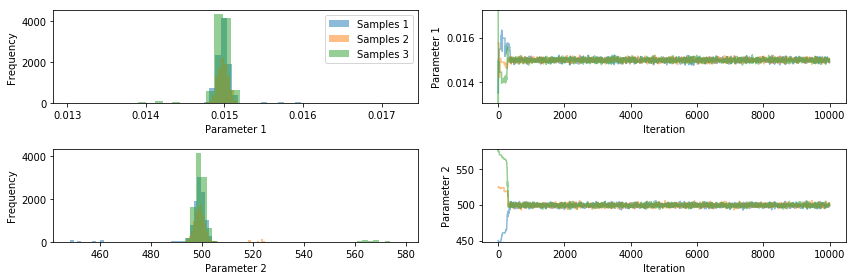

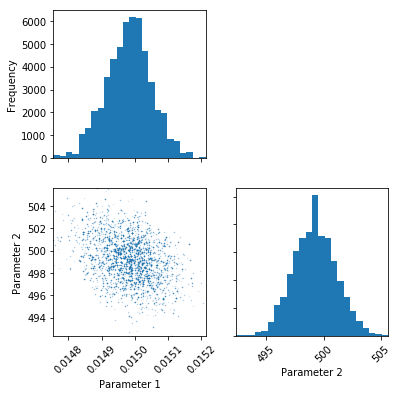

In [27]:
# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains_thin = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_thin[0])

# Show graphs
plt.show()

R-hat:
[1.0018942354413678, 1.0010859500032108]


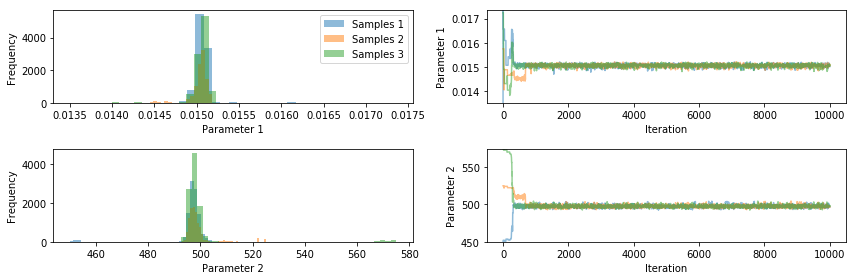

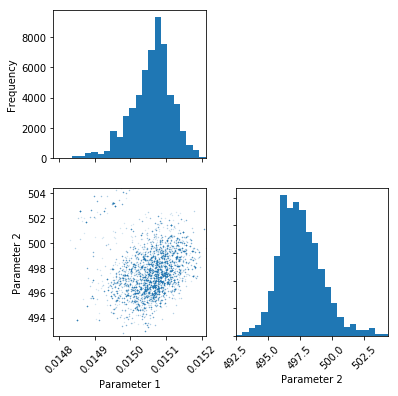

In [28]:
# Show traces and histograms
pints.plot.trace(chains_emu)

# Discard warm up
chains_emu_thin = chains_emu[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_emu_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_emu_thin[0])

# Show graphs
plt.show()

In [29]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

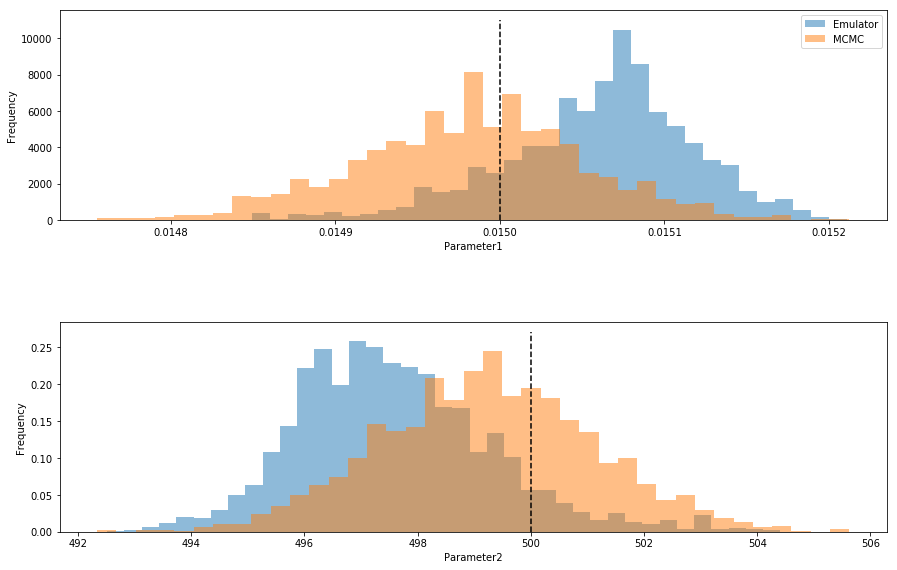

In [30]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

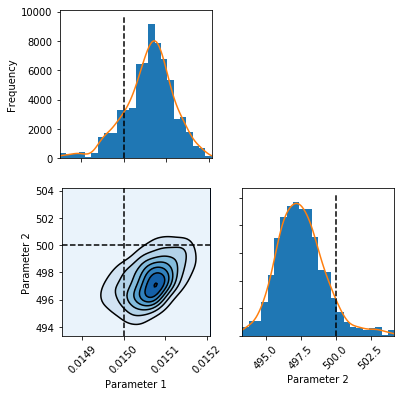

In [31]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

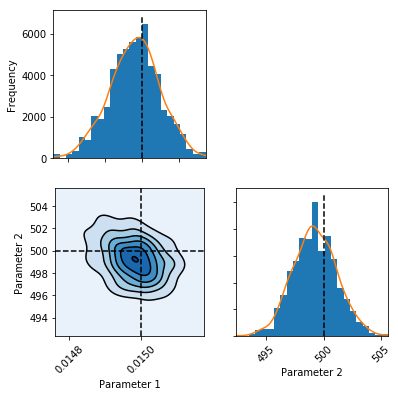

In [32]:
thinned_chain = chain[::10]
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

In [33]:
emu_likelihood = np.apply_along_axis(emu, 1, chain).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

0.0030627626946862037

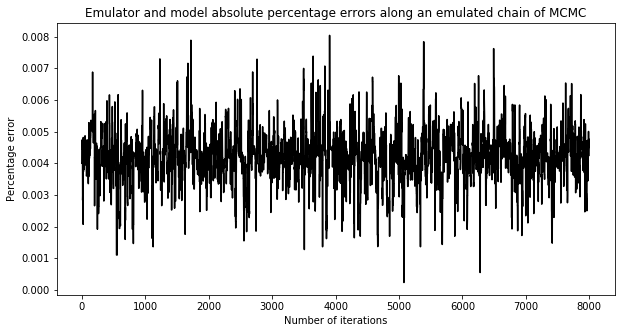

0.004212038571176322

In [34]:
emu_likelihood = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along an emulated chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

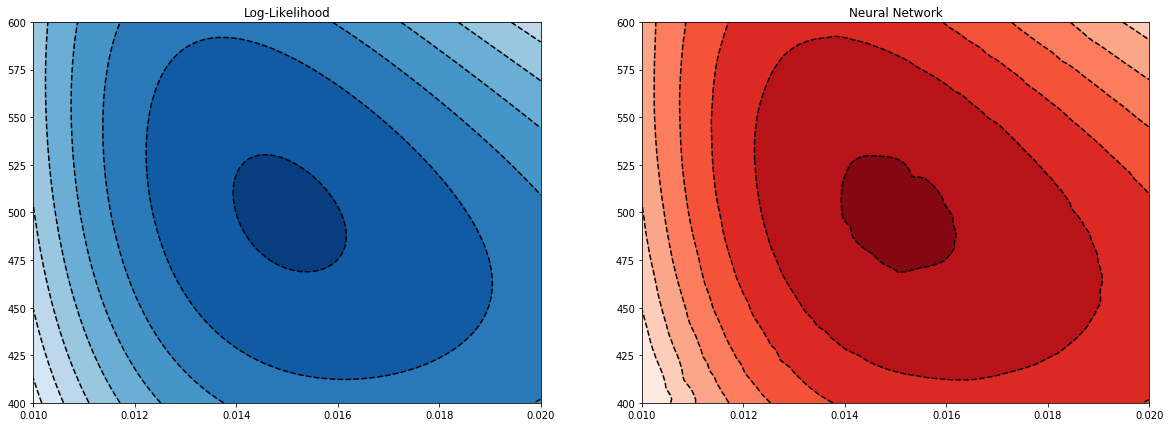

In [35]:
# Create grid of parameters
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

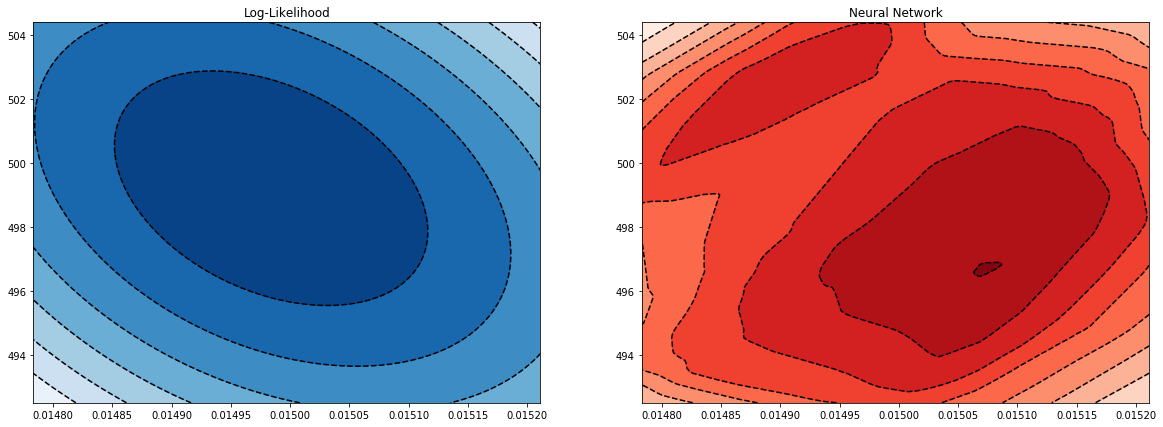

In [36]:
# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

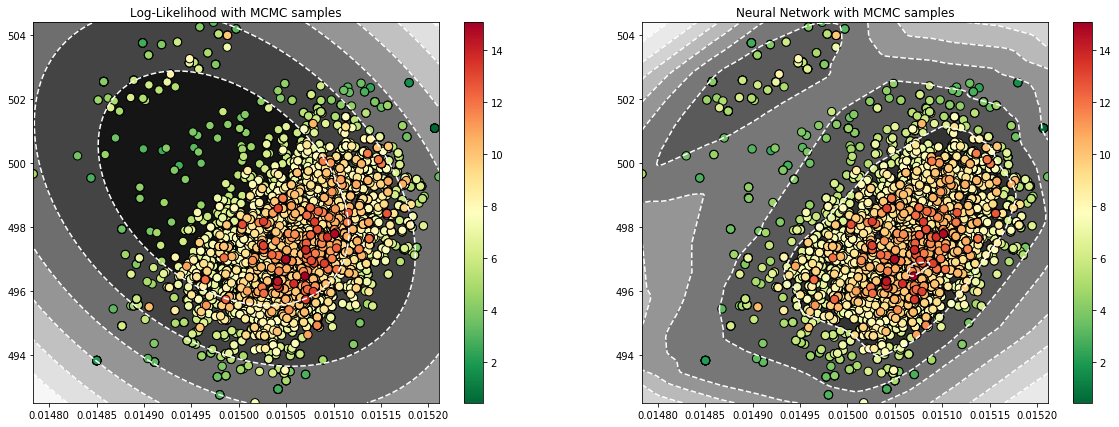

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to differences in log-likelihood
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
im1 = ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
im2 = ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

fig.savefig("figures/nn-test-contours-old-1000-5perc.png", bbox_inches='tight', dpi=600)

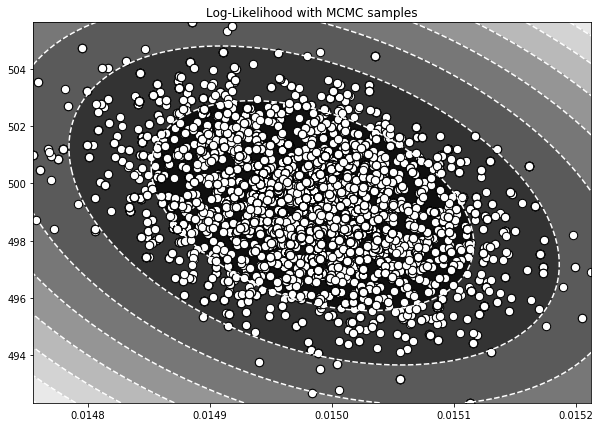

In [38]:
fig, ax = plt.subplots(figsize=(10,7))                   
ax.title.set_text('Log-Likelihood with MCMC samples')                                                                   

# Plot chain
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x, y, s=70, edgecolor='k', color='w')
plt.show()